# Processing data through July 2017

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.ndimage
import skimage.io
import skimage.measure
import skimage.morphology
import skimage.segmentation
import skimage.filters
import scipy.ndimage
import tqdm
import scipy.optimize
import scipy.special

import pandas as pd
import xmltodict
import json
import glob
import os
import shutil
import sys
sys.path.insert(0, '../')
import mscl_utils as mscl
colors = mscl.set_plotting_style()
%matplotlib inline

## Status of data
HJ gave me a bunch of data covering a wide range of MscL expression constructs. 


## Things to tidy-up and finish. 
There are still a bunch of things I need to finish with the code to make things ready for a pipeline. 

1. Fix the metadata parsing function to extract the correct exposure times. Right now, it's pulling the brightfield exposure times for the fluorescence channel. Maybe here I can use some random package from the internet to scrape image metadata files. 

2. Include a distance filter for the centroid-click pairing scheme. Right now, if a cell is lost it will match it up withi whatever is the closest click position. I think including a maximum distance filter would be sufficient. 

3. **(Optional)** Improve segmentation to isolate single-cells. 

##  Relevant Functions
Below are the functions I've written this far for segmentation and survival tracking analysis. Whatever functions are here are what I used for the analysis in this notebook.  

In [30]:
def contour_seg(image, level=0.3, selem='default', perim_bounds=(5, 1E3),
                ip_dist=0.160, ecc_bounds=(0.7, 1), area_bounds=(1, 50), 
                return_conts=False, min_int=0.2):
    """
    Identifies contours around dark objects in a phase contrast image.

    Parameters
    ----------
    image: 2d-array
        Phase contrast image of interest. This shoul
    level: float
        Level at which to draw contours on black top-hat filtered image.
        Default value is 0.3.
    selem: 2d-array or string
        Structuring element to use for the black top-hat filtering procedure
        Default value is a disk with a diameter of 20 pixels.
    perim_bounds: length 2 tuple
        Lower and upper perimeter bounds of approved objects. This should be
        in units of microns. The default values are 5 and 25 microns for the
        lower and upper bound, respectively.
    ip_dist : float
        Interpixel distance of the image in units of microns per pixel. The
        default value is 0.160 microns per pixel.
    area_bounds : tuple of float
        Upper and lower bounds for selected object areas. These should be given in
        units of square microns. 
    ecc_bounds : tuple of float
        Bounds for object eccentricity. Default values are between 0.5 and 1.0. 
    return_conts : bool
        If True, the x and y coordinates of the individual contours will be
        returned. Default value is False

    Returns
    -------
    im_lab : 2d-array, int
        Two dimensional image where each individual object is labeled.

    conts : 1d-array
        List of contour coordinates. Each entry of this array comes as
        an x,y pair of arrays. Has the same length as the number of
        contoured objects. This is only returned if `return_conts` is
        True.

    """

    # Apply the white top-hat filter.
    if selem == 'default':
        selem = skimage.morphology.disk(20)

    # Normalize the image.
    image = (image - image.min()) / (image.max() - image.min())

    # Blur and background subtract the image.
    im_blur = skimage.filters.gaussian(image, sigma=5)
    im_sub = image - im_blur

    # Apply the black tophat filter.
    im_filt = skimage.morphology.black_tophat(im_sub, selem)

    # Find the contours and return.
    conts = skimage.measure.find_contours(im_filt, level)

    # Make an empty image for adding the approved objects.
    objs = np.zeros_like(image)

    # Loop through each contour.
    for _, c in enumerate(conts):
        perim = 0
        for j in range(len(c) - 1):
            # Compute the distance between points.
            distance = np.sqrt((c[j+1, 0] - c[j, 0])**2 +
                               (c[j+1, 1] - c[j, 1])**2)
            perim += distance * ip_dist

        # Test if the perimeter is allowed by the user defined bounds.
        if (perim > perim_bounds[0]) & (perim < perim_bounds[1]):

            # Round the contours.
            c_int = np.round(c).astype(int)

            # Color the image with the contours and fill.
            objs[c_int[:, 0], c_int[:, 1]] = 1.0

    # Fill and label the objects.
    objs_fill = scipy.ndimage.binary_fill_holes(objs)
    objs_fill = skimage.morphology.remove_small_objects(objs_fill)
#     objs_border = skimage.segmentation.clear_border(objs_fill)
    im_lab = skimage.measure.label(objs_fill)
   
    # Apply filters.
    approved_obj = np.zeros_like(im_lab)
    props = skimage.measure.regionprops(im_lab, image)
    for prop in props:
        area = prop.area * ip_dist**2
        ecc = prop.eccentricity
        if (area < area_bounds[1]) & (area > area_bounds[0]) &\
            (ecc < ecc_bounds[1]) & (ecc > ecc_bounds[0]) & (prop.mean_intensity < min_int):
                approved_obj +=  (im_lab == prop.label) 
    im_lab = skimage.measure.label(approved_obj)
    
    
    if return_conts is True:
        return conts, im_lab
    else:
        return im_lab


def marker_parse(fname, type_dict={1: False, 2: True}):
    """
    Parses the XML file produced from the CellCounter ImageJ plugin and
    packages the marker positions and type into a Pandas DataFrame.

    Parameters
    ----------
    fname : str
        Path to the XML file of interest.
    type_dict : dict
        Dictionary of types and survival. Default is assigning type 1
        as death and type 2 as survival.

    Returns
    -------
    df : Pandas DataFrame
        Data frame containing x and y positions of markers as well as
        the type classification.
    """
    with open(fname, 'r') as f:
        positions = xmltodict.parse(f.read())

    # Extract only the marker data.
    markers =  positions['CellCounter_Marker_File']['Marker_Data']['Marker_Type']

    # Find the total number of types and loop through them to make data frames.
    dfs = []
    num_types = len(markers)
    for i in range(num_types):
        try:
            type_marks = markers[i]['Marker']
            _df = pd.DataFrame(type_marks)
            # Insert a column keeping track of the type
            _df.insert(0, 'survival', type_dict[int(markers[i]['Type'])])
            dfs.append(_df)
        except:
            pass

    # Concatenate the data frames ignorning indexing.
    df = pd.concat(dfs, axis=0, ignore_index=True)

    # Clean up the data frame and return.
    df.drop('MarkerZ', 1, inplace=True)
    df.columns = ['survival', 'x_pos', 'y_pos']
    df['x_pos'] = df['x_pos'].astype(int)
    df['y_pos'] = df['y_pos'].astype(int)
    return df


def link_markers(markers, seg_mask, fluo_image, ip_dist=0.160,
                 return_coords=False, inplace=False, max_dist=5,
                 position_labels=('x_pos', 'y_pos')):
    """
    Maps markers from one image to centroids of segmented objects from
    another. This assumes a marker belongs to the object with the minimum
    marker-centroid distance.

    Parameters
    ----------
    markers : Pandas DataFrame
        DataFrame containing the x and y positions of the markers.
    seg_mask : 2d-array, int
        Labeled segmentation mask. The coordinates of the object centroids
        will be calculated from this image.
    fluo_image : 2d-array, float or int
        The fluorescence image used to extract intensities. If None, no
        intensity information will be returned. These intensity values
        will be returned as an intensity per square physical distance
        as given by `ip_dist`.
    ip_dist :  float
        Interpixel distance for the image. Default value is 0.160 microns
        per pixel.
    return_coords : bool
        If True, the paired coordinates will be returned as a tuple. It
        will have the form ((mark_x, mark_y), (cent_x, cent_y)). Default
        value is False.
    inplace : bool
        If True, the markers DataFrame will be updated in place with the
        paired mask label and intensity if the fluorescence image is given.
    max_dist : float
        Maximum distance to keep. Default Value is 5 microns. 
    position_labels :  tuple of str
        Labels of position markers in the markers DataFrame in the order
        of x position and y position. Default is `x_pos` and `y_pos`.

   Returns
   -------
   df : Pandas DataFrame
       DataFrame containing survival type, marker positions, mask label,
       area, and intensity if provided. Note this is not returned if
       `in_place = True`.
   coords : list of tuple
       A list of tuples containing the marker x,y positions and the
       coordinates of the associated segmentation centroid. This
       is only returned if `return_coords`==True.

    """
    # Compute the properties from the segmentation mask.
    props = skimage.measure.regionprops(seg_mask, fluo_image)
    area, intensity, labels, centroids = [], [], [], []
    for prop in props:
        area.append(prop.area * ip_dist**2)
        intensity.append(prop.mean_intensity / ip_dist**2)
        labels.append(prop.label)
        centroids.append(prop.centroid)

    # Set up a list to store the coordinates and duplicate the df.
    coords = []
    if type(markers) == str:
        df= pd.DataFrame([intensity, area]).T
        df.columns=['intensity','area']
        df.insert(np.shape(df)[1], 'dist', 0)
        df.insert(0, 'label_cent_y', 0)
        df.insert(0, 'label_cent_x', 0)
        df.insert(0, 'mask_label', labels )
        df.insert(0, 'y_pos', 0)
        df.insert(0, 'x_pos', 0)
        df.insert(0, 'survival', False)
        return df 
        
    else:
        df = markers.copy(deep=True)

        
        # Compute the minimum distances.
        for i in range(len(markers)):
            distances = []
            x = markers.iloc[i][position_labels[0]]
            y = markers.iloc[i][position_labels[1]]

            # Loop through each centroid and find the minimum distance.
            for c in centroids:
                dist = np.sqrt((x - c[1])**2 + (y - c[0])**2)
                distances.append(dist)
            if len(distances) == 0:
                df.set_value(i, 'dist', 1E6)
                pass
            else:
                # Find the index with the minimum distance.
                min_ind = np.argmin(distances)
                coords.append(((x, y),
                               (centroids[min_ind][1], centroids[min_ind][0])))

                # Determine if a new DataFrame should be made or not.
                # There should be a better way to do this -- will spruce up later.
                if inplace is False:
                    # Update the data frame.
                    df.set_value(i, 'mask_label', labels[min_ind])
                    df.set_value(i, 'label_cent_x', centroids[min_ind][1])
                    df.set_value(i, 'label_cent_y', centroids[min_ind][0])
                    df.set_value(i, 'intensity', intensity[min_ind])
                    df.set_value(i, 'area', area[min_ind])
                    df.set_value(i, 'dist', distances[min_ind])
                else:
                    markers.set_value(i, 'mask_label', labels[min_ind])
                    markers.set_value(i, 'label_cent_x', centroids[min_ind][1])
                    markers.set_value(i, 'label_cent_y', centroids[min_ind][0])
                    markers.set_value(i, 'intensity', intensity[min_ind])
                    markers.set_value(i, 'area', area[min_ind])

        # Apply the distance filter. 
        if inplace is False:
            df = df[df['dist'] <= (max_dist / ip_dist)]
            if return_coords is True:
                return df, coords
            else:
                return df


def scrape_metadata(fname, channels=('Brightfield', 'GFP'), return_date=True):
    """
    Takes an image metadata file and returns the datea nd GFP exposure time.

    Parameters
    ----------
    fname : str
        Pat of the metadata file to parse.
    channel : tuple of str
        The channels from which to scrape the exposure time. A single channel
        name can be given. Default is ('Brightfield', 'GFP').
    return_date : bool
        If True, the date of the acquisition will also be returned.

    Returns
    -------
    exposure: dict or float
        The exposure time of the desired channel. If multiple channels are
        given, this will be a tuple of the exposure times. If return_date is
        True, the date will also be in this dictionary.
   """

    # Open the metadata file.
    with open(fname, 'r') as f:
        metadata = json.load(f)

    

    # Get a list of the keys in the metadata file.
    keys = metadata.keys()

    # Determine if a single channel or multiple channel exposures are desired.
    if (type(channels) != tuple) & (type(channels) != str):
        raise TypeError('desired channels must be a tuple or a string.')
    else:
        if type(channels) == str:
            num_channels = 1
            channels = (channels)
            exposure = None
        else:
            num_channels = len(channels)
            exposure = []

    # Loop through each desired channel and scrape the exposure.
    for i in range(num_channels):
        for k in keys:
            try:
                chan = metadata[k]['Channel']
                if chan.lower() == channels[i].lower():
                    _exposure = metadata[k]['Exposure-ms']
                if num_channels == 1:
                    exposure = _exposure
                else:
                    if i == 0:
                        exposure = {channels[i] + '_exp_ms': _exposure}
                    else:
                        exposure[channels[i] + '_exp_ms'] = _exposure
            except:
                pass

    if return_date is True:
        # Get the date from the Summary field.
        date = metadata['Summary']['Date'].split('-')
        date = ''.join(date)
        exposure['date'] = date
    return exposure


def save_seg(fname, image, mask, fill_contours=True, ip_dist=0.160,
             bar_length=10, title=None, colormap='hls'):
    """
    Saves a merge of a segmentation mask and the original image for a
    sanity check.

    Parameters
    ----------
    fname : str
        The file will be saved with this path.
    image : 2d-array, float
        The original image on which the segmentation mask will be overlaid.
    mask : 2d-array, bool
        Boolean segmentation mask of the original image.
    contours: bool
        If True, contours of segmented objects will be filled.
    ip_dist : float
        Interpixel distance for the image. This is used for computing the
        scalebar length.  This should be in units of microns. Default
        value is 0.160 microns per pixel.
    bar_length : int
        The length of the desired scalebar in units of microns.
    title : str, optional
        Title for the image.
    colormap : str
        Colormap for labeling the objects. Default is the high-contrast
        'hls'. This can take any standard colormap string.

    Return
    ------
    fig : Matplotlib Figure object
        Figure containing the axis of the plotted image.
    """

    # Make copies of the image and mask.
    image_copy = np.copy(image)
    mask_copy = np.copy(mask)

    # Burn the scalebar into the upper-left hand  of th image.
    num_pix = int(bar_length / ip_dist)
    image = (image_copy - image_copy.min()) /\
            (image_copy.max() - image_copy.min())
    image[10:20, 10:10 + num_pix] = 1.0

    # Make sure the mask is a boolean image.
    if type(mask) != bool:
        mask = mask_copy > 0

    # Find the contours of the mask.
    conts = skimage.measure.find_contours(mask, 0)

    # Plot the image and generate the contours.
    with sns.axes_style('white'):
        fig = plt.figure()
        plt.imshow(image, cmap=plt.cm.Greys_r)

        # Plot all of the contours
        colors = sns.color_palette(colormap, n_colors=len(conts))
        for i, c in enumerate(conts):
            plt.plot(c[:, 1], c[:, 0], color=colors[i], lw=0.75)
            if fill_contours is True:
                plt.fill(c[:, 1], c[:, 0], color=colors[i], alpha=0.5)

        # Remove the axes.
        plt.xticks([])
        plt.yticks([])

        # Add title if provided.
        if title is not None:
            plt.title(title)

        # Tighten up and save the image.
        plt.tight_layout()
        plt.savefig(fname, bbox_inches='tight')
        plt.close()
    return fig


def show_connections(fname, image, data, title=None, bar_length=10,
                     ip_dist=0.16):
    """
    Saves the original phase contrast image with the segmented
    centroids and the manually recorded markers linked by lines.

    Parameters
    ----------
    fname : str
        Filename to save the image wish shown connections between
        segmented object centroids and the markers.
    image : 2d-array
        Original phase contrast image over which the points will
        be drawn
    data : Pandas DataFrame
        DataFrame containing the marker x and y positions and the
        centroid x and y positions.
    title : str
        Title to be applied to the image. If not specified, none will
        be included.
    bar_length : int
        Length of the scalebar in units of microns. Default value
        is 10.
    ip_dist : float
        Interpixel distance of the image. This should be in units of
        microns per pixel. Default value is 0.16 microns per pixel.

    Returns
    -------
    fig : Matplotlib Figure Canvas
        Figure canvas of the plot.
    """
    # Add the scale bar to the image.
    if image.max() > 1:
        image = (image - image.min()) / (image.max() - image.min())
    num_pix = int(bar_length / ip_dist)
    image_copy = np.copy(image)
    image_copy[10:20, 10:10 + num_pix] = 1.0

    # Define the colors for survivors and corpses.
    colors = {False: '#D56C55', True: '#08AADE'}

    # Group the DataFrame by survival.
    grouped = pd.groupby(data, 'survival')

    # Show the image
    with sns.axes_style('white'):
        fig = plt.figure()
        plt.imshow(image_copy, cmap=plt.cm.Greys_r)
        plt.plot([], [], '-o', ms=3, lw=1, color=colors[True],
                 label='survivor')
        plt.plot([], [], '-o', ms=3, lw=1, color=colors[False], label='goner')
        plt.legend(loc='lower left')
        for g, d in grouped:
            for i in range(len(d)):
                # Parse the positions
                m_x = d.iloc[i]['x_pos']
                m_y = d.iloc[i]['y_pos']
                c_x = d.iloc[i]['label_cent_x']
                c_y = d.iloc[i]['label_cent_y']
                # Plot the connections.
                plt.plot((m_x, c_x), (m_y, c_y), '-', ms=3, lw=1,
                         color=colors[g])
                plt.plot(m_x, m_y, 'o', ms=3, lw=1, color=colors[g])
                plt.plot(c_x, c_y, 'o', ms=3, markerfacecolor='w',
                         markeredgecolor=colors[g], markeredgewidth=1)

        # Format the axes
        plt.xticks([])
        plt.yticks([])

        # Add a title if necessary.
        if title is not None:
            plt.title(title, fontsize=12)
        plt.savefig(fname, bbox_inches='tight')
    return fig

##  Performing the processing

Let's start with the SD1 data

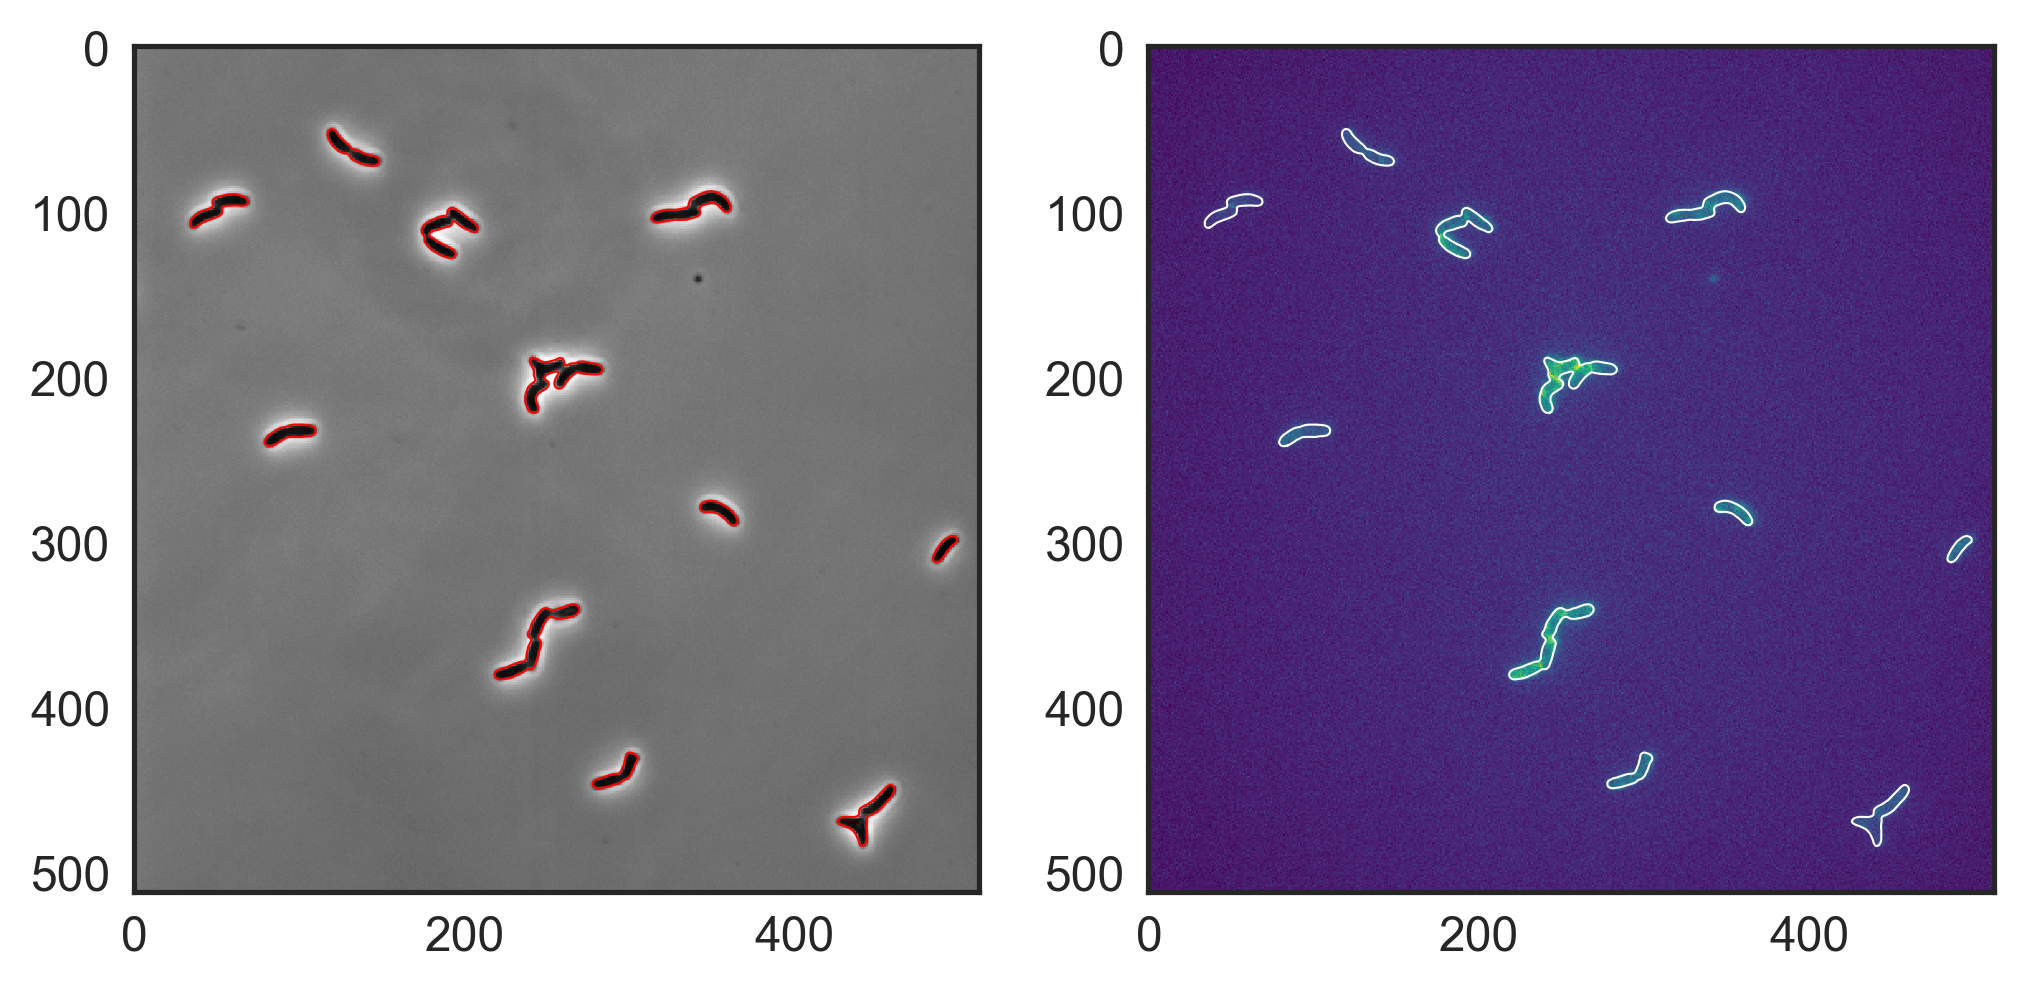

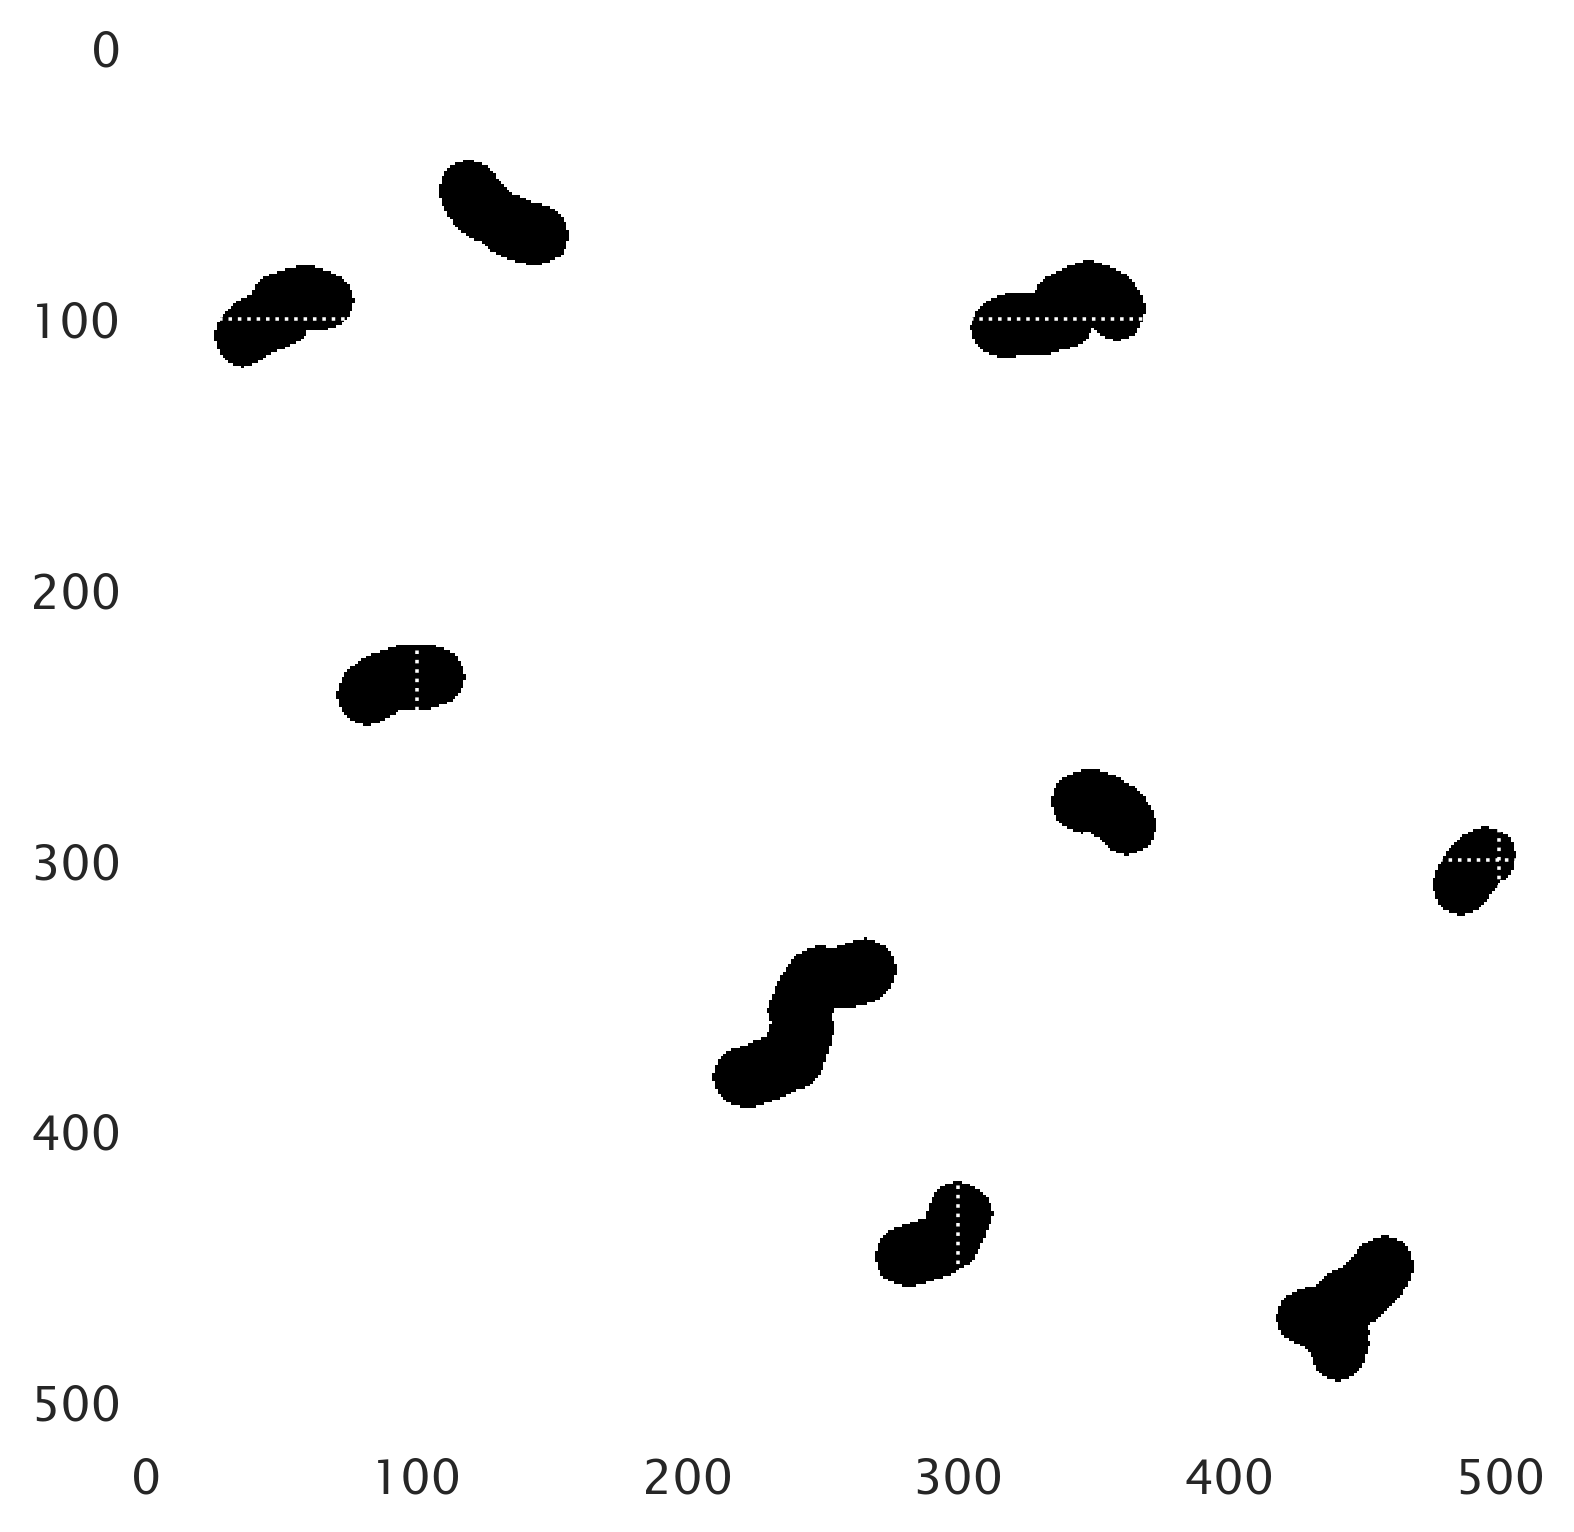

In [31]:
# Grab all of the image files for SD1. 
data_dir = 'data/images/'
sd0_bf_files = glob.glob(data_dir + 'sd0/*/*/*/*Brightfield*.tif')
sd0_gfp_files = glob.glob(data_dir + 'sd0/*/*/*/*GFP*.tif')

# # Make sure everything is working OK with a single image file.

im_phase = skimage.io.imread(sd0_bf_files[0])
im_gfp = skimage.io.imread(sd0_gfp_files[0])

# Pass the phase image through the contour segmentation function. 
conts, im_seg = contour_seg(im_phase, return_conts=True)

with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(im_phase, cmap=plt.cm.Greys_r)
    ax[1].imshow(im_gfp, cmap='viridis')
    for c in conts:
        ax[1].plot(c[:,1], c[:,0], 'w-', lw=0.5)
        ax[0].plot(c[:,1], c[:,0], 'r', lw=0.5)
        
        
# Perform an ad-hoc bg subtraction. 
obj = im_seg > 0
obj_dil = skimage.morphology.dilation(obj, selem=skimage.morphology.disk(8))
inv_seg = obj_dil < 1
fig, ax = plt.subplots(1,1)
plt.imshow(inv_seg, cmap=plt.cm.Greys_r)

Okay, that segmentation actually looks pretty good. HJ didn't give me any marker posisitons with these data sets, so I'm just kind of restricted to grabbing the fluorescence information from each. Before I move on, let's figure out how to get the exposure information in a reliable way. 

In [435]:
folders = ['sd0', 'sd2']#, 'sd4', 'sd1', '10sd1', 'sd2', '12sd2']
ip_dist = 0.16
dfs = []
for i, f in enumerate(folders):
    # Glob all the file names. 
    if (f == 'sd1') | (f == 'sd4'):
        target = '/*/*/*.tif'
        files = glob.glob(data_dir + f + target)
        files_met = glob.glob(data_dir + f + '/*/*/*metadata.txt')
        print(len(files))
    else:
        target_bf = '/*/*/*/*Brightfield*.tif'
        target_gfp = '/*/*/*/*GFP*.tif'
        files= glob.glob(data_dir + f + target_bf)
        files_gfp = glob.glob(data_dir + f + target_gfp)
        files_met = glob.glob(data_dir + f +'/*/*/*/*metadata.txt')
        print(len(files), len(files_gfp))
     
    # Loop through each image and process
    for j, file in enumerate(files):
        if (f == 'sd1') | (f == 'sd4'):
            im = skimage.io.imread(file)
            im_phase = im[0]
            im_gfp = im[1] 
            name = file.split('/')[-1]

        else:
            im_phase = skimage.io.imread(file)
            im_gfp = skimage.io.imread(files_gfp[j])
            name = file.split('/')[-3]
       
        # Filter the image. 
        selem = skimage.morphology.square(3)
        im_gfp = scipy.ndimage.median_filter(im_gfp, footprint=selem)
        

        
        # Determine the sample ID.
#         flow_rate = float(name.split('.')[-1].split('Hz')[0])
        exp = scrape_metadata(fname=files_met[j], return_date=False)
        # Process.
        conts, seg = contour_seg(im_phase, return_conts=True, perim_bounds=(5, 1E5),
                                 ecc_bounds=(0.7, 1.0), area_bounds=(1, 100)) 
#         seg = contour_seg(im_phase) 
        
        # Perform the field bg subtraction. 
        flat_seg = seg > 0
        dil_selem = skimage.morphology.disk(8)
        im_dil = skimage.morphology.dilation(flat_seg, dil_selem)
        inv_seg = skimage.measure.label(im_dil < 1)
        inv_props = skimage.measure.regionprops(inv_seg, im_gfp)
        mean_bg = np.mean([prop.mean_intensity / ip_dist**2 for prop in inv_props])
        
        props = skimage.measure.regionprops(seg, im_gfp)
        
        # Convert total
        raw_intensities = np.array([prop.mean_intensity/ip_dist**2 for prop in props])
        sub_intensities = raw_intensities - mean_bg
        areas = [prop.area * ip_dist**2 for prop in props]
        
        # Make a DataFrame of all of the relevant properties.
        df = pd.DataFrame([raw_intensities, sub_intensities, areas]).T
        df.insert(0, 'mean_bg', mean_bg)
        df.insert(0, 'exposure_ms', exp['GFP_exp_ms'])
#         df.insert(0, 'flow_rate', flow_rate)
        df.insert(0, 'sd', f) 
        df.insert(0, 'date', files[j].split('/')[3])
        dfs.append(df)
     
# Concatenate all of the DataFrames together. 
SDdata = pd.concat(dfs)

34 34
80 80


In [556]:
# Modify the intensities. 
SDdata.columns = ['date', 'sd', 'exposure_ms', 'mean_bg', 'raw_intensities', 'sub_intensity', 'areas']
max_exp = SDdata['exposure_ms'].unique().max()
min_exp = SDdata['exposure_ms'].unique().min()
SDdata['scaled_int'] = SDdata['sub_intensity'] *  max_exp / SDdata['exposure_ms']
SDdata['scaled_raw'] = SDdata['raw_intensities'] * max_exp / SDdata['exposure_ms']
mean_wt = SDdata[SDdata['sd']=='sd0']['scaled_int'].mean()
SDdata['rescaled_int'] = SDdata['scaled_raw']  - (SDdata['mean_bg'] * max_exp / SDdata['exposure_ms'])
SDdata['rescaled_bg'] = SDdata['mean_bg'] * max_exp / SDdata['exposure_ms']
SDdata['rel_int'] = SDdata['rescaled_int'] / SDdata[SDdata['sd']=='sd0']['rescaled_int'].mean()

ValueError: Length mismatch: Expected axis has 13 elements, new values have 8 elements

In [276]:
SDdata

date     sd  flow_rate  exposure_ms        mean_bg  raw_intensities  \
0   Jul14    sd0  SD0_pre_3           25   60328.405228    115264.201793   
1   Jul14    sd0  SD0_pre_3           25   60328.405228    149016.054874   
2   Jul14    sd0  SD0_pre_3           25   60328.405228     87861.592061   
3   Jul14    sd0  SD0_pre_3           25   60328.405228    121521.205357   
4   Jul14    sd0  SD0_pre_3           25   60328.405228    162946.585323   
5   Jul14    sd0  SD0_pre_3           25   60328.405228    134958.437500   
6   Jul14    sd0  SD0_pre_3           25   60328.405228    205828.945879   
7   Jul14    sd0  SD0_pre_3           25   60328.405228    150139.576982   
8   Jul14    sd0  SD0_pre_3           25   60328.405228    108340.745192   
0   Jul14    sd0  SD0_pre_3           25   60220.905408    127659.065315   
1   Jul14    sd0  SD0_pre_3           25   60220.905408    150633.346688   
2   Jul14    sd0  SD0_pre_3           25   60220.905408    123396.297089   
3   Jul14    sd0  SD0_pre_3           25   60220.905408    109243.001302   
4   Jul14    sd0  SD0_pre_3           25   60220.905408    164189.735368   
5   Jul14    sd0  SD0_pre_3           25   60220.905408    123017.348885   
6   Jul14    sd0  SD0_pre_3           25   60220.905408    143119.511880   
7   Jul14    sd0  SD0_pre_3           25   60220.905408    115105.260019   
0   Jul14    sd0  SD0_pre_3           25   57779.281721    123381.117335   
1   Jul14    sd0  SD0_pre_3           25   57779.281721    141626.376793   
2   Jul14    sd0  SD0_pre_3           25   57779.281721    127231.292040   
3   Jul14    sd0  SD0_pre_3           25   57779.281721    115128.016708   
4   Jul14    sd0  SD0_pre_3           25   57779.281721    137200.220121   
0   Jul14    sd0  SD0_pre_3           25   58733.694247    155227.500000   
1   Jul14    sd0  SD0_pre_3           25   58733.694247    117792.505924   
2   Jul14    sd0  SD0_pre_3           25   58733.694247    134179.023172   
3   Jul14    sd0  SD0_pre_3           25   58733.694247    130235.000000   
4   Jul14    sd0  SD0_pre_3           25   58733.694247    180347.636115   
5   Jul14    sd0  SD0_pre_3           25   58733.694247    199029.346113   
6   Jul14    sd0  SD0_pre_3           25   58733.694247     89261.877828   
7   Jul14    sd0  SD0_pre_3           25   58733.694247    113441.363324   
..    ...    ...        ...          ...            ...              ...   
0   May19  12sd2        5Hz           50  256703.410046    312327.958777   
1   May19  12sd2        5Hz           50  256703.410046    355487.734574   
2   May19  12sd2        5Hz           50  256703.410046    310852.684738   
3   May19  12sd2        5Hz           50  256703.410046    351368.913153   
4   May19  12sd2        5Hz           50  256703.410046    379950.873362   
0   May19  12sd2        5Hz           50  260539.763769    281740.451389   
1   May19  12sd2        5Hz           50  260539.763769    256942.898337   
2   May19  12sd2        5Hz           50  260539.763769    301848.996857   
3   May19  12sd2        5Hz           50  260539.763769    382135.066106   
0   May19  12sd2        5Hz           50  262458.887780    365108.155708   
1   May19  12sd2        5Hz           50  262458.887780    395934.709821   
2   May19  12sd2        5Hz           50  262458.887780    439117.598684   
3   May19  12sd2        5Hz           50  262458.887780    402988.189982   
4   May19  12sd2        5Hz           50  262458.887780    236354.425604   
5   May19  12sd2        5Hz           50  262458.887780    384891.814558   
6   May19  12sd2        5Hz           50  262458.887780    332767.096185   
7   May19  12sd2        5Hz           50  262458.887780    310680.946095   
0   May19  12sd2        5Hz           50  258093.491842    329575.717374   
1   May19  12sd2        5Hz           50  258093.491842    371523.780154   
2   May19  12sd2        5Hz           50  258093.491842    338145.437764   
0   May19  12sd2        5Hz           50  260193.4556

In [ ]:
max_exp

Now the data is processed, although I'm still not 100% sure of the difference in exposure time between them. For right now, we can just group them by SD and jitter plot them. 

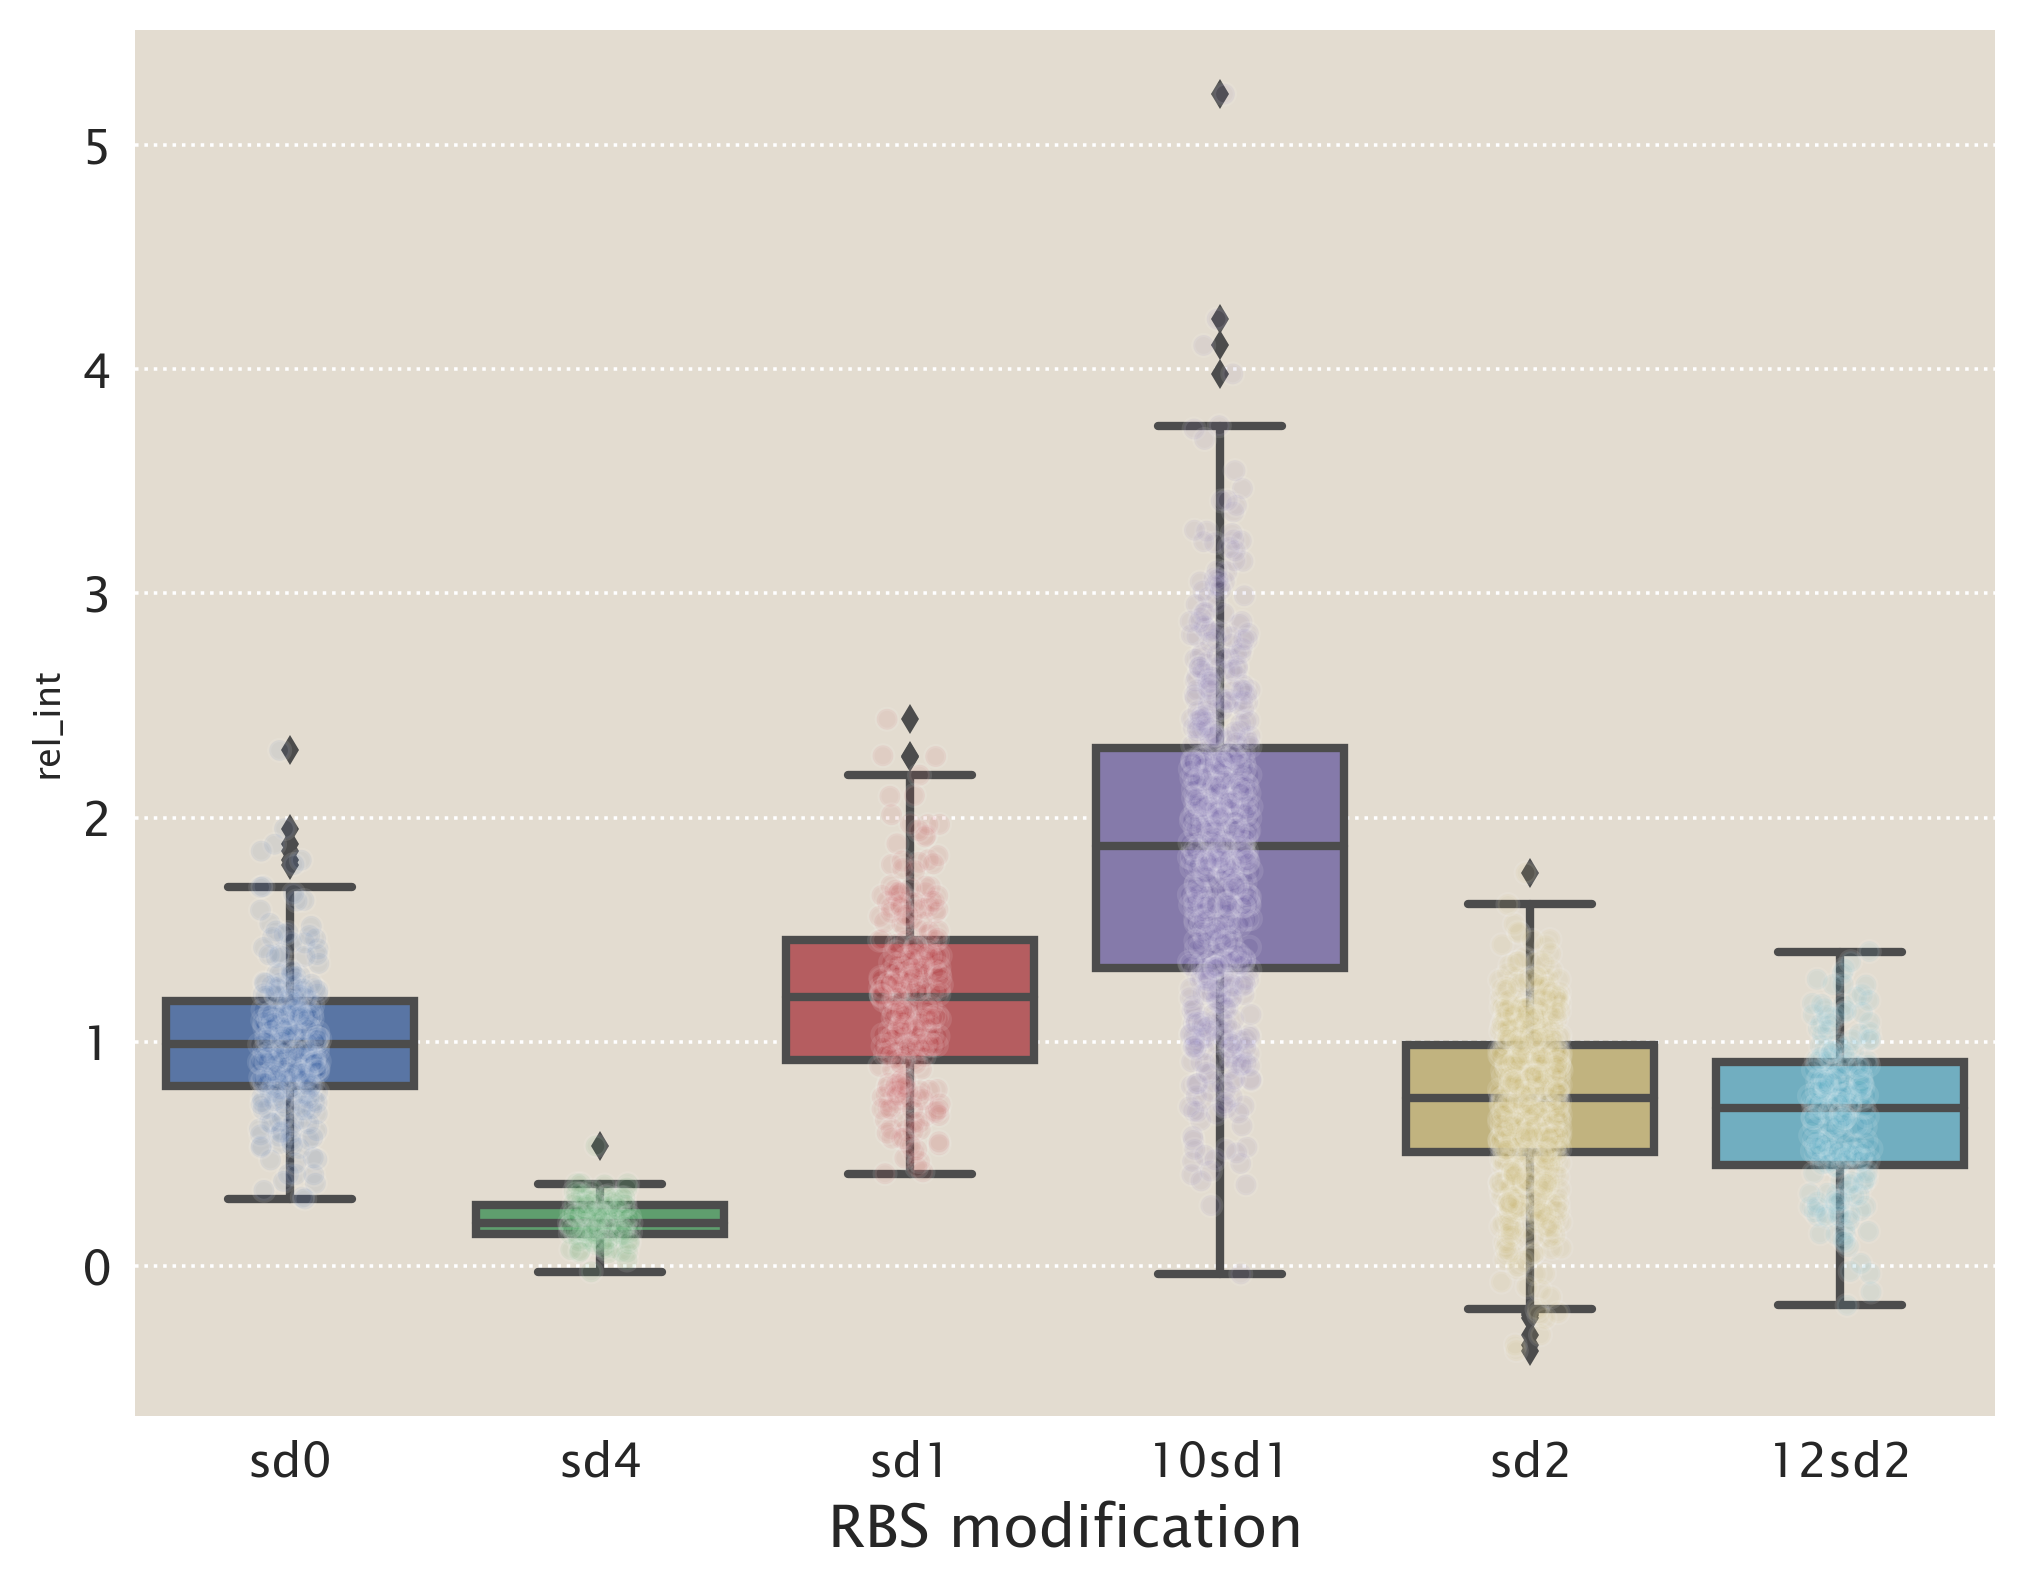

In [277]:
y = 'rel_int'
sns.stripplot(x='sd', y=y, data=SDdata, jitter=True, alpha=0.1, 
             edgecolor='white', linewidth=1)
sns.boxplot(x='sd', y=y, data=SDdata)
plt.xlabel('RBS modification', fontsize=14)
# plt.ylabel('relative intensity to SD0', fontsize=14)

# Mapping Markers 

From the above plot, it seems like just mapping fluorescence to survival is going to be the better bet. HJ sent me a bunch of markers to deal with over the weekend, so my goal will be to now proces *all* of the data I've been given, measure the intensity, and survival designation. Then, I'll worry about how to bin the data and generate statistical errorbars. The markers I have are as follows. 

1. 10SD1
2. 12SD2
3. SD1
4. SD2


In [32]:
folders = ['16sd0', 'sd6', 'sd1', '10sd1', '12sd2', 'sd1_nostack','sd2', 'sd4']
# folders = ['sd1']
dfs = []
for i, f in enumerate(folders):
    # Glob all the file names. 
    if (f == 'sd1') | (f == 'sd4') | (f=='sd6') | (f=='16sd0'):
        target = '/*/*/*.tif'
        files = np.sort(glob.glob(data_dir + f + target))
        files_met = np.sort(glob.glob(data_dir + f + '/*/*/*metadata.txt'))
        files_mark = np.sort(glob.glob(data_dir + f + '/*/*/*.xml'))
        print(len(files), len(files_mark))
    
    else:
        target_bf = '/*/*/*/*Brightfield*.tif'
        target_gfp = '/*/*/*/*GFP*.tif'
        files= np.unique(np.sort(glob.glob(data_dir + f + target_bf)))
        files_gfp = np.unique(np.sort(glob.glob(data_dir + f + target_gfp)))
        files_met = np.unique(np.sort(glob.glob(data_dir + f +'/*/*/*/*metadata.txt')))
        files_mark = np.unique(np.sort(glob.glob(data_dir + f + '/*/*/*.xml')))
        
    print(f)
        
     
    # Loop through each image and process
    for j, file in enumerate(files):
        if (f == 'sd1') | (f == 'sd4') | (f=='sd6') | (f=='16sd0'):
            fname = files
            im = skimage.io.imread(file)
            im_phase = im[0]
            im_gfp = im[1] 
            name = file.split('/')[-1]
            flow_rate = float(file.split('/')[-2].split('_')[-1].split('Hz')[0])
            fl_file = files[j]

        else:
            im_phase = skimage.io.imread(file)
            im_gfp = skimage.io.imread(files_gfp[j])
            name = file.split('/')[-3]
            flow_rate = float(file.split('/')[-3].split('_')[-1].split('Hz')[0])
            fl_file = files_gfp[j]
        
        # Determine the sample ID.  
        exp = scrape_metadata(fname=files_met[j], return_date=False)
        
        # Filter the image. 
        selem = skimage.morphology.square(3)
        im_gfp = scipy.ndimage.median_filter(im_gfp, footprint=selem)
                
       
        # Process.
        conts, seg = contour_seg(im_phase, return_conts=True, perim_bounds=(5, 1E5),
                                 ecc_bounds=(0.7, 1.0), area_bounds=(1, 100)) 
        
        # Perform the field bg subtraction. 
        flat_seg = seg > 0
        dil_selem = skimage.morphology.disk(8)
        im_dil = skimage.morphology.dilation(flat_seg, dil_selem)
        inv_seg = skimage.measure.label(im_dil < 1)
        inv_props = skimage.measure.regionprops(inv_seg, im_gfp)
        mean_bg = np.mean([prop.mean_intensity /ip_dist**2 for prop in inv_props])

        
        # Process cell markers. 

        if f == 'sd6':
            fname_split = files[j].split('/')[-1].split('_')[-1].split('.')[0]
            positions = [files_mark[k].split('/')[-1].split('.')[0] for k in range(len(files_mark))]
#             pos_split = files_mark[j].split('/')[-1].split('.')[0]
#             print(fname_split, pos_split)
            for k in range(len(positions)):
                if fname_split == positions[k]: 
                    print('marker files match for sd6: %s -> %s' %(fname_split, positions[k]))
                    markers = marker_parse(files_mark[k])
                    
                    break
                else:
                    markers = 'none' 
        else:
            markers = marker_parse(files_mark[j])

        df = link_markers(markers, seg, im_gfp, max_dist=5)
        if len(df) == 0:
            pass
        else:
            # Save connection figure. 
            if (f=='sd1') | (f=='sd4') | (f=='sd6') | (f=='16sd0'):
                out_dir = files[j][:-len(files[j].split('/')[-1])]
                new_name = files[j].split('/')[-1]
            else:
                split = files[j].split('/')
                out_dir = files[j][:-(len(split[-2]) + len(split[-1]) + 1)]
                new_name = split[-2]
                
            
            if os.path.isdir(out_dir + 'outfiles') == False:
                os.mkdir(out_dir + 'outfiles')
            else:
                shutil.rmtree(out_dir + 'outfiles')    
                os.mkdir(out_dir + 'outfiles')
            
            im_name = out_dir + 'outfiles/' + new_name
            _fig = save_seg(im_name + '_segmentation.pdf', im_phase, seg)
            if type(markers) != str:
                _fig = show_connections(im_name + '_connections.pdf', im_phase, df)
                
            plt.close('all')
                
            # Make a DataFrame of all of the relevant properties.
            df.insert(0, 'phase_name', files[j])
            df.insert(0, 'fluo_name', fl_file) 
            df.insert(0, 'mean_bg', mean_bg)
            df.insert(0, 'exposure_ms', exp['GFP_exp_ms'])
            df.insert(0, 'flow_rate', flow_rate)
            df.insert(0, 'sd', f) 
            df.insert(0, 'date', files[j].split('/')[3])
            dfs.append(df)
         
# Concatenate all of the DataFrames together. 
data = pd.concat(dfs)
# data.columns = ['sd', 'flow_rate', 'exposure_ms', 'mean_bg', 'raw_intensity', 'sub_intensity', 'area']

19 19
16sd0


/Users/gchure/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:464: FutureWarning: pd.groupby() is deprecated and will be removed Please use the Series.groupby() or DataFrame.groupby() methods
/Users/gchure/anaconda/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1752: UserWarning: ome-xml: not an ome-tiff master file
  warnings.warn("ome-xml: not an ome-tiff master file")


20 3
sd6
marker files match for sd6: Pos15 -> Pos15
marker files match for sd6: Pos19 -> Pos19
marker files match for sd6: Pos4 -> Pos4
40 40
sd1


/Users/gchure/anaconda/lib/python3.6/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


10sd1
12sd2
sd1_nostack
sd2
20 20
sd4


In [33]:
ip_dist = 0.160
# data = pd.read_csv('data/201707_processed_markers.csv')
# data.loc[data['sd'] == 'sd1_nostack', 'sd'] = 'sd1'
# # Translate the distances to microns. 
# data['dist'] = data['dist'] * ip_dist
# # Correct for inequal exposures.
# max_exp = data['exposure_ms'].unique().max()
# data['sub_int'] = data['intensity'] - data['mean_bg']
# data['rescaled_int'] = data['sub_int'] * max_exp / data['exposure_ms']
# data['raw_rescaled'] = data['intensity'] * max_exp / data['exposure_ms']
# data.drop_duplicates(inplace=True)
# data.to_csv('data/201707_processed_markers.csv', index=False)

In [34]:
# Rescale the SD2 and 12SD2 intensities.
may_data = data[(data['sd'] == 'sd2')]
grouped = may_data.groupby('date')
mean_median = 0
mean_raw_median = 0
for g, d in grouped:
    if g == 'May17':
        may17_median = np.median(d['rescaled_int'])
        may17_raw_median = np.median(d['raw_rescaled'])
    else:
        mean_median += np.median(d['rescaled_int']) 
        mean_raw_median += np.median(d['raw_rescaled'])
mean_median = mean_median / 3
mean_raw_median = mean_raw_median / 3
factor_increase = may17_median / mean_median
raw_factor_increase = may17_raw_median / mean_raw_median
print(factor_increase)

# Now adjust that day's worth of intensities as well as 12SD2
data.loc[data['sd'] == '12sd2', 'rescaled_int'] = data[data['sd']=='12sd2']['rescaled_int'] / factor_increase
data.loc[data['sd'] == '12sd2', 'raw_rescaled'] = data[data['sd']=='12sd2']['raw_rescaled'] / raw_factor_increase
data.loc[(data['sd']=='sd2') & (data['date'] == 'May17'), 'rescaled_int'] = data[(data['date'] == 'May17') & (data['sd']=='sd2')]['rescaled_int'] / factor_increase
data.loc[(data['sd']=='sd2') & (data['date'] == 'May17'), 'raw_rescaled'] = data[(data['date'] == 'May17') & (data['sd']=='sd2')]['raw_rescaled'] / raw_factor_increase
# data = data[data['sd']!= '16sd0']
# data.to_csv('data/201707_processed_markers_rescaledSD2.csv', index=False)

1.22134357538


1


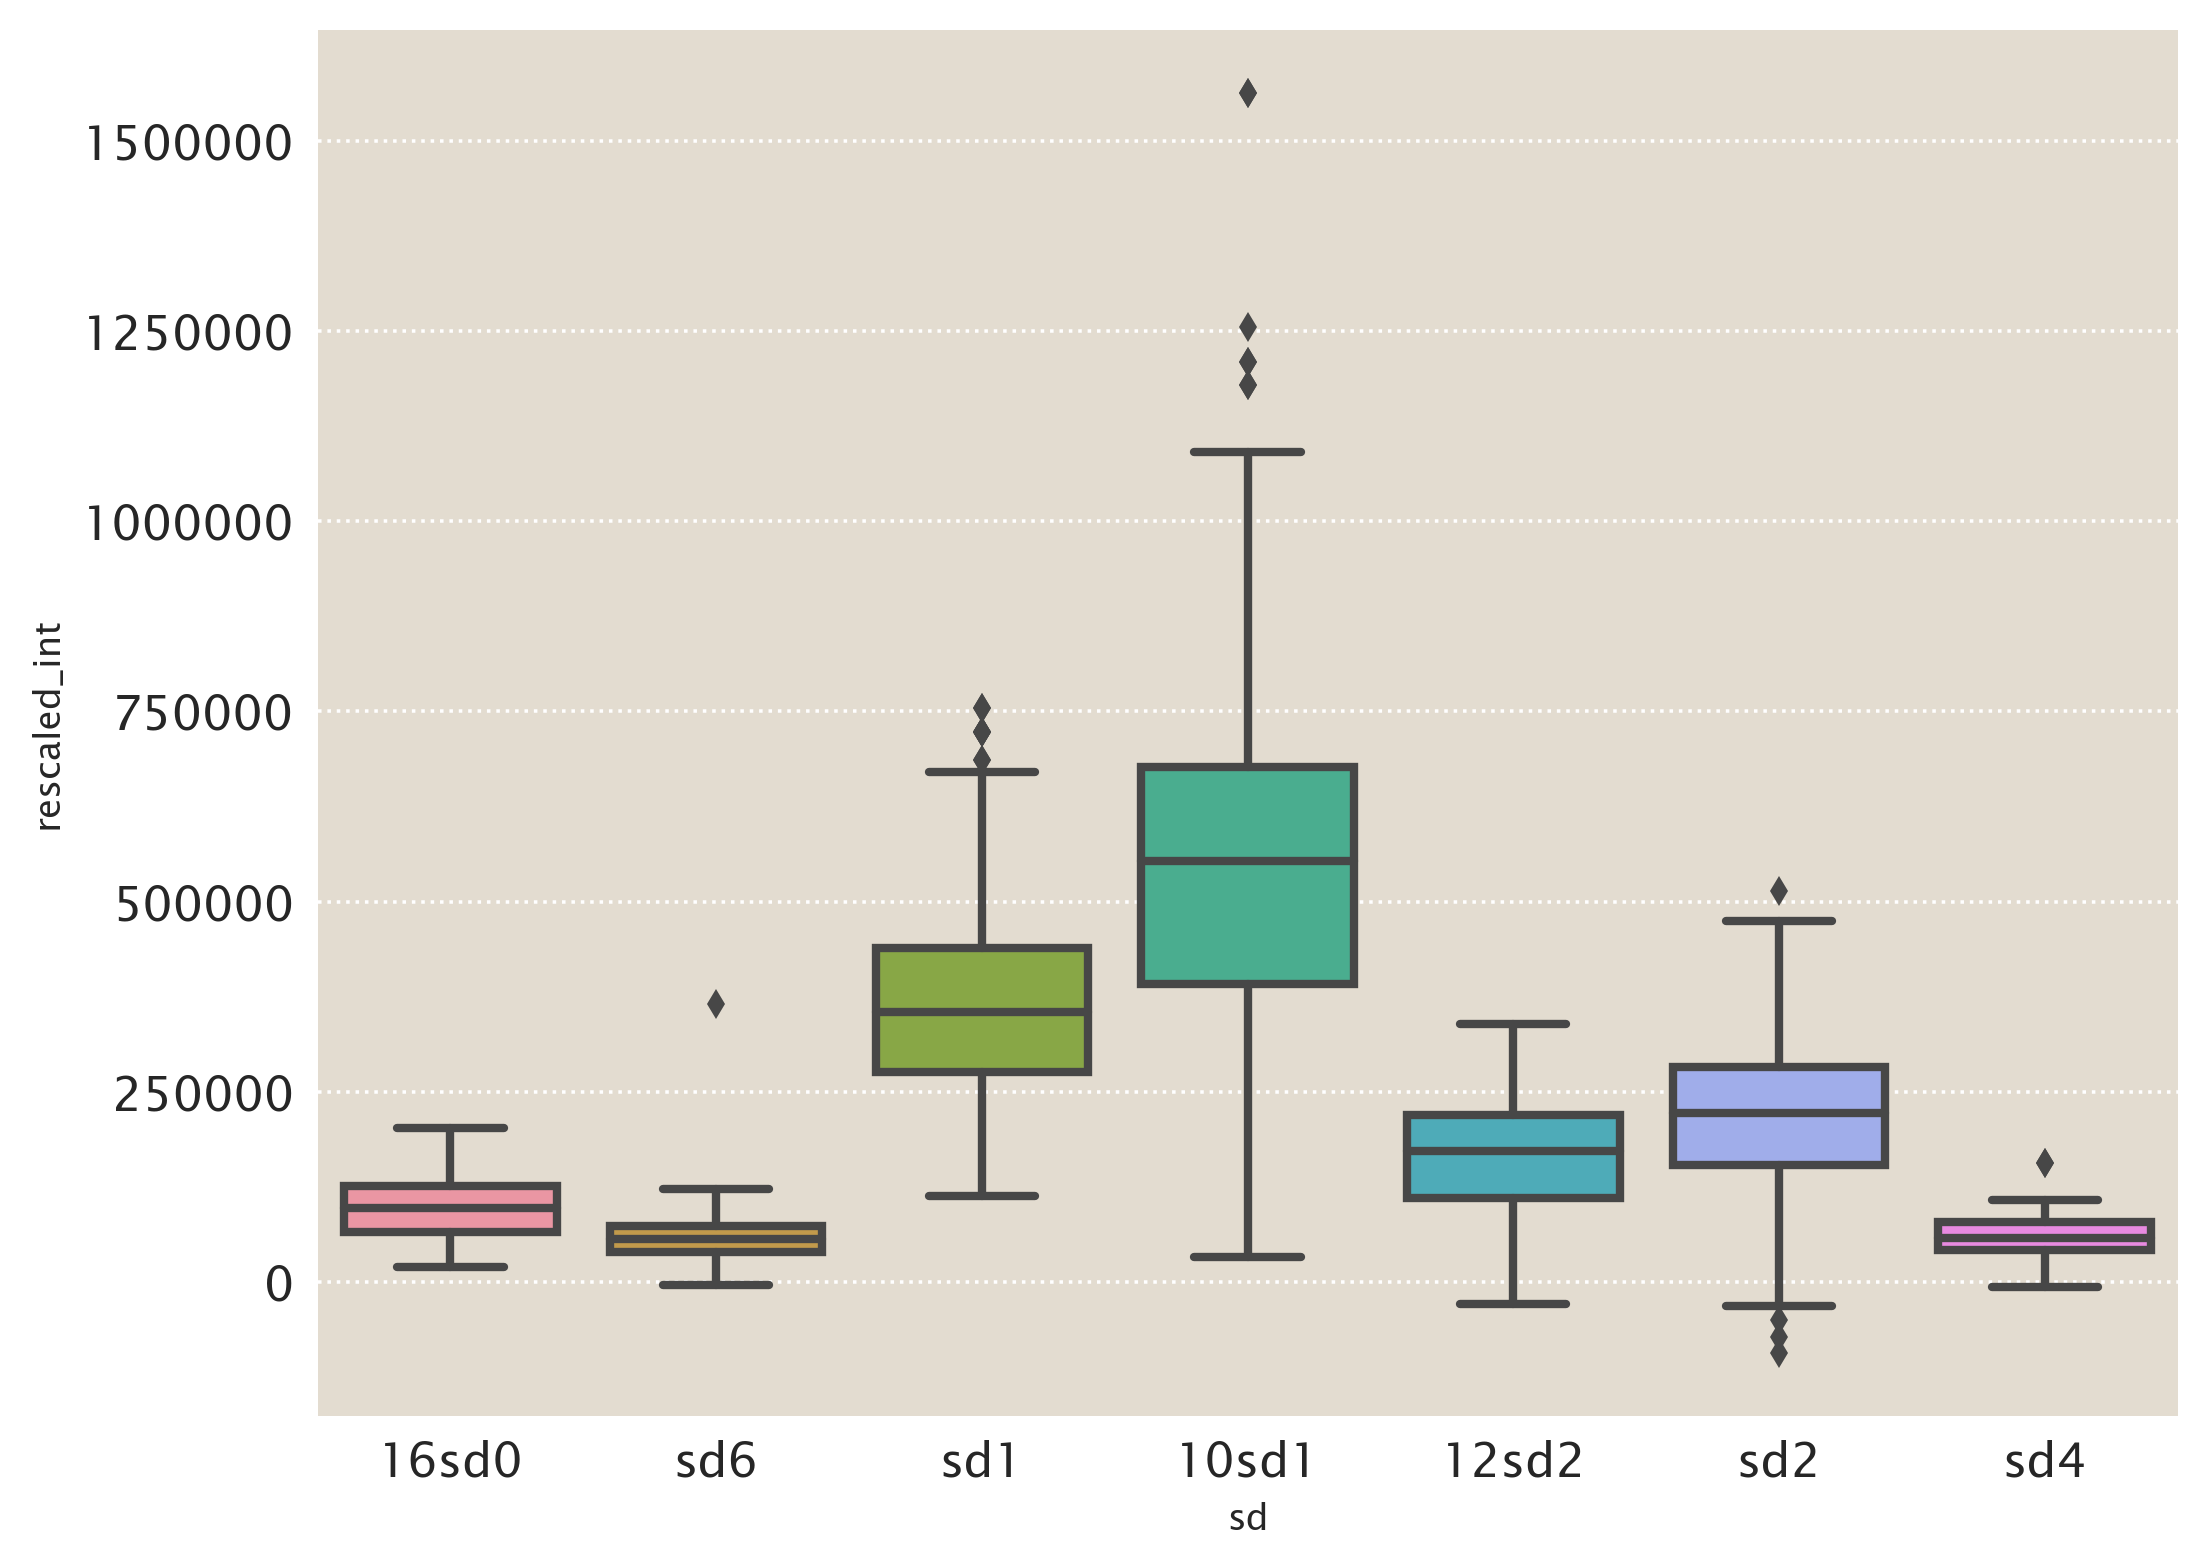

In [39]:
# Compute the relative intensities.
# sd0_scaled = SDdata[SDdata['sd']=='sd0']['sub_intensity'] * 2

# sd0_mean = np.mean(sd0_scaled)
sd0_mean = 1
print(sd0_mean)
# data['rel_int'] = data['rescaled_int'] / sd0_mean
# data['num_chan'] = data['rel_int'] * 300
sns.boxplot(x='sd', y='rescaled_int', data=data)

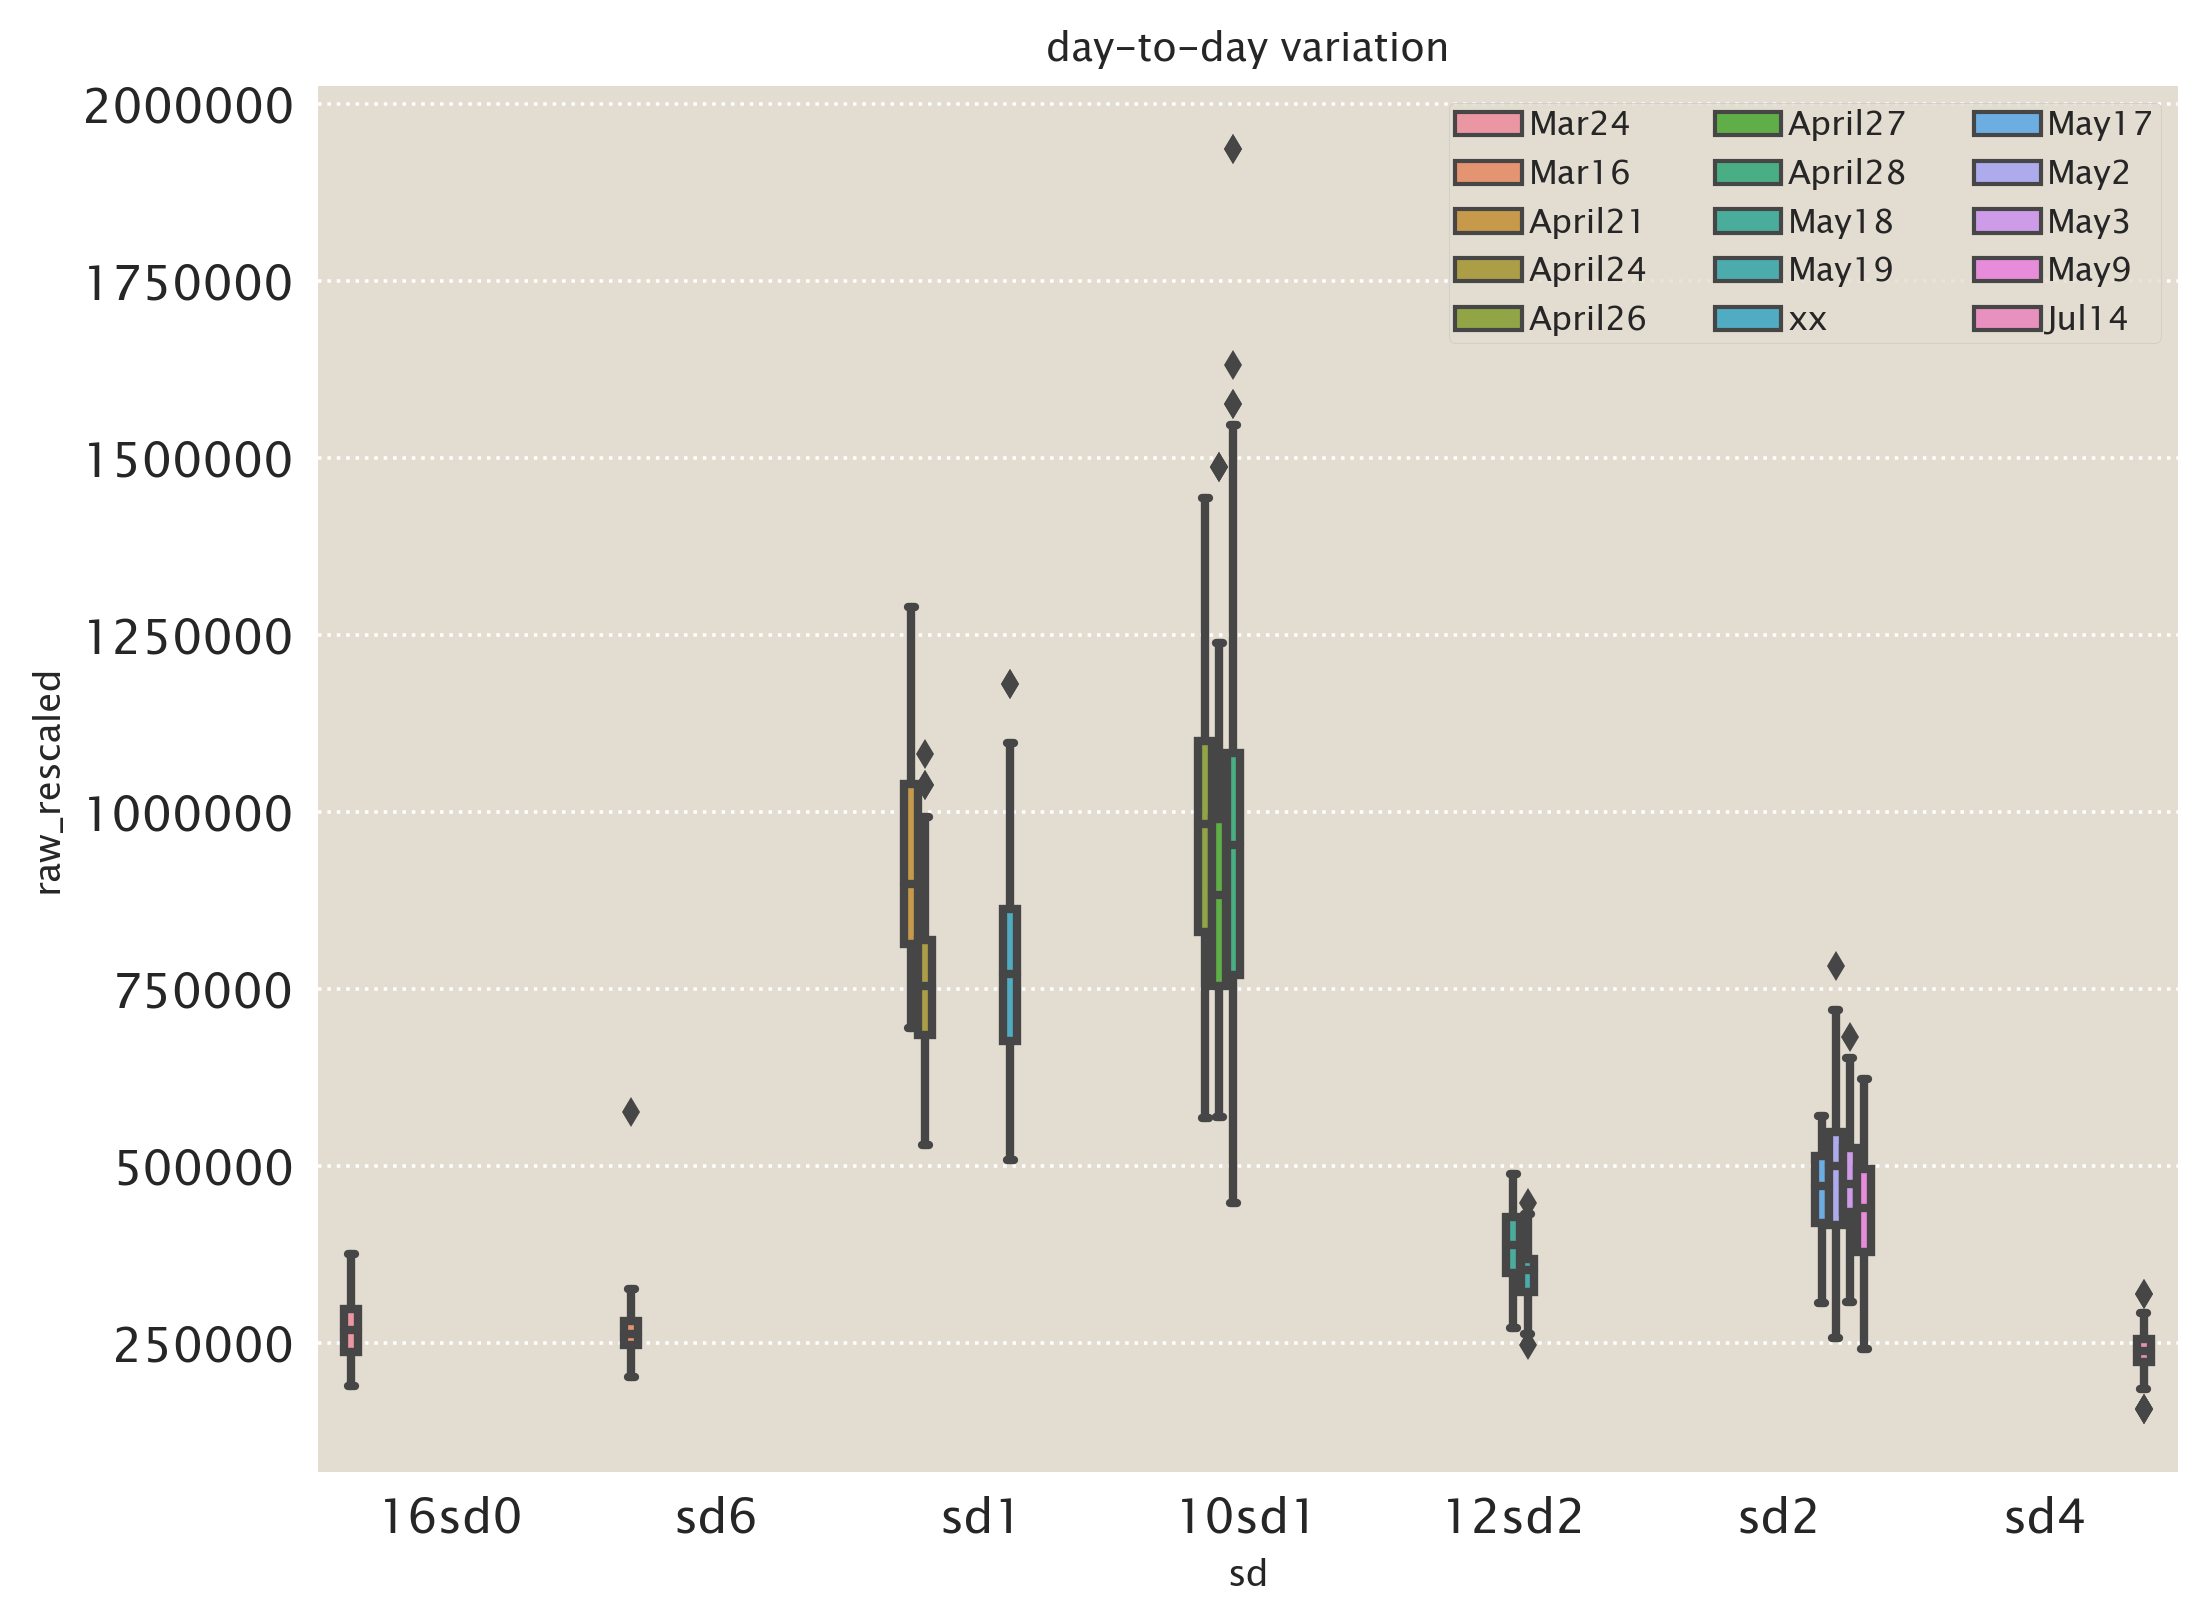

In [36]:
sns.boxplot(x='sd', y='raw_rescaled', hue='date', data=data)
plt.legend(ncol=3)
plt.title('day-to-day variation')

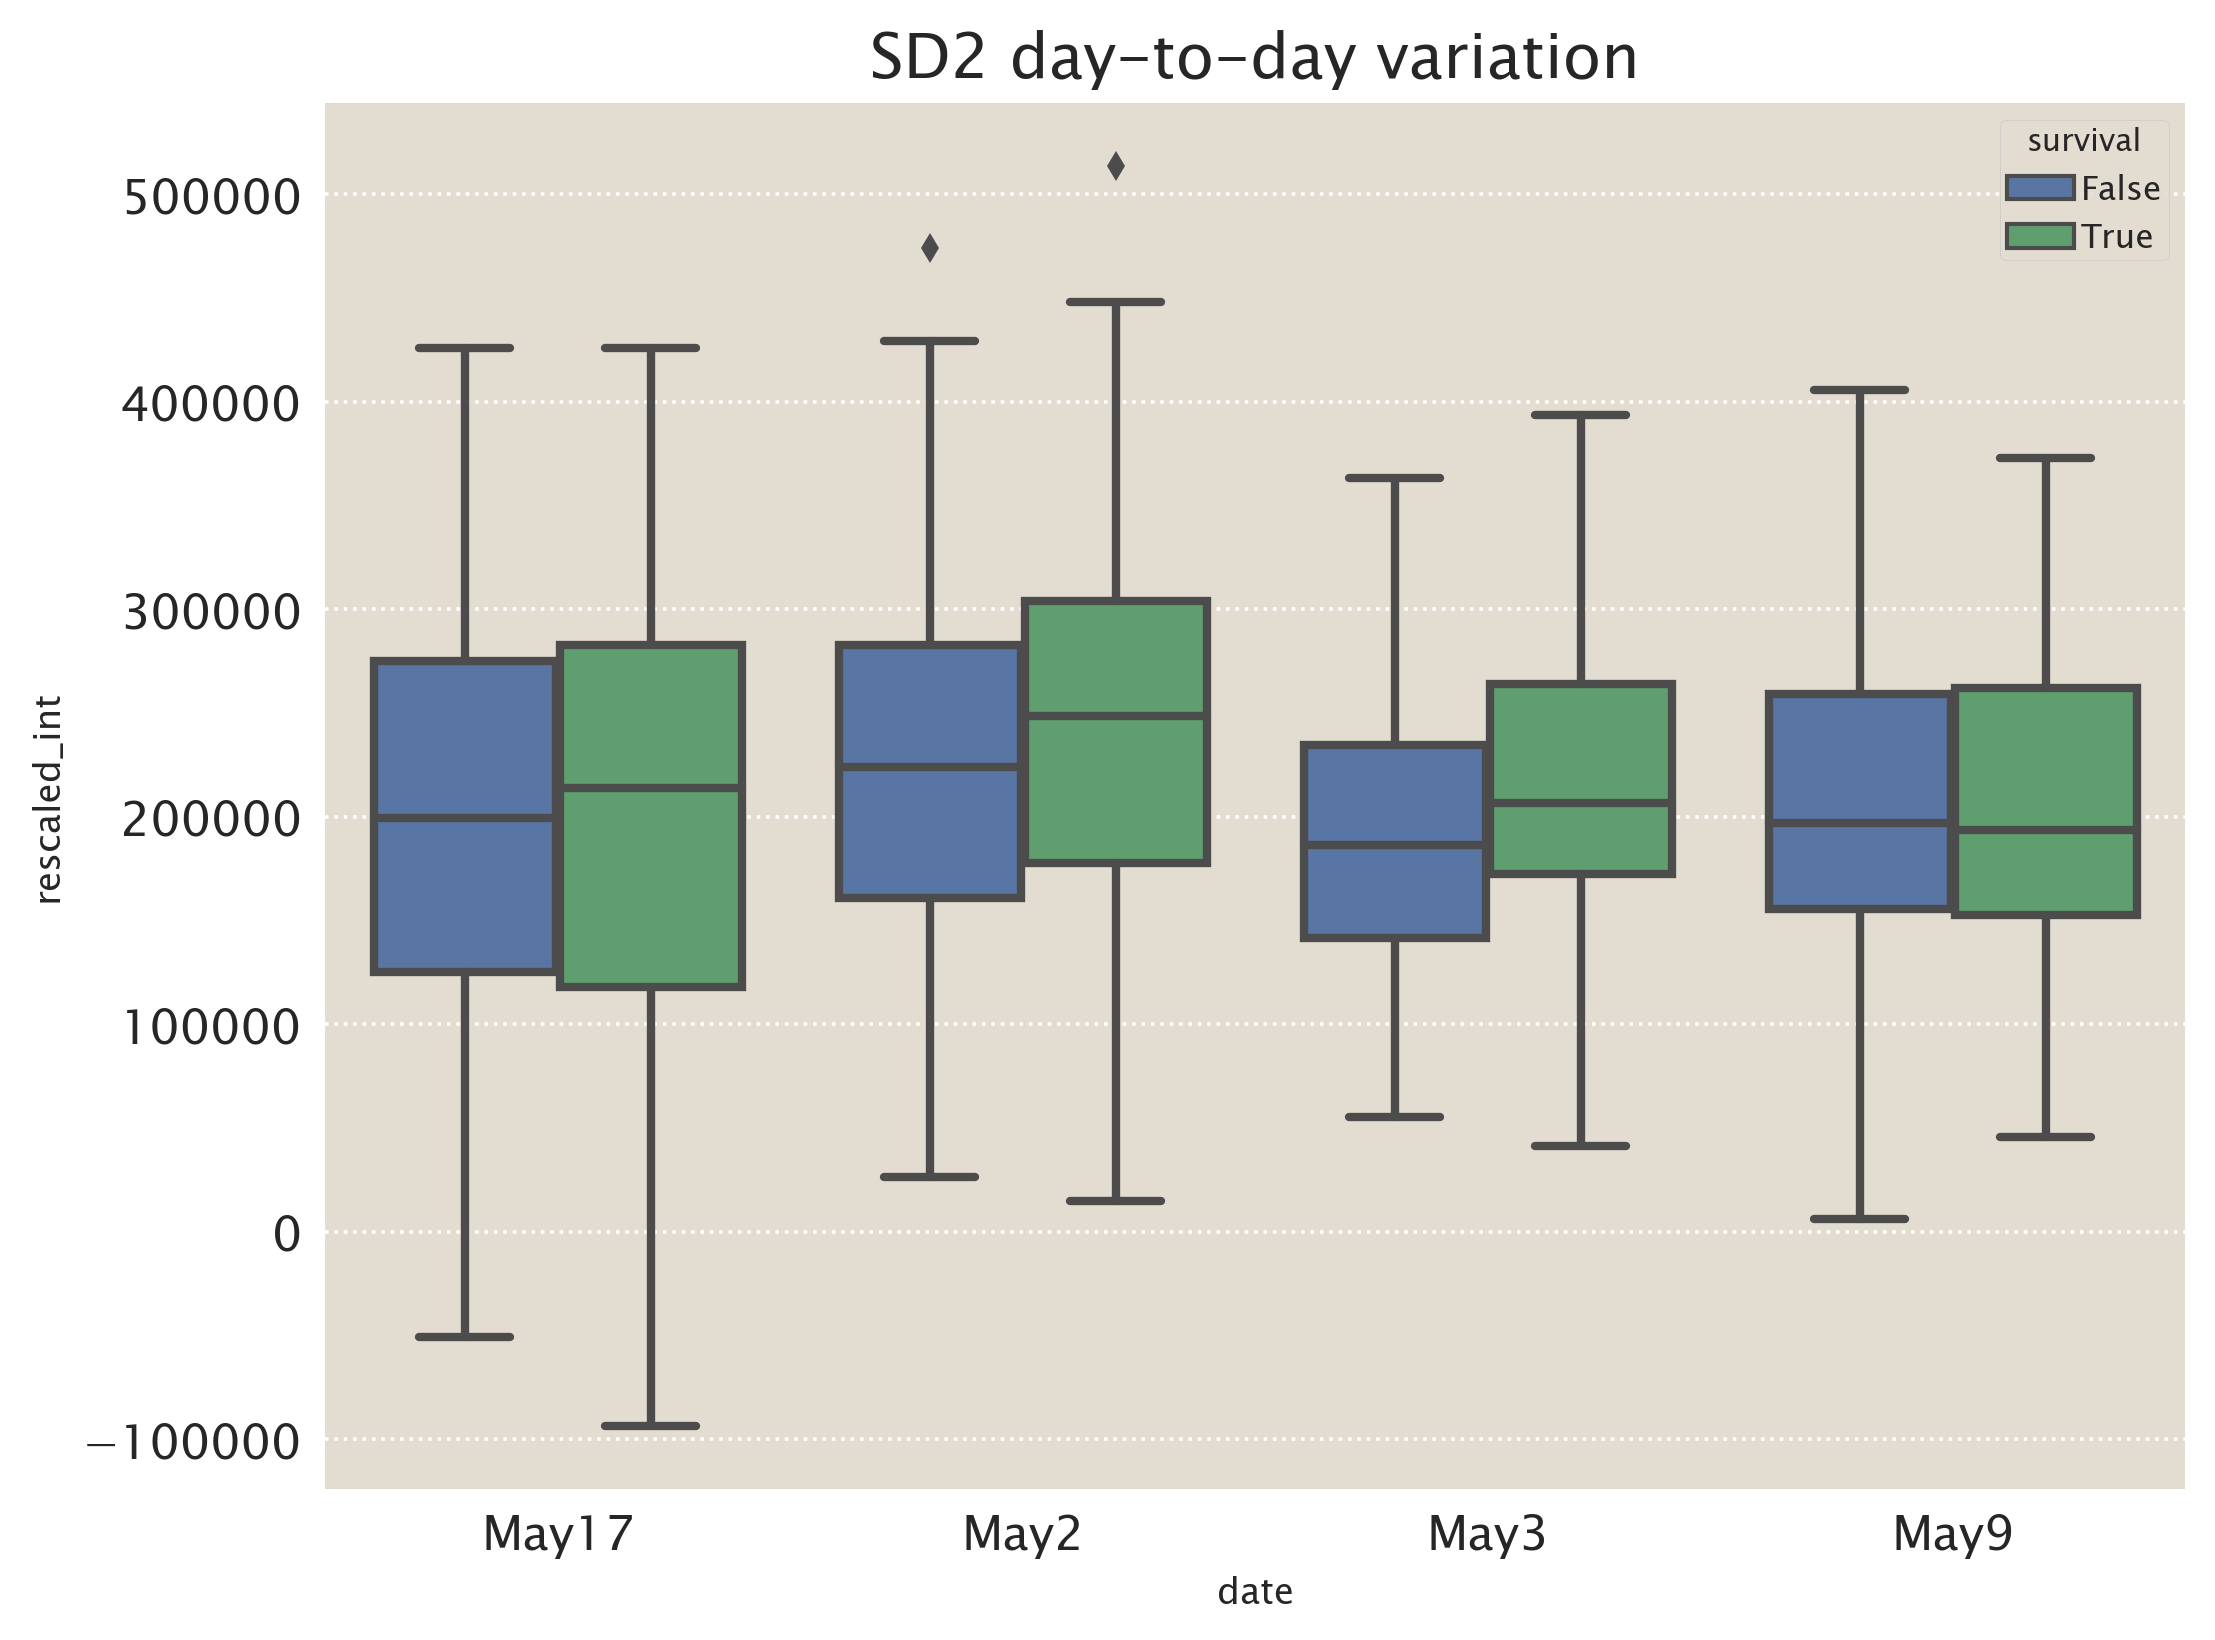

In [40]:
sns.boxplot(x='date', y='rescaled_int',hue='survival', 
            data=data[data['sd'] == 'sd2'])
plt.title('SD2 day-to-day variation', fontsize=15)

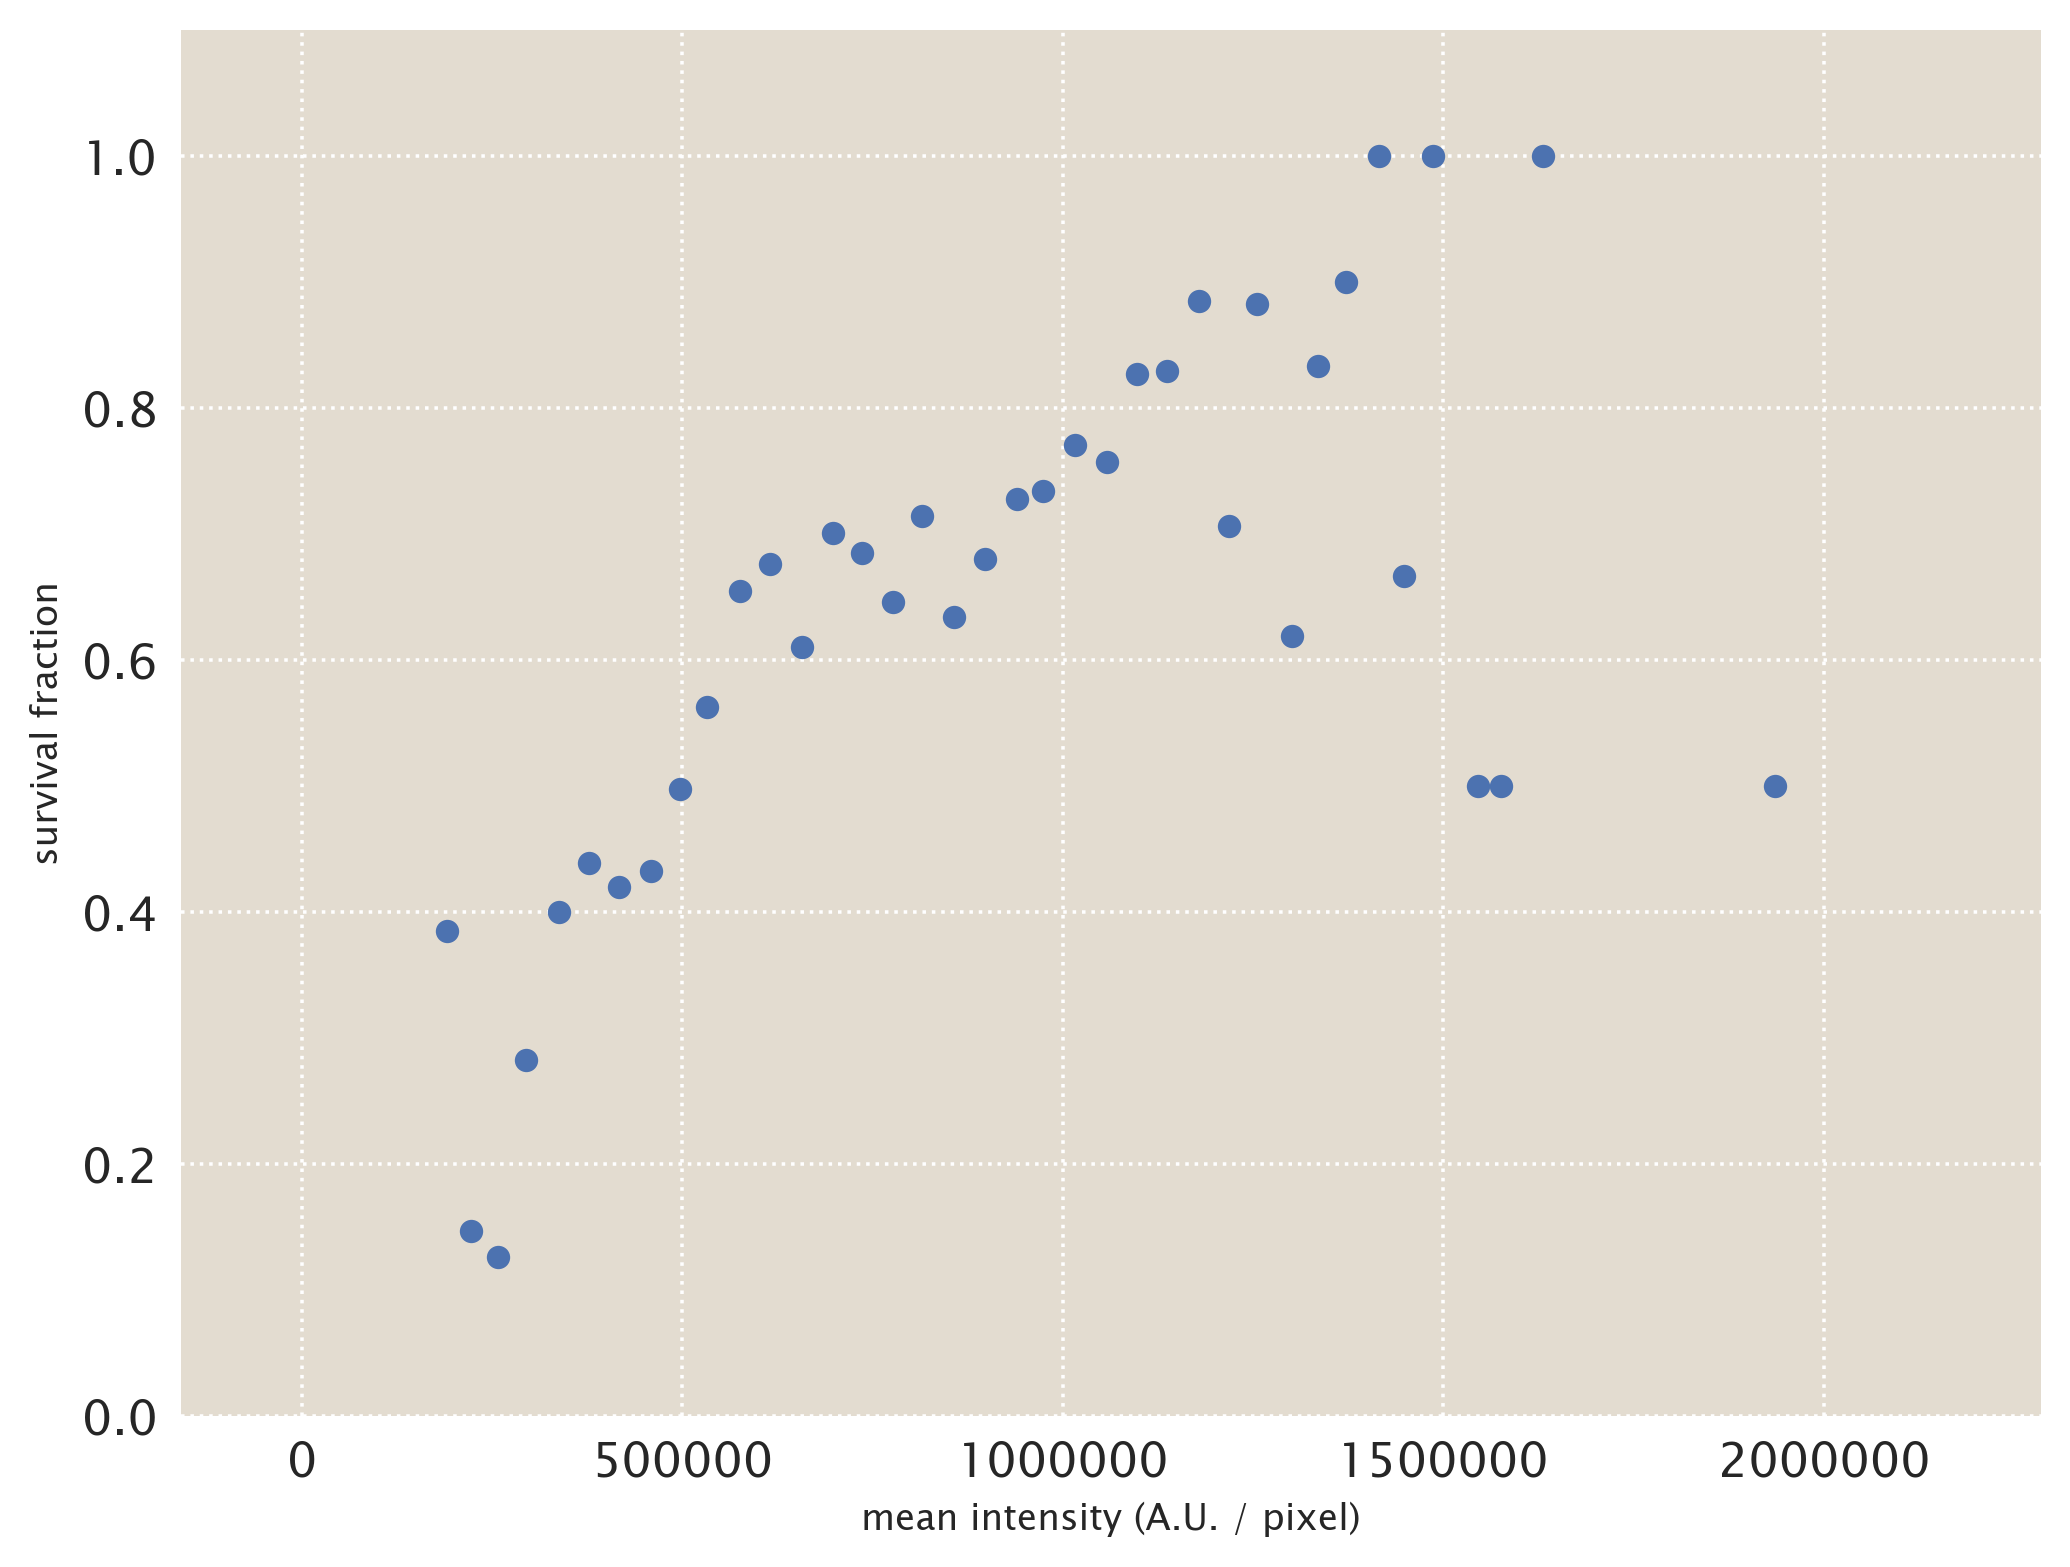

In [38]:
bin_width =  4E4

# Convert to mean pixel value. 
bins = np.arange(data['raw_rescaled'].min(), 
                  data['raw_rescaled'].max(), bin_width)
mean_ints = []
num_events = []
survival_frac = []
for i in range(len(bins) - 1):
    if (data['raw_rescaled'].max() - bins[i+1]) < bin_width:
        upper = data['raw_rescaled'].max()
    else:
        upper = bins[i + 1]
    sel_data = data[(data['raw_rescaled'] > bins[i]) &
                             (data['raw_rescaled'] <= upper)]
    if len(sel_data) > 0:
        mean_ints.append(sel_data['raw_rescaled'].mean())
        survival_frac.append(np.sum(sel_data['survival']) / len(sel_data))
        num_events.append(len(sel_data))
#         print(num_events)

plt.plot(mean_ints, survival_frac, 'o')

plt.xlabel('mean intensity (A.U. / pixel)')
plt.ylabel('survival fraction')
plt.ylim([0, 1.1])
plt.margins(0.2)

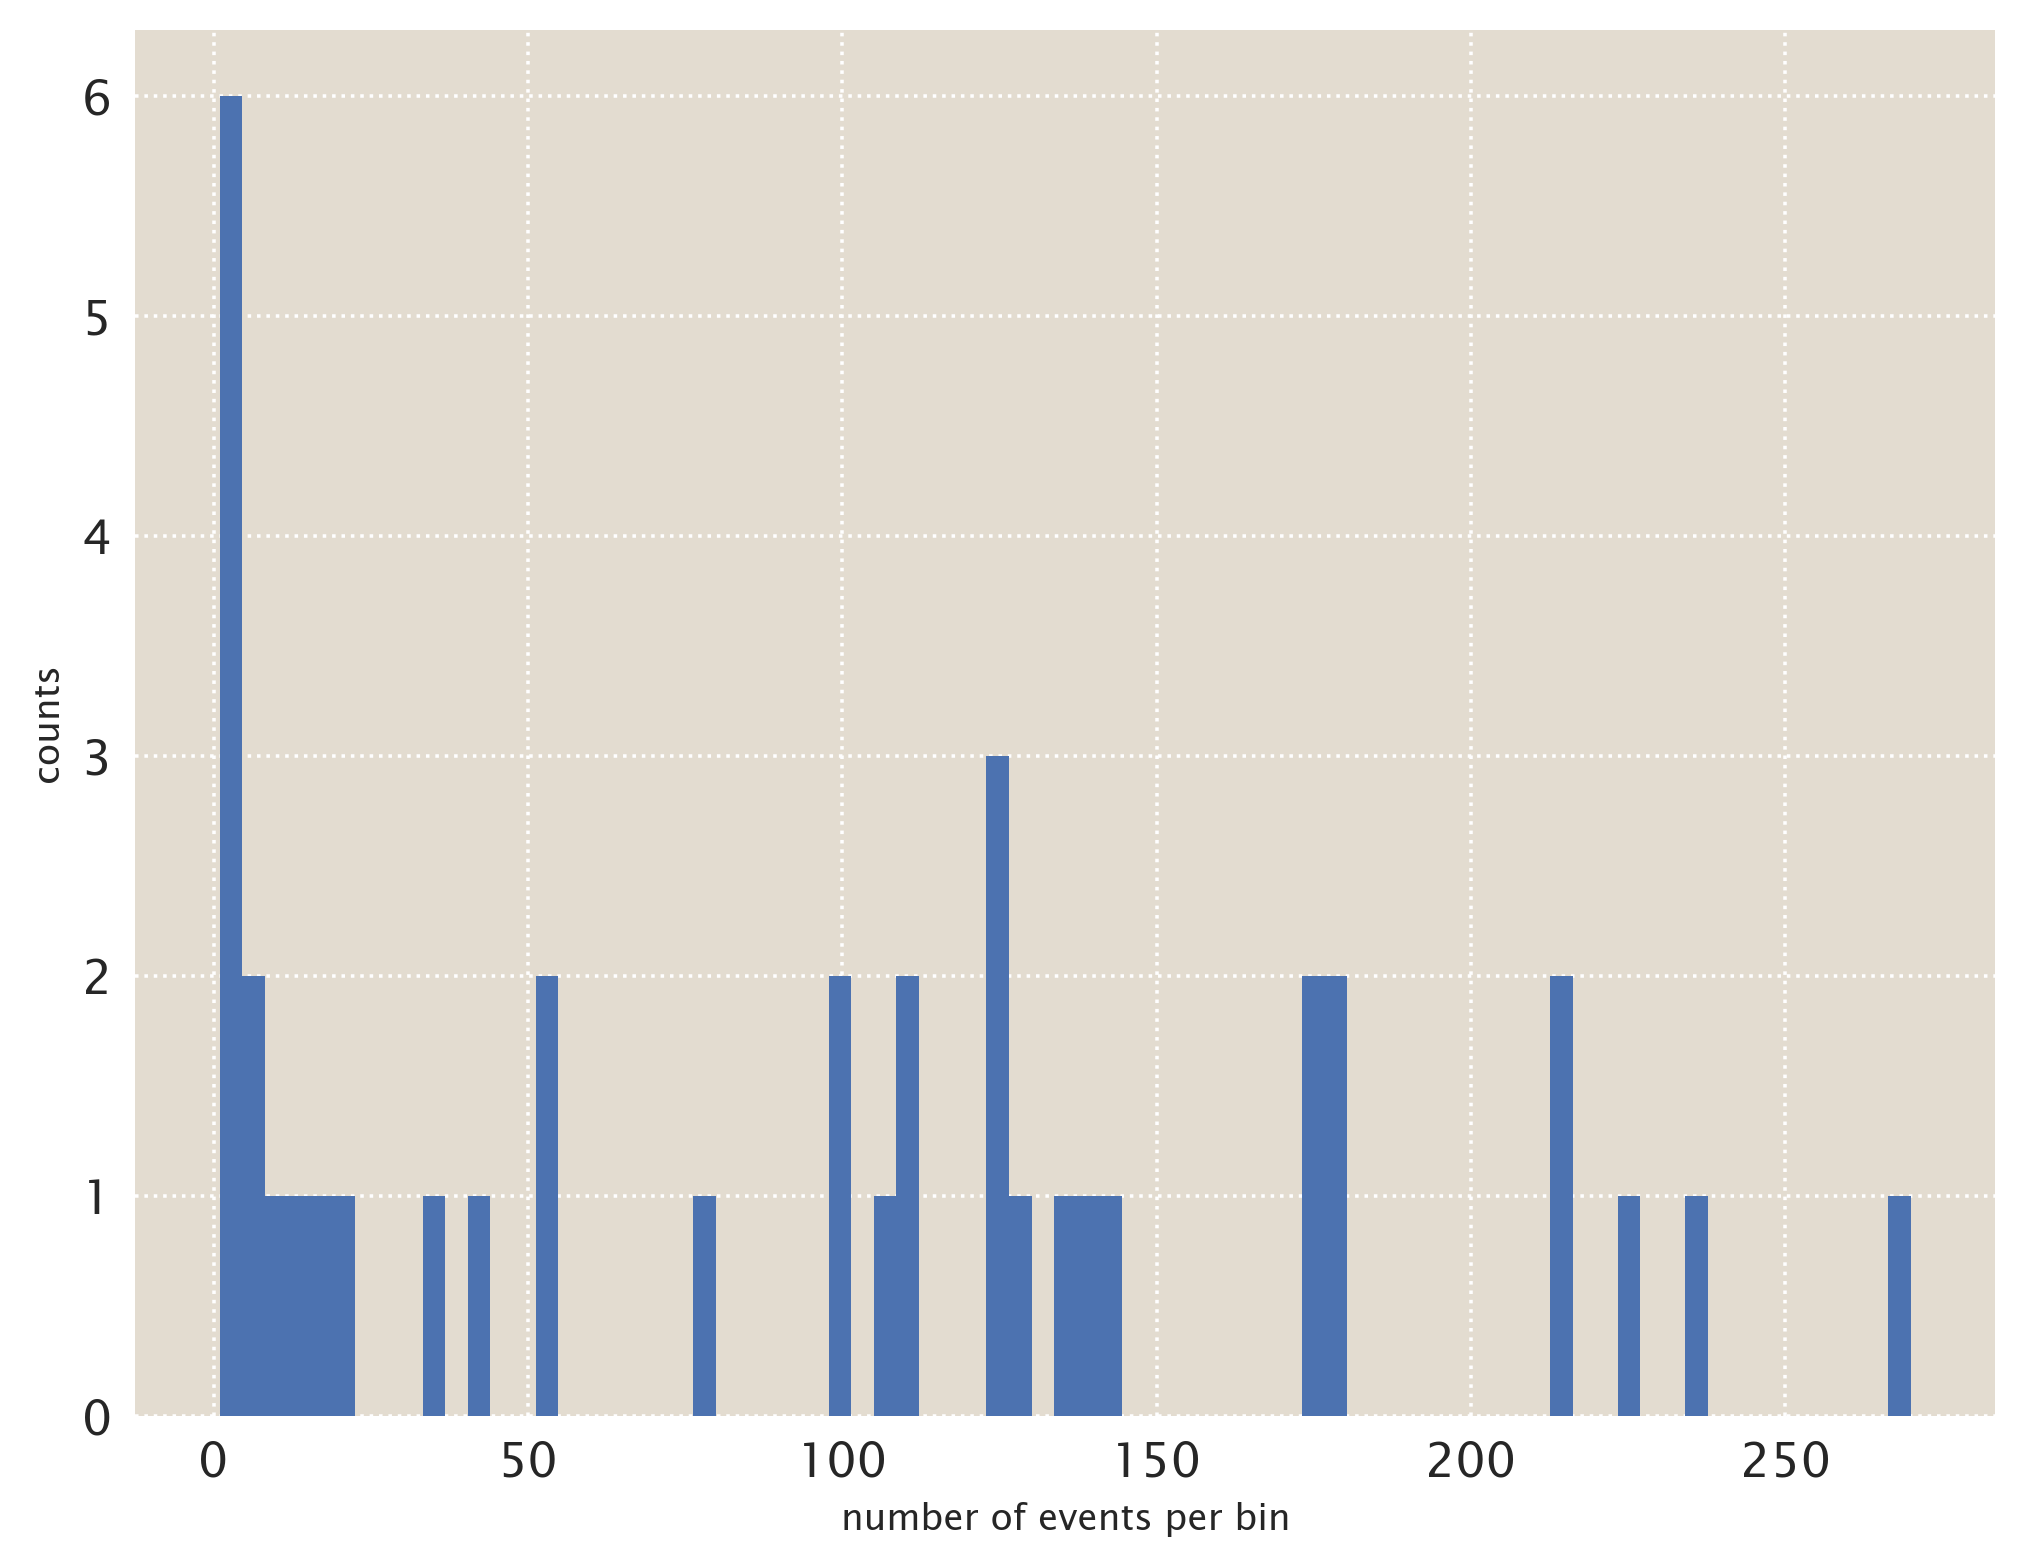

In [11]:
plt.hist(num_events, bins=75)
plt.xlabel('number of events per bin')
plt.ylabel('counts')

3660

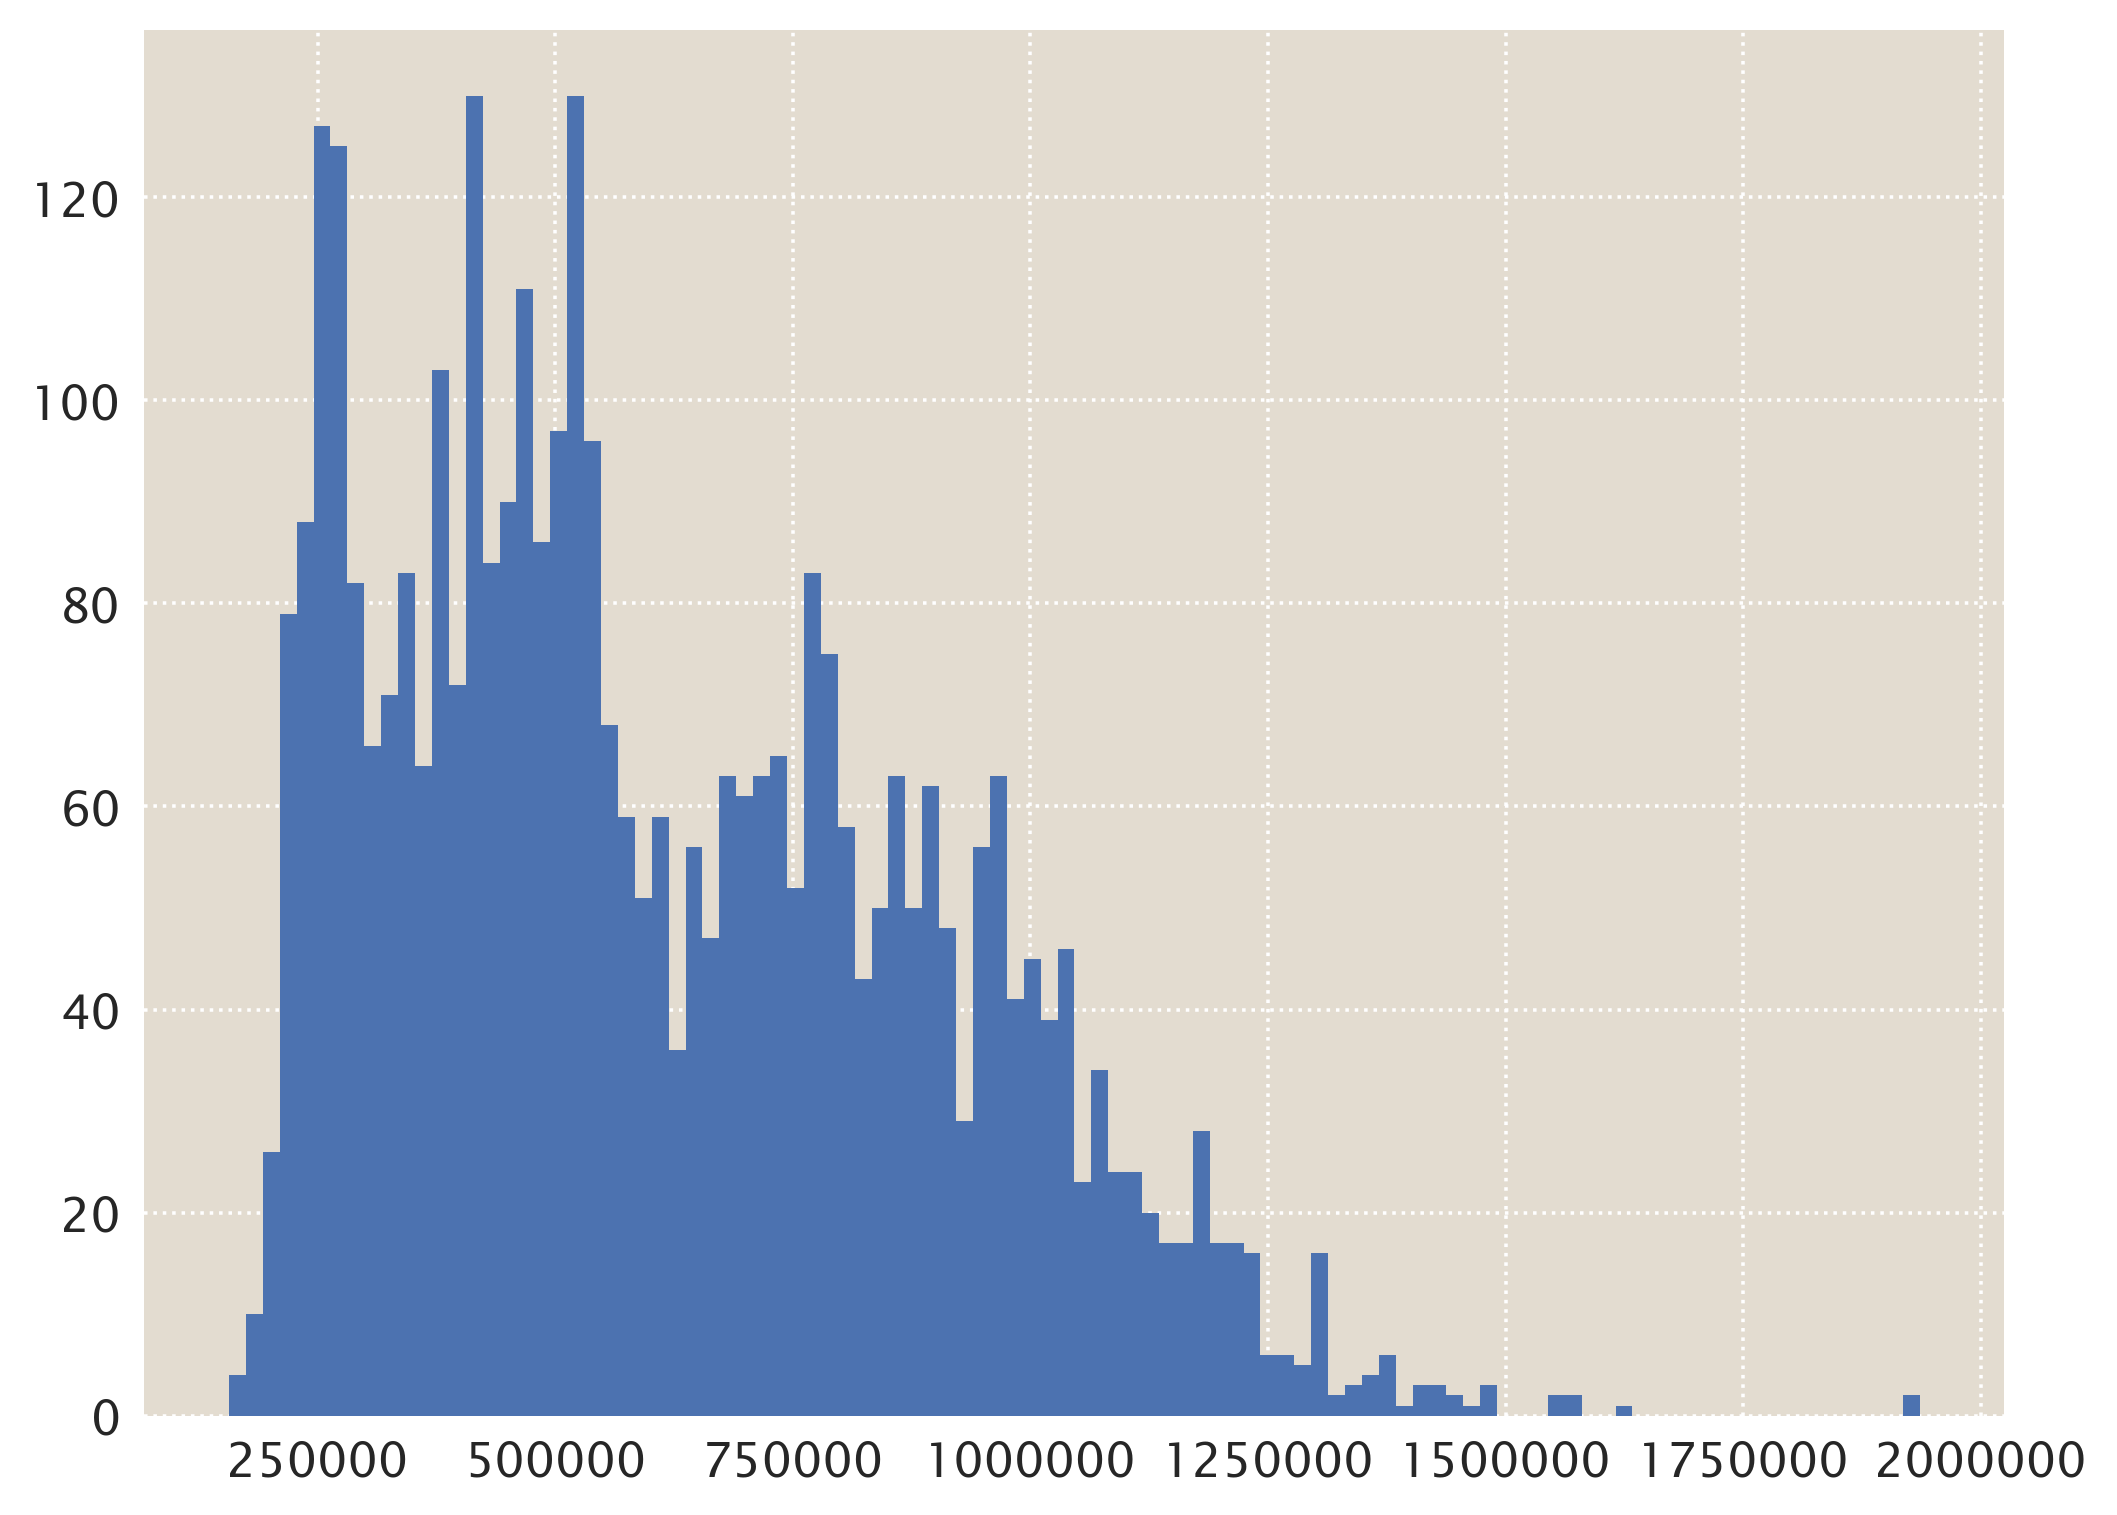

In [12]:
# Plot a histogram of the intensities with 
n, b, p = plt.hist(data['raw_rescaled'], bins=100)
# plt.title('binnning scheme', fontsize=15)
# plt.xlabel('mean intensity (a.u. per µm$^2$)', fontsize=15)
# plt.ylabel('counts', fontsize=15)
len(data['raw_rescaled'])

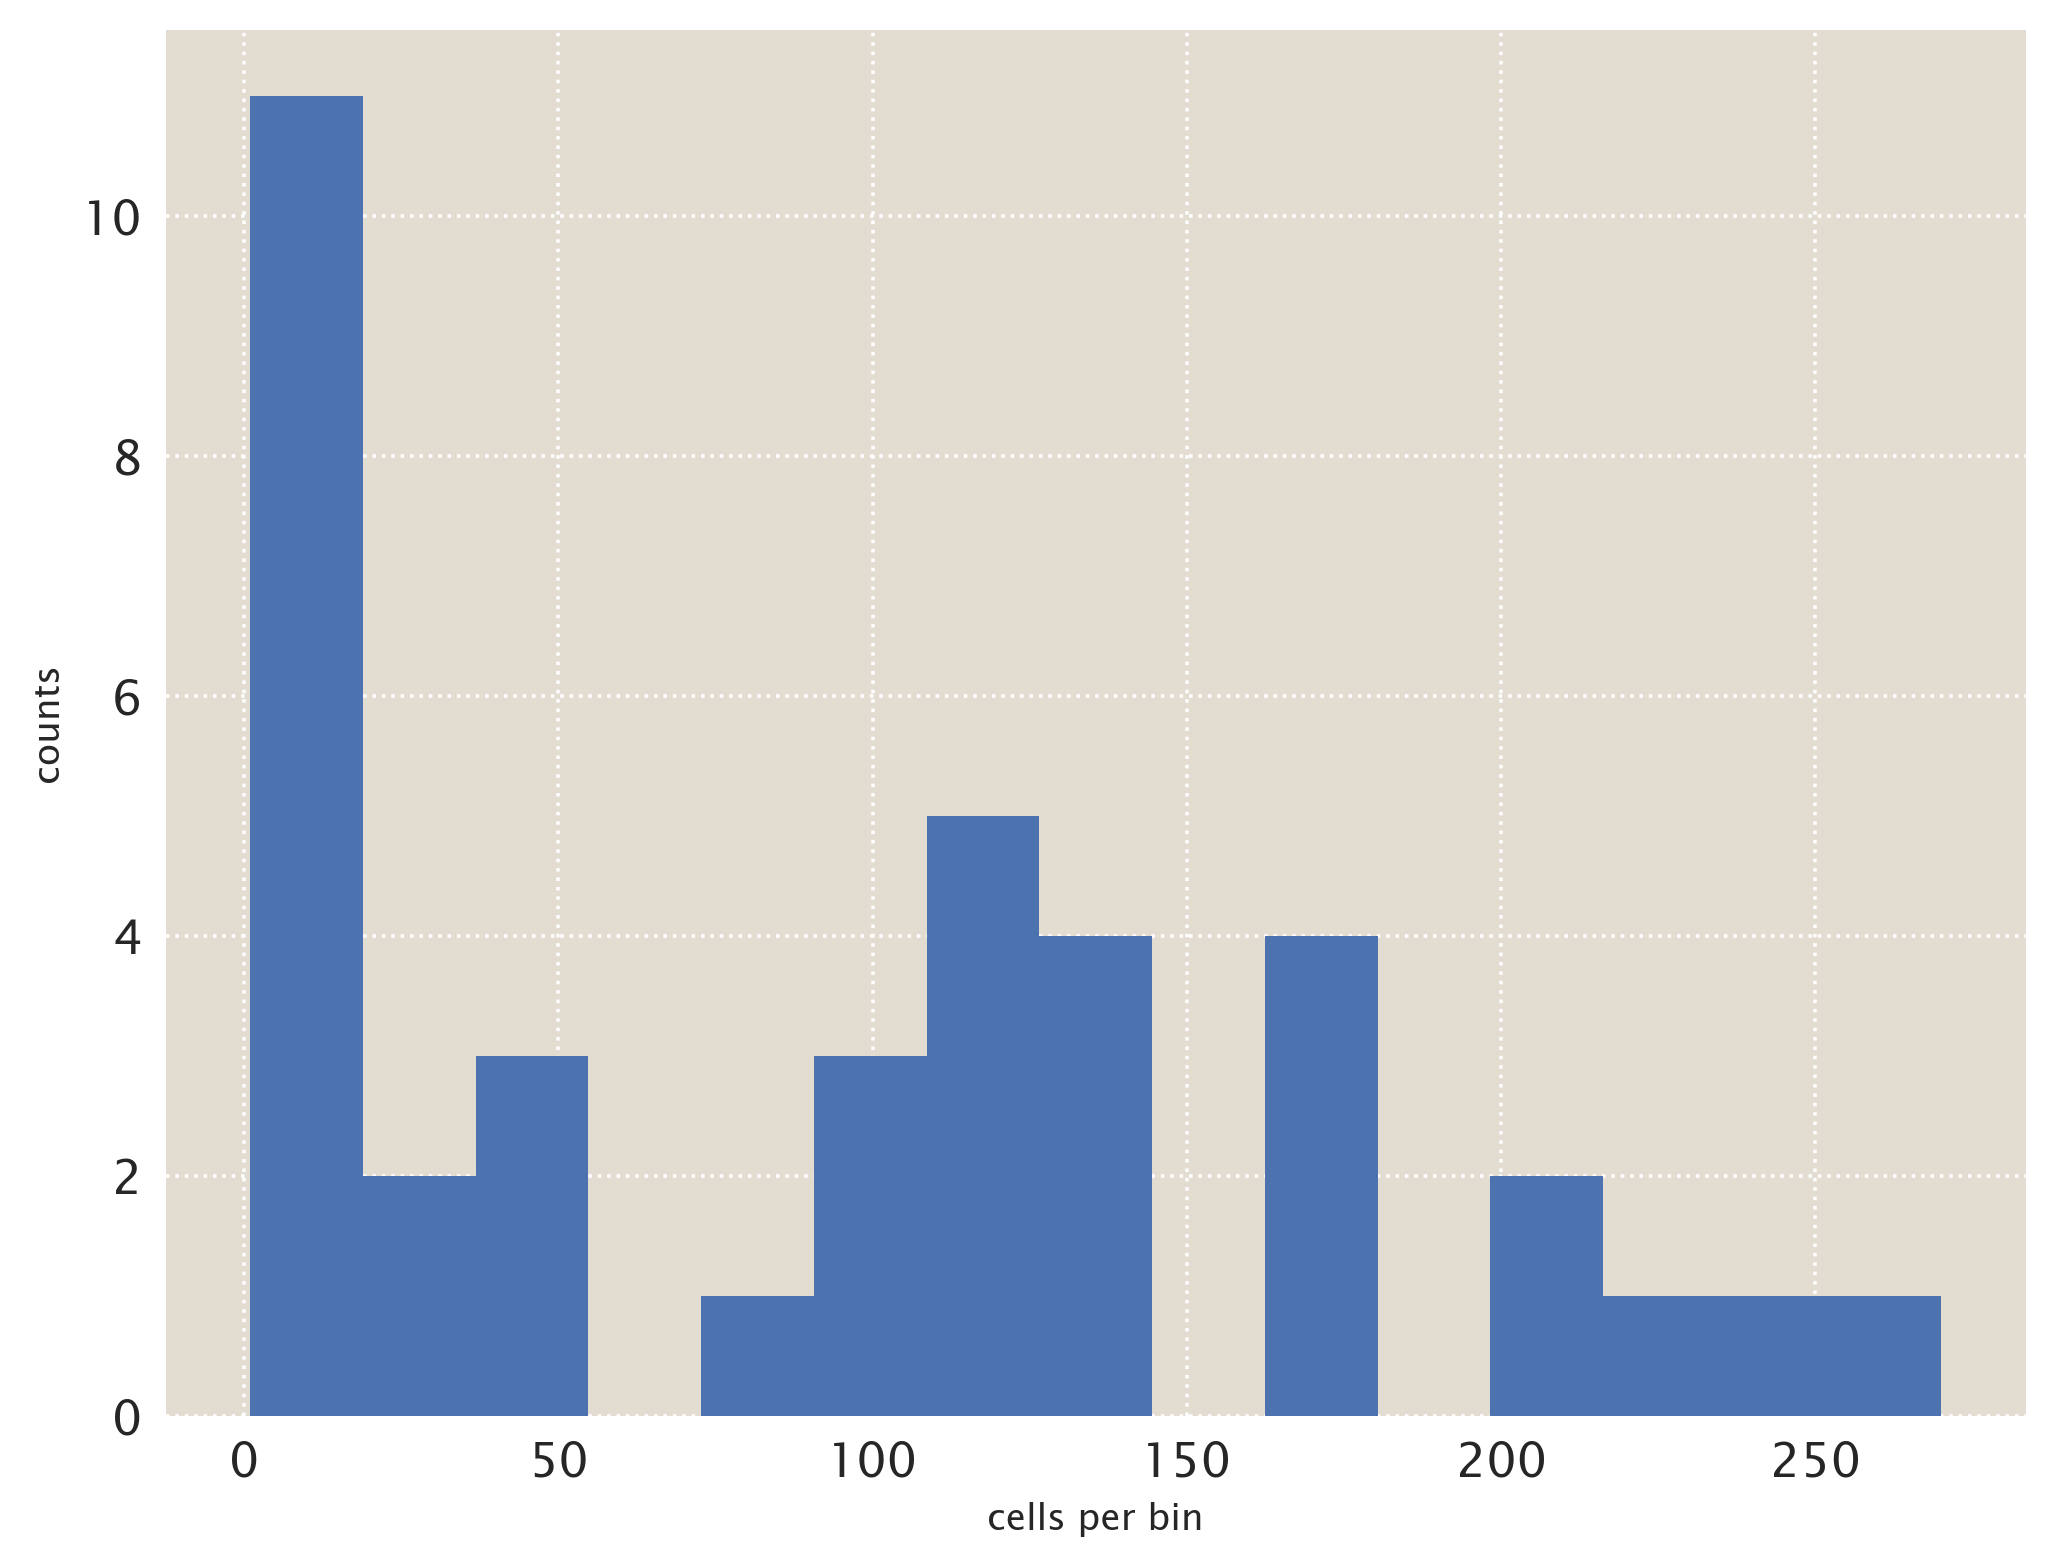

In [13]:
n,b,p = plt.hist(num_events, 15)
plt.xlabel('cells per bin')
plt.ylabel('counts')


##  Splitting by flow rate

In [18]:
def bs_sample(dist, rep=int(1E5)):
    fracs = []
    for i in range(rep):
        samp = np.random.choice(dist, len(dist), replace=True)
        fracs.append(np.sum(samp) / len(samp))
    perc_upper =  np.percentile(fracs, 97.5)
    perc_lower = np.percentile(fracs, 2.5)
    return np.mean(fracs), (perc_upper, perc_lower)

1889
198
1771
284 4012.77240143
270 7012.77240143
284 10012.7724014
283 13012.7724014
167 16012.7724014
181 19012.7724014
183 22012.7724014
129 25012.7724014
69 28012.7724014
24 31012.7724014
11 34012.7724014
3 37012.7724014
slow shock : [284, 270, 284, 283, 167, 181, 183, 129, 69, 38]
118 4012.77240143
265 7012.77240143
346 10012.7724014
221 13012.7724014
207 16012.7724014
211 19012.7724014
163 22012.7724014
113 25012.7724014
63 28012.7724014
42 31012.7724014
14 34012.7724014
3 37012.7724014
3 40012.7724014
2 46012.7724014
fast shock : [118, 265, 346, 221, 207, 211, 163, 113, 63, 64]


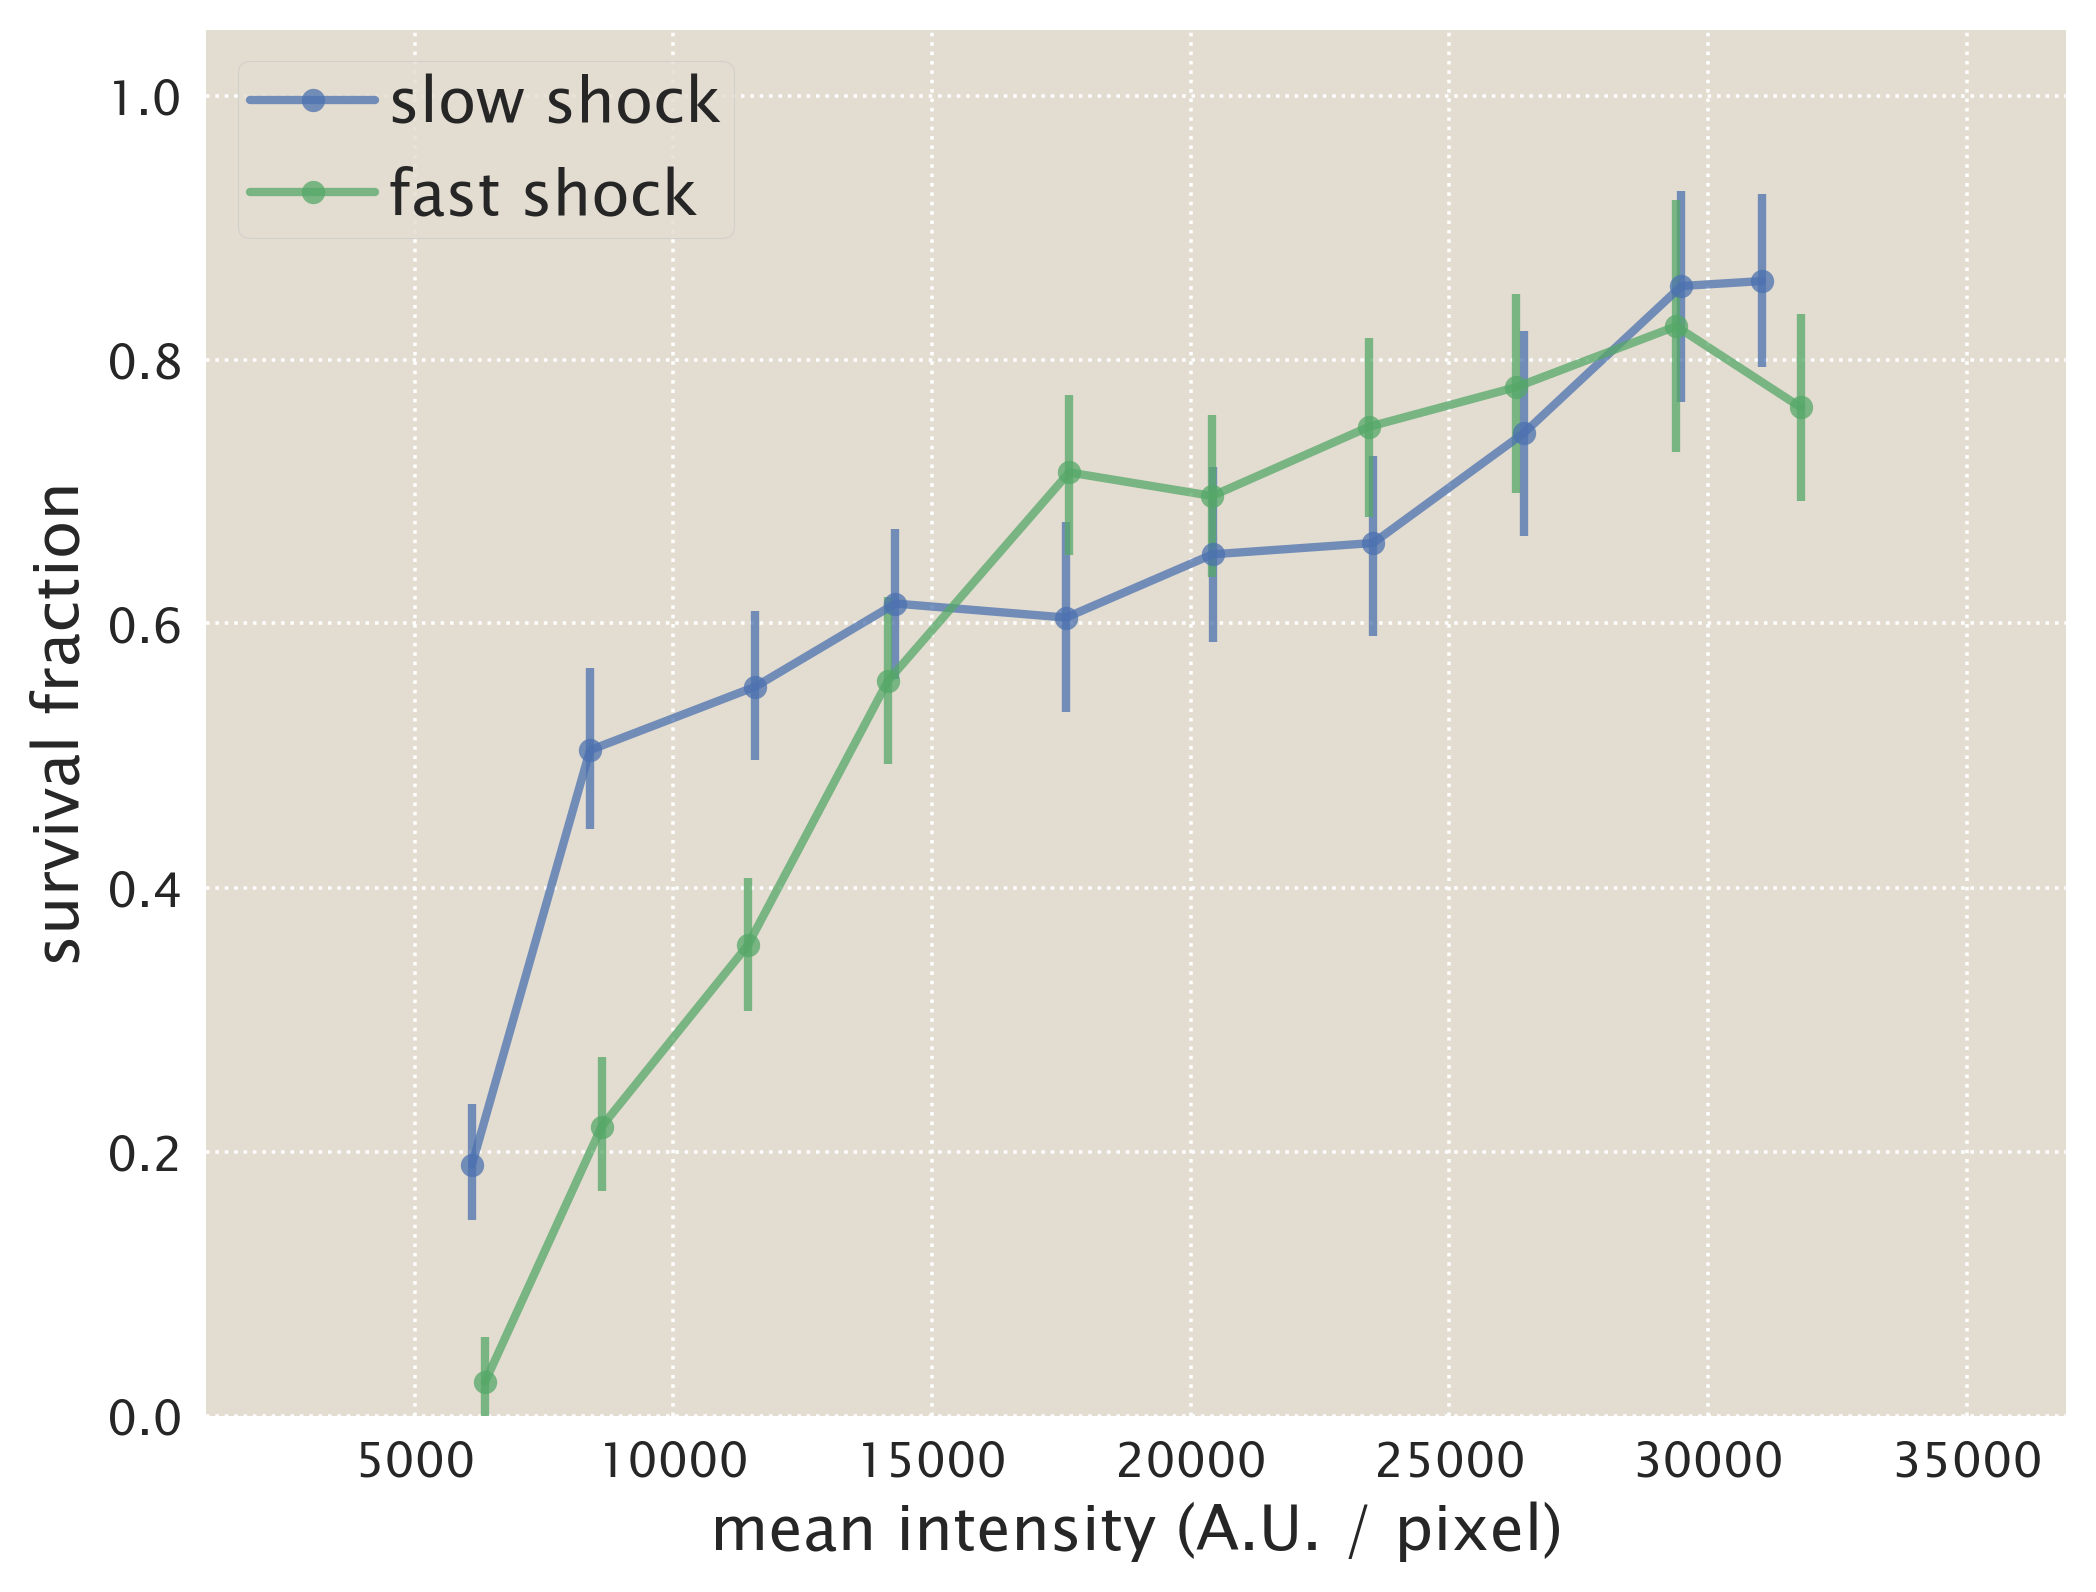

In [19]:
ip_dist = 0.16
data2 = data
grouped = data2.groupby('flow_rate')
rate_groups = [0.1, 0.75, 2.25]
dfs = [[], [], []]
for g, d in grouped:
    if g < 1.0:
        dfs[0].append(d)

#     elif (g == '0.71Hz'):
#         dfs[1].append(d)
    else:

        dfs[2].append(d)
dfs[1].append(d)
# Combine in to individual dfs.
rates = []
for i, _ in enumerate(dfs):
    rates.append(pd.concat(dfs[i]))
    print(len(rates[i]))
    
    
# Bin each set and plot the survival probability. 
bin_width = 3E3 
# fracs = [] 

bins = np.arange((data2['raw_rescaled'] * ip_dist**2).min(), 
                  (data2['raw_rescaled'] * ip_dist**2).max(), bin_width)
# labels = ['0.005 - 0.02 Hz', '0.2 - 0.71Hz', '~2Hz']
labels = ['slow shock', 'fast shock']
rates = [rates[0], rates[2]]
min_cells = 20 
colors = sns.color_palette('deep')
bin_edges = [[], []]
for j, _ in enumerate(rates):

    rate_data2 = rates[j]
    rate_data2['raw_rescaled'] *= ip_dist**2
#     bins = np.arange(rate_data2['raw_rescaled'].min(), 
#                   rate_data2['raw_rescaled'].max(), bin_width)
    mean_ints = []
    ints = []
    fates = []
    num_events = []
    survival_frac = []
    bs_lower = []
    bs_upper = []

    for i in range(len(bins) - 1):
        if (rate_data2['raw_rescaled'].max() - bins[i+1]) < bin_width:
            upper = rate_data2['raw_rescaled'].max()
        else:
            upper = bins[i + 1]
        sel_data2 = rate_data2[(rate_data2['raw_rescaled'] > bins[i]) &
                             (rate_data2['raw_rescaled'] <= upper)]
        if len(sel_data2) > 0: 
            _ints = sel_data2['raw_rescaled'].values
            _fates = sel_data2['survival'].values
            event_no = len(sel_data2)

            print(event_no, bins[i])
            if event_no < min_cells:
                ints[-1] = np.concatenate((ints[-1], _ints))
                fates[-1] = np.concatenate((fates[-1], _fates)) 
                num_events[-1] = len(ints[-1])
                mean_int_val = np.mean(np.concatenate((ints[-1], ints[-2])))
                mean_ints[-1] = mean_int_val
                bs_mean, bs_perc = bs_sample(np.concatenate((fates[-1], fates[-2])),\
                                            rep=10000)
                survival_frac[-1] = bs_mean
                bs_lower[-1] = bs_perc[1]
                bs_upper[-1] = bs_perc[0]

            else:
                latest_edge = bins[i]
                bin_edges[j].append(latest_edge)
                ints.append(_ints)
                fates.append(_fates)
                mean_int_val = sel_data2['raw_rescaled'].mean()
                bs_mean, bs_perc = bs_sample(sel_data2['survival'], rep=10000)
                mean_ints.append(mean_int_val)
                survival_frac.append(bs_mean)
                bs_lower.append(bs_perc[1])
                bs_upper.append(bs_perc[0])
                num_events.append(len(sel_data2))


    plt.plot(mean_ints, survival_frac,'-o', color=colors[j], label=labels[j], alpha=0.75)
    plt.vlines(mean_ints, bs_lower, bs_upper, color=colors[j], label='__nolegend__', alpha=0.75)
    print(labels[j] + ' : ' + str(num_events))
   
# plt.xlabel('num channels')
plt.xlabel('mean intensity (A.U. / pixel)', fontsize=15)
plt.ylabel('survival fraction', fontsize=15)
plt.legend(fontsize=15, loc='upper left')
plt.ylim([0, 1.05])
plt.margins(0.2)

In [20]:
def ecdf(data):
    return np.sort(data), np.arange(0, len(data)) / len(data)

In [21]:
bin_edges

[[4012.7724014336909,
  7012.7724014336909,
  10012.772401433691,
  13012.772401433691,
  16012.772401433691,
  19012.772401433693,
  22012.772401433693,
  25012.772401433693,
  28012.772401433693,
  31012.772401433693],
 [4012.7724014336909,
  7012.7724014336909,
  10012.772401433691,
  13012.772401433691,
  16012.772401433691,
  19012.772401433693,
  22012.772401433693,
  25012.772401433693,
  28012.772401433693,
  31012.772401433693]]

1
3
5
7
9


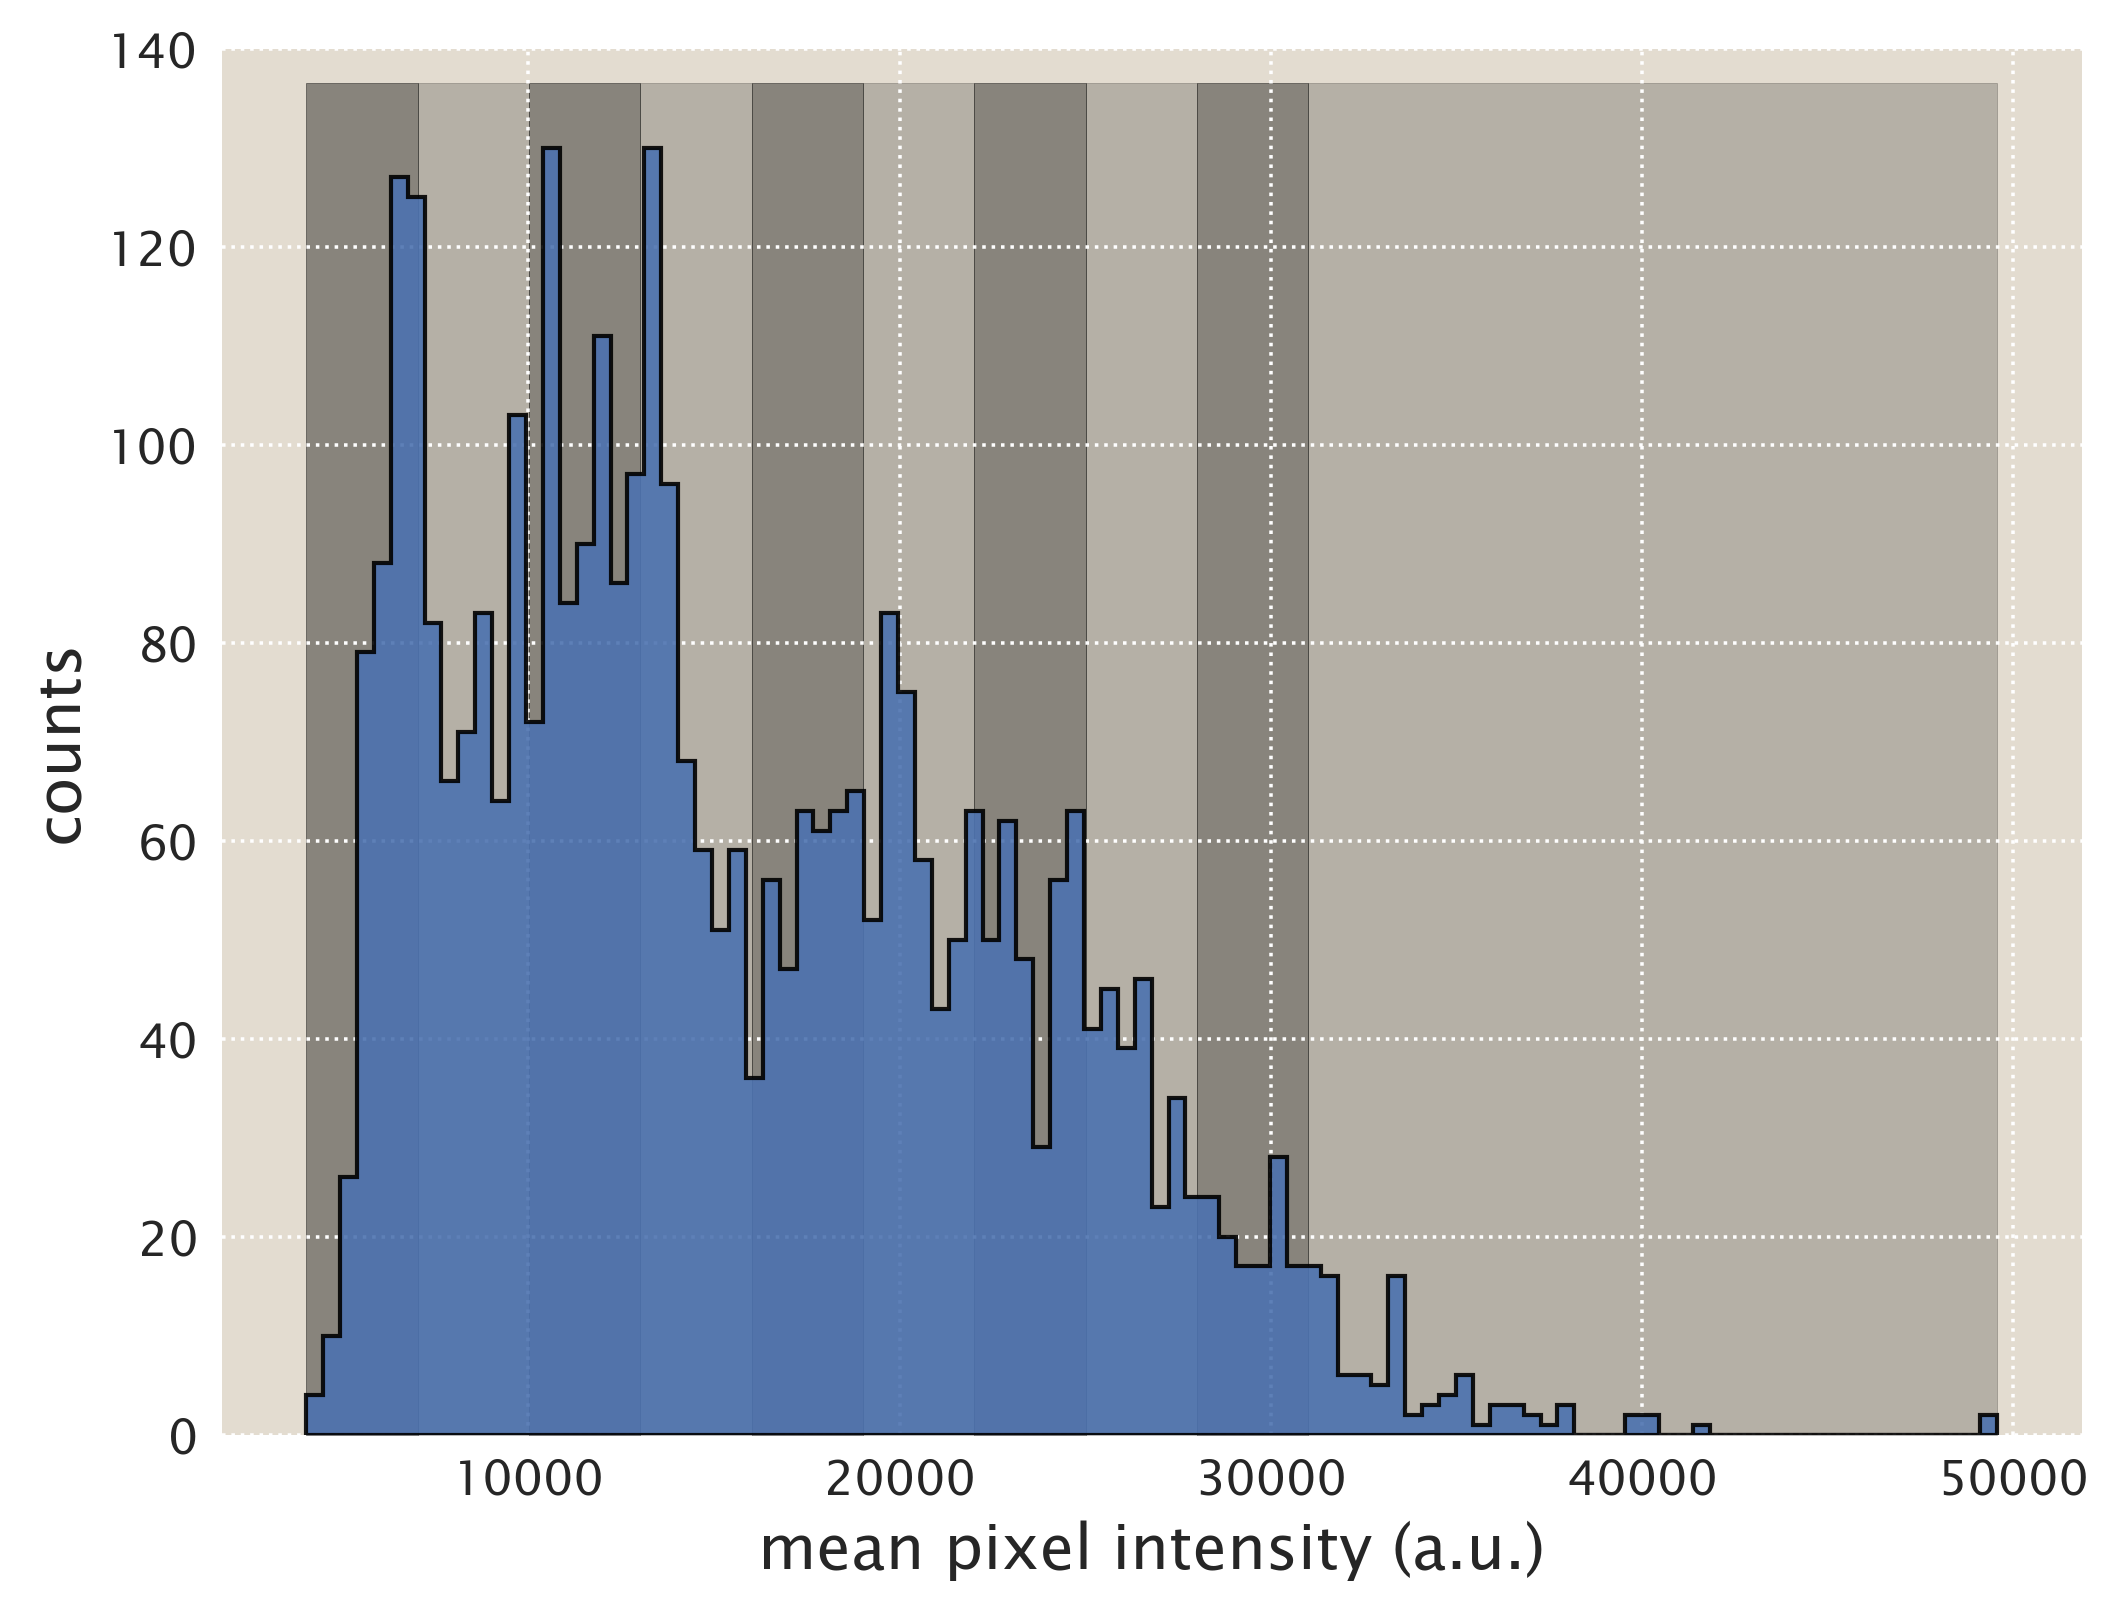

In [22]:
fig, ax = plt.subplots(1,1, sharex=True, sharey=True)
x, y = ecdf(data['raw_rescaled'] * ip_dist**2)
_ = ax.hist(data[data['flow_rate'] < 5]['raw_rescaled'] * ip_dist**2, bins=100, alpha=0.9, zorder=2,
           edgecolor='k', lw=1, histtype='stepfilled', color=colors[0])
# _ = ax[1].hist(data[data['flow_rate'] >= 1]['raw_rescaled'] * ip_dist**2, bins=100, alpha=0.9, zorder=2,
#            edgecolor='k', lw=1, histtype='stepfilled', color=colors[1])
# ax.step(x, y, '-', color=colors[0], )
# sns.kdeplot(data['raw_rescaled'] * ip_dist**2, ax=ax)
palette = sns.color_palette('deep')
ax = [ax]
bin_edges = [bin_edges[0]]
for j, _ in enumerate(bin_edges):
    y = np.linspace(0, ax[j].get_ylim()[1], 500)

#     for i in range(len(bin_edges[j]) - 1) :
#         ax[j].vlines(bin_edges[j][i], 0, ax[j].get_ylim()[1], color = 'k', zorder=1, alpha=0.6)

    for i in range(1, len(bin_edges[j])):
        if i%2 == 1:
            print(i)
            ax[j].fill_betweenx(y, bin_edges[j][i-1], bin_edges[j][i], color='k', alpha=0.4, zorder=0)
        else:
            ax[j].fill_betweenx(y, bin_edges[j][i-1], bin_edges[j][i], color='k', alpha=0.2, zorder=0)
        
#     ax[j].vlines((data['raw_rescaled'] * ip_dist**2).max(), 0, ax[j].get_ylim()[1], alpha=0.6, zorder=2, color='k')
    ax[j].fill_betweenx(y, bin_edges[j][-1], (data['raw_rescaled'] * ip_dist**2).max(), color='k', alpha=0.2, zorder=0)
    # ax.set_ylim([0, 1.01])
    ax[j].set_ylabel('counts', fontsize=15)
   
    ax[j].set_ylim([0, 140])

ax[0].set_xlabel('mean pixel intensity (a.u.)', fontsize=15)
plt.savefig('figs/intensity_binning.pdf', bbox_inches='tight')

##  Building a Bayesian estimate of survival probability

Rather than just relying on bootstrapping each bin to get a statistical errorbar on the survival, we can just evaluate the posterior probability distribution and use the width of this distribution as the error. We can begin by writing down Bayes's theorem which states

$$
P(p\, |\, n, N) = {P(n |\, p, N) P(p) \over P(n\, |\, N)}
$$

where $p$ is the probability of survival, $n$ is the number of surviving cells, and $N$ is the total number of cells observed. The likelihood is simply a binomial distribution,

$$
P(n | p, N) = {N! \over n!(N-n)!}p^n(1 - p)^{N-n}.
$$

We know nothing about the bias of our coin, which is described by our prior $P(p)$. We can therefore give it a uniform prior across all values $\in (0, 1)$. Our evidence, $P(n\, |\, N)$ is a measure of how likely we are to have $n$ survivors knowing nothing about $p$. Here, we can assume that all numbers of surivivors are equally likely, such that our evidence becomes

$$P(n\, |\, N) = {1 \over (N + 1)}.$$

With all of the pieces defined our full normalized posterior probability distribution can be written as

$$
P(p\, |\, n, N) = {(N+1)! \over n!(N-n)!}p^n(1 - p)^{N - n}.
$$

The maximum a posteriori value of the survival probability $p^*$ is defined as the location at which the logarithm of the log probability distribution goes to zero,

$$
{d \ln P(p\, \vert\, n, N) \over dp} = {n \over p} - {N - n \over 1 - p}.
$$

Solving for $p^*$ yields

$$
\begin{align}
{d \ln P(p\, \vert\, n, N) \over dp} = 0\\
  p^*  &= {n \over n}.
 \end{align}
$$

We can approximate the posterior as a Gaussian distribution. Making this approximation, we say that the variance is 

$$
\sigma^2 = -\left({d^2 P(p\,|\, n, N) \over dp^2}\Big|_{p=p^*}\right)^{-1}
$$

yielding

$$
\sigma^2 = {n(N - n) \over n^3}.
$$

This very simple statistical model allows us to express our boolean survival measurements as 

$$
p = p^* \pm \sigma.
$$

With this in hand, let's approach the binning more carefully. 

In [128]:
data_dir = 'data/images/intensity_calibration/'
folders = ['sd0', 'sd2', 'MLG910', 'sd1']
dfs = []
for i, f in enumerate(folders):
    # Glob all the file names. 
    target_bf = '/*/Pos*/*Brightfield*.tif'
    target_gfp = '/*/Pos*/*GFP*.tif'
    files= glob.glob(data_dir + f + target_bf)
    files_gfp = glob.glob(data_dir + f + target_gfp)
    files_met = glob.glob(data_dir + f +'/*/Pos*/*metadata.txt')
    print(len(files), len(files_gfp))
     
    # Loop through each image and process
    for j, file in enumerate(files):
        im_phase = skimage.io.imread(file)
        im_gfp = skimage.io.imread(files_gfp[j])
        name = file.split('/')[-2]
       
        # Filter the image. 
        selem = skimage.morphology.square(3)
        im_gfp = scipy.ndimage.median_filter(im_gfp, footprint=selem)
        exp = scrape_metadata(fname=files_met[j], return_date=False)
        # Process.
        conts, seg = contour_seg(im_phase, return_conts=True, perim_bounds=(5, 1E5),
                                     ecc_bounds=(0.7, 1.0), area_bounds=(1, 100)) 
            
        # Perform the field bg subtraction. 
        flat_seg = seg > 0
        dil_selem = skimage.morphology.disk(8)
        im_dil = skimage.morphology.dilation(flat_seg, dil_selem)
        inv_seg = skimage.measure.label(im_dil < 1)
        inv_props = skimage.measure.regionprops(inv_seg, im_gfp)
        mean_bg = np.mean([prop.mean_intensity / ip_dist**2 for prop in inv_props])     
        props = skimage.measure.regionprops(seg, im_gfp)
            
        # Convert total
        raw_intensities = np.array([prop.mean_intensity/ip_dist**2 for prop in props])
        sub_intensities = raw_intensities - mean_bg
        areas = [prop.area * ip_dist**2 for prop in props]
                 
        # Make a DataFrame of all of the relevant properties.
        df = pd.DataFrame([raw_intensities, sub_intensities, areas]).T
        df.insert(0, 'mean_bg', mean_bg)
        df.insert(0, 'exposure_ms', exp['GFP_exp_ms']) 
        df.insert(0, 'sd', f)    
        df.columns = ['sd', 'exposure_ms', 'mean_bg', 'raw_intensity', 'sub_intensity', 'area']
        dfs.append(df)

         
# Concatenate all of the DataFrames together. 
cal_data = pd.concat(dfs)

62 62
20 20
79 79
62 62


/Users/gchure/anaconda/lib/python3.6/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


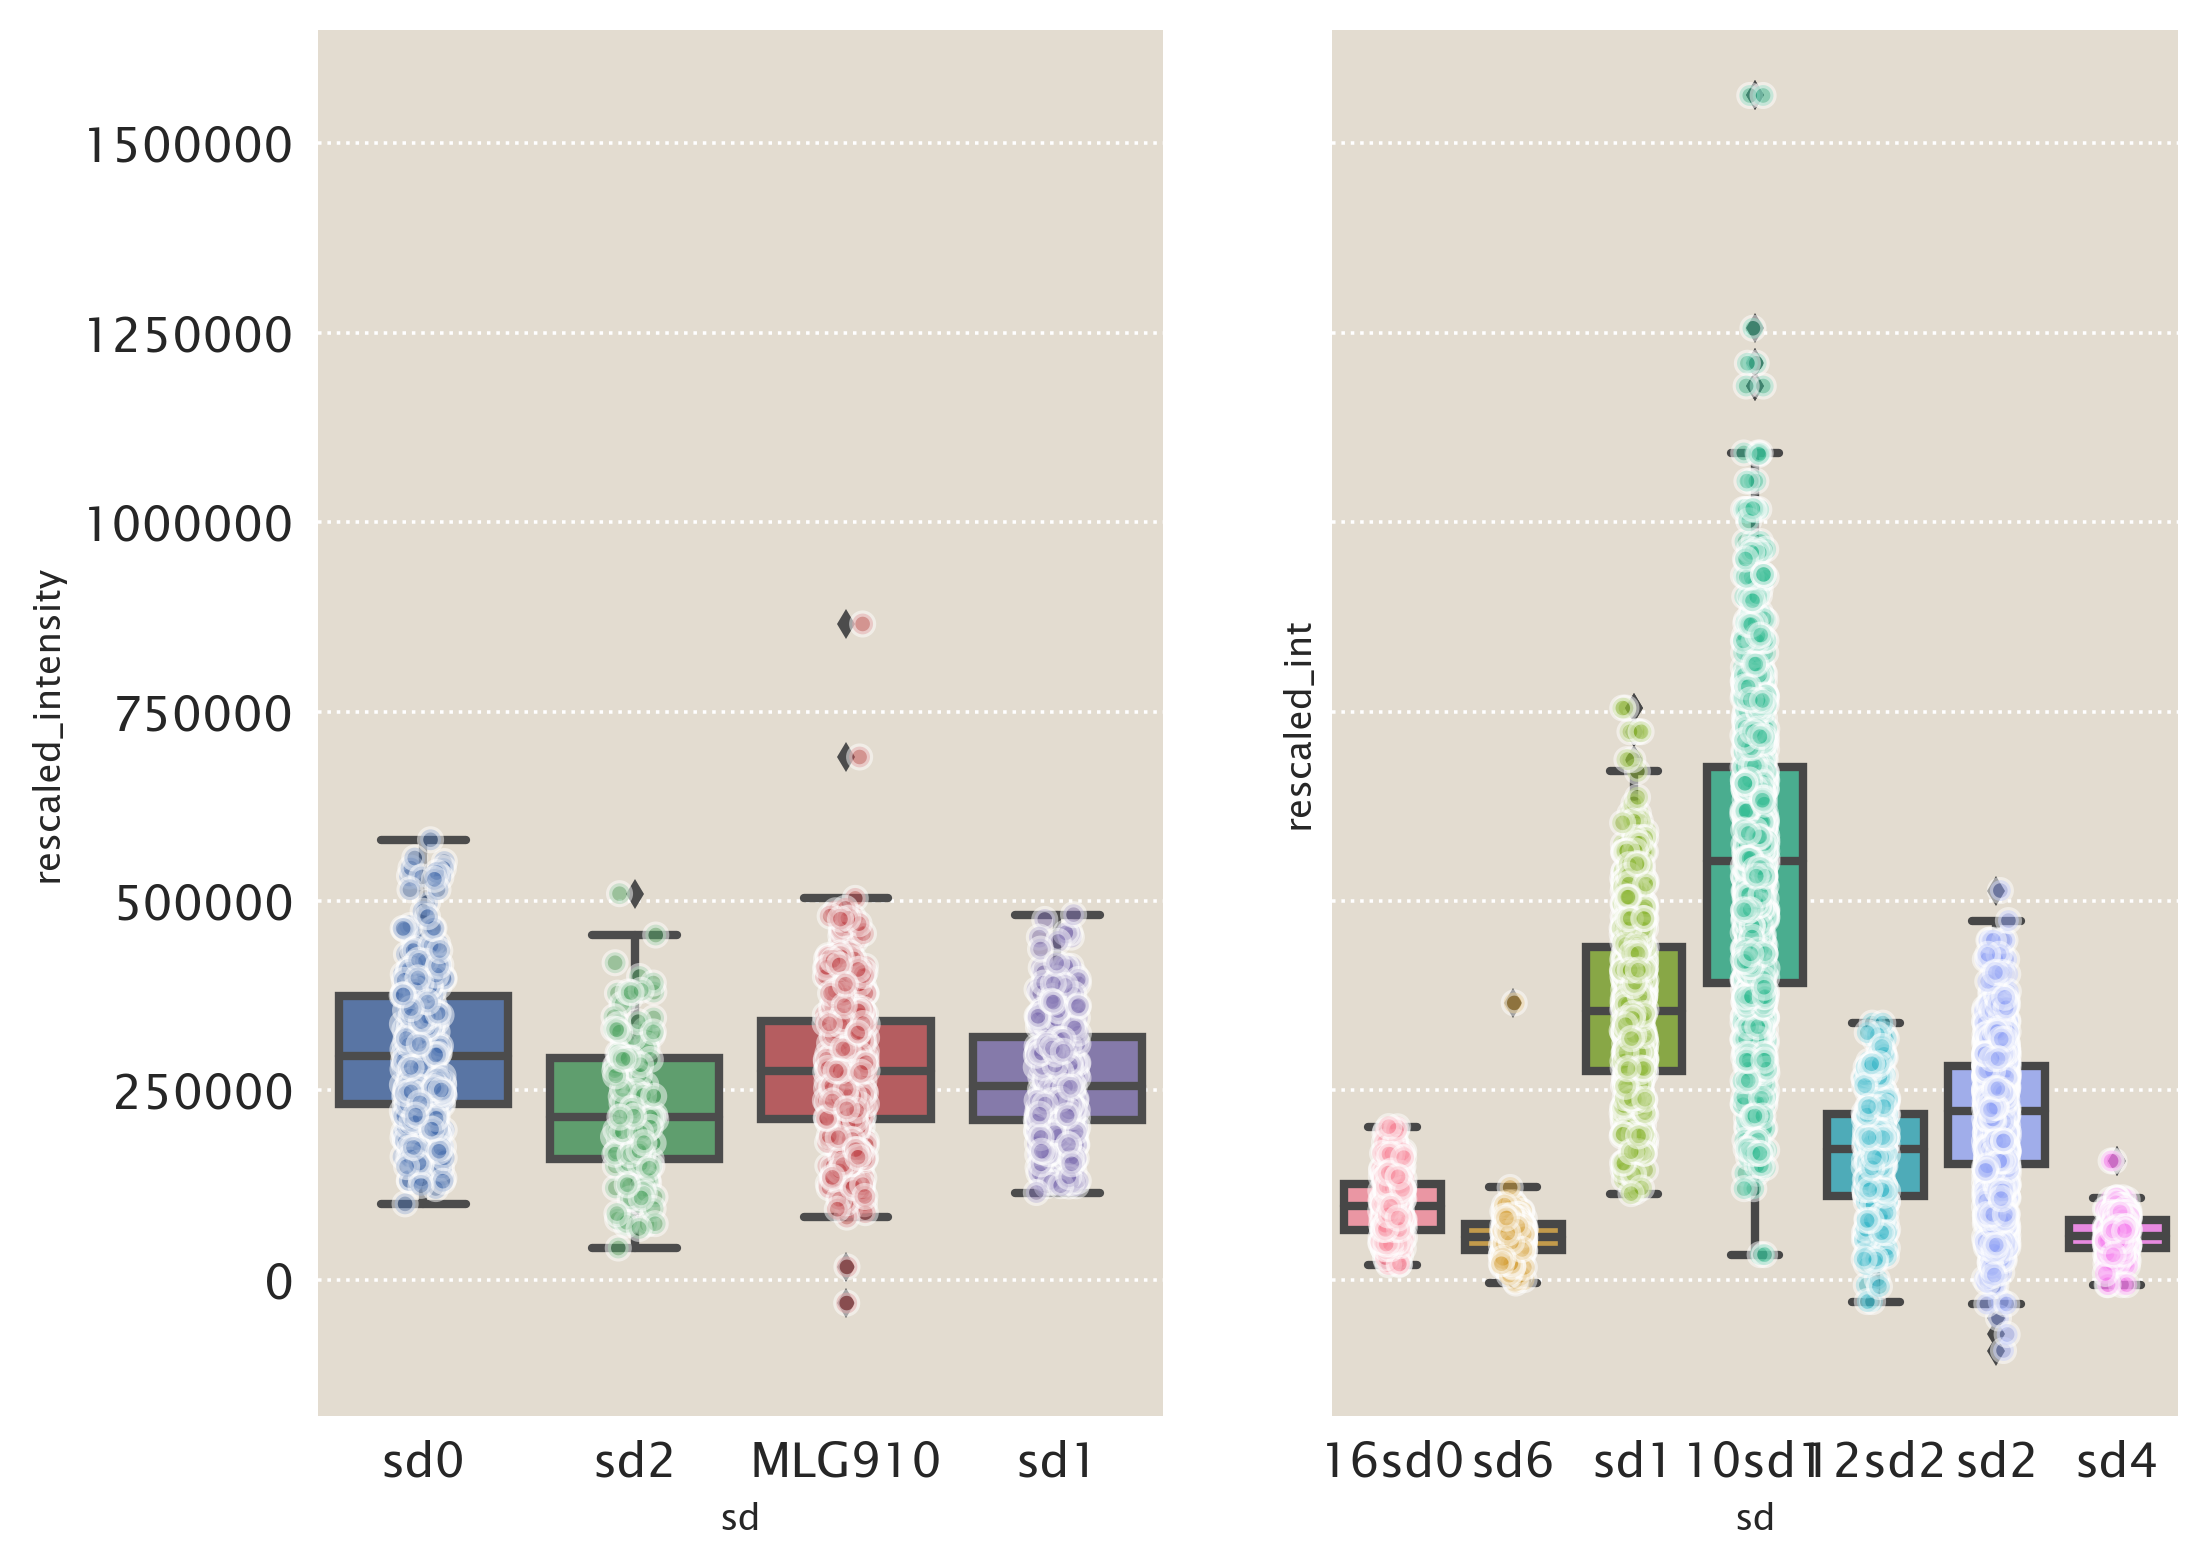

In [132]:
cal_data['rescaled_intensity'] = cal_data['sub_intensity'] * max_exp / cal_data['exposure_ms']

fig, ax = plt.subplots(1, 2, sharey=True)

sns.boxplot(x='sd', y='rescaled_intensity', data=cal_data, ax=ax[0])
sns.stripplot(x='sd', y='rescaled_intensity', data=cal_data, linewidth=1.5, 
               edgecolor='w', alpha=0.5, jitter=True, ax = ax[0])
sns.boxplot(x='sd', y='rescaled_int', data=data, ax=ax[1])
sns.stripplot(x='sd', y='rescaled_int', data=data, ax=ax[1], linewidth=1.5,
             edgecolor='w', alpha=0.5, jitter=True)

cal_data.to_csv('data/201707_intensity_calibration_data.csv', index=False)

In [136]:
rescaled_data = data.copy()
mean_sd1_fc = np.median(data[data['sd'] == 'sd1']['rescaled_int']) / np.median(cal_data[cal_data['sd']=='sd1']['rescaled_intensity'])
rescaled_data.loc[rescaled_data['sd'] == 'sd1', 'rescaled_int'] = rescaled_data[rescaled_data['sd'] == 'sd1']['rescaled_int']
print(mean_sd1_fc)

1.38812436305


In [120]:
# make a copy of the dataframe to manipulate.


df = data.copy()
# df = df[(df['sd'] != 'sd1') & (df['sd'] != '10sd1')]
# Remove unnecessary columns.
df.drop(['fluo_name', 'phase_name', 'x_pos', 'y_pos', 'mask_label',
                   'label_cent_x', 'label_cent_y', 'dist', 'rel_int', 'num_chan'],
                 axis=1, inplace=True)
# Group flow rates into 'slow' and 'fast'
_groups = df['flow_rate'] < 1.0 
groups = ['slow' if x == True else 'fast' for x in _groups]
df.insert(np.shape(df)[1], 'flow_group', groups)

# Perform the binning by consolidating the number of cells. 
channel_bin = 150
bin_width = channel_bin / fl_per_channel #3.5E3 / ip_dist**2 # in arbitrary units, for now. 
df['num_channels'] = df['rescaled_int'] * fl_per_channel
# bins = np.arange(df['num_channels'].min() - 0.1,\
#                  df['num_channels'].max() + 0.1, channel_bin)
bins = np.arange(0, 1100, channel_bin)

# df.insert(np.shape(df)[1], 'fluo_bin', 0)
for i in tqdm.tqdm_notebook(range(0, len(bins) - 1)): 
    df.loc[(df['num_channels'] >= bins[i]) &\
       (df['num_channels'] < bins[i+1]), 'bin_no'] = int(i)
    
# Group by the flow rate and bin_no
grouped = df.groupby(['flow_group', 'bin_no'])
g_dict = {'slow': 0, 'fast': 1}
rev_dict = {0:'slow', 1:'fast'}
events = [{}, {}]
for g, d in grouped:
    events[g_dict[g[0]]][g[1]]= len(d)
    
min_cells = 50 
changed_keys = [{}, {}]
for i, flow in enumerate(events):
    low_keys = []
    for k in flow.keys():
        if flow[k] < min_cells:
            low_keys.append(k)
            
    # Separate them sequentially
    split_keys = []
    inds = np.where(np.diff(low_keys) > 1)[0]
    if len(inds) > 0:
        for j in range(len(inds)):
            if j==0:
                split_keys.append(low_keys[: inds[j] + 1])
            elif i==(len(ind) - 1):
                split_keys.append(low_keys[inds[j-1]+1: inds[j]+1])
                split_keys.append(low_keys[inds[j]+1: ])
            else:
                split_keys.append(low_keys[inds[j-1]+1: inds[j]+1])
    else:
        split_keys = [low_keys]
    for rng in split_keys:
        n_cells = np.sum(flow[z] for z in rng)
        if np.sum(flow[z] for z in rng) >= min_cells: 
            for z in rng:
                changed_keys[i][z] = np.min(rng)

        else:
            for z in rng:
                changed_keys[i][z] = np.min(rng) - 1

    # Change the bin number in the DataFrame. 
    for k in changed_keys[i].keys():
        df.loc[(df['flow_group'] == rev_dict[i]) & (df['bin_no']== k),\
               'bin_no'] = changed_keys[i][k]

In [121]:
grouped = df.groupby('flow_group')
colors = sns.color_palette('deep')
columns = ['flow_group', 'bin_number', 'mean_intensity', 'num_channels', 'min_int', 'max_int',
            'survival_probability', 'survivor_error']
dfs = []
for g, d in grouped: 
    # Group the data by the bin number. 
    _grouped = d.groupby('bin_no')
    
    for _g, _d in _grouped:
        n = np.sum(_d['survival'])
        N = len(_d)  
        mean_int = np.mean(_d['rescaled_int'])
        mean_chan = np.mean(_d['num_channels'])
        min_int = np.min(_d['rescaled_int'])
        max_int = np.max(_d['rescaled_int'])
        surv_frac = np.sum(_d['survival']) / len(_d)
        surv_error = np.sqrt(n * (N-n)/ N**3)
        dfs.append(pd.DataFrame([g, _g, mean_int, mean_chan, min_int, max_int, surv_frac, surv_error]).T)
prob_df = pd.concat(dfs)        
prob_df.columns = columns

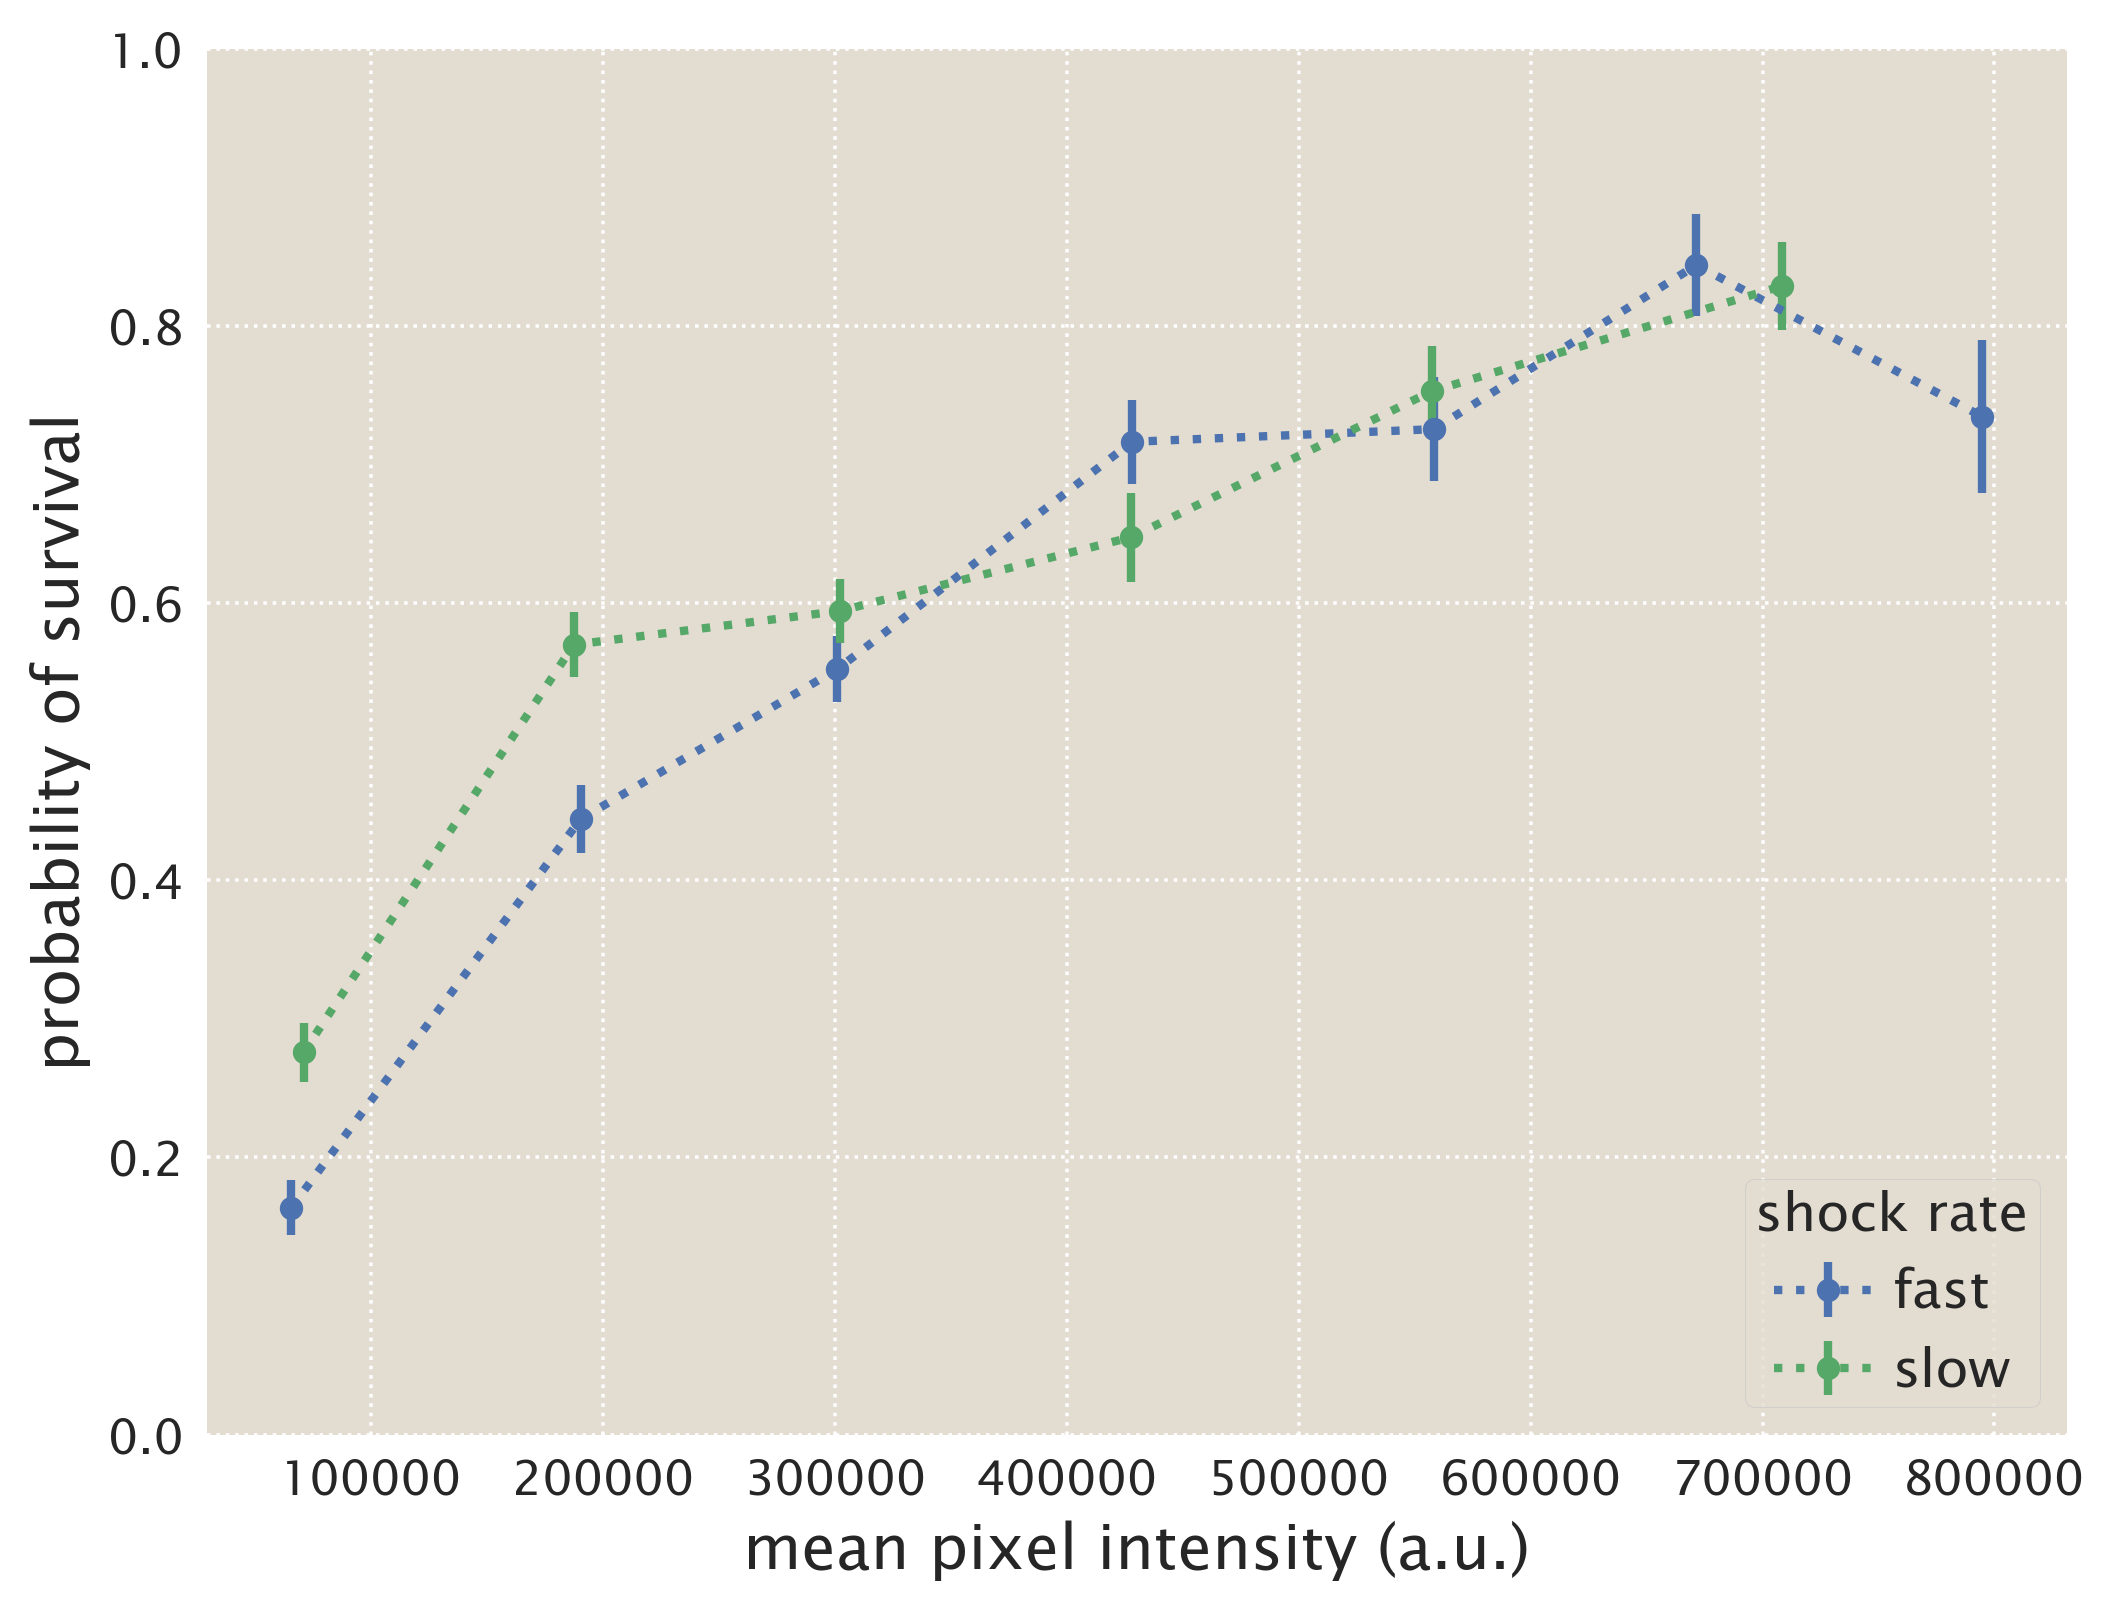

In [122]:
grouped = prob_df.groupby('flow_group')
i = 0
for g, d in grouped:
#     if g=='fast':
        plt.errorbar(d['mean_intensity'], d['survival_probability'], d['survivor_error'], fmt='o',
                    color=colors[i], linestyle=':', label=g)

#         plt.hlines(d['survival_probability'], d['min_int']* ip_dist**2, d['max_int'] * ip_dist**2,
#                    color=colors[i])
        i += 1
    
# plt.legend()
plt.ylabel('probability of survival', fontsize=15)
plt.xlabel('mean pixel intensity (a.u.)', fontsize=15)
plt.ylim([0, 1])
leg = plt.legend(title='shock rate', fontsize=13, loc='lower right')
leg.get_title().set(fontsize=13)
# plt.savefig('figs/fast_shock_survival_probability.pdf', bbox_inches='tight')

## Calibrating to channel number. 

In [112]:
# Rescale the SD data. 
SDdata.columns = ['date', 'sd', 'exposure_ms', 'mean_bg', 'raw_intensities', 'sub_intensity', 'areas']
SDdata['raw_rescaled'] = SDdata['raw_intensities'] * max_exp / SDdata['exposure_ms']

NameError: name 'SDdata' is not defined

NameError: name 'SDdata' is not defined

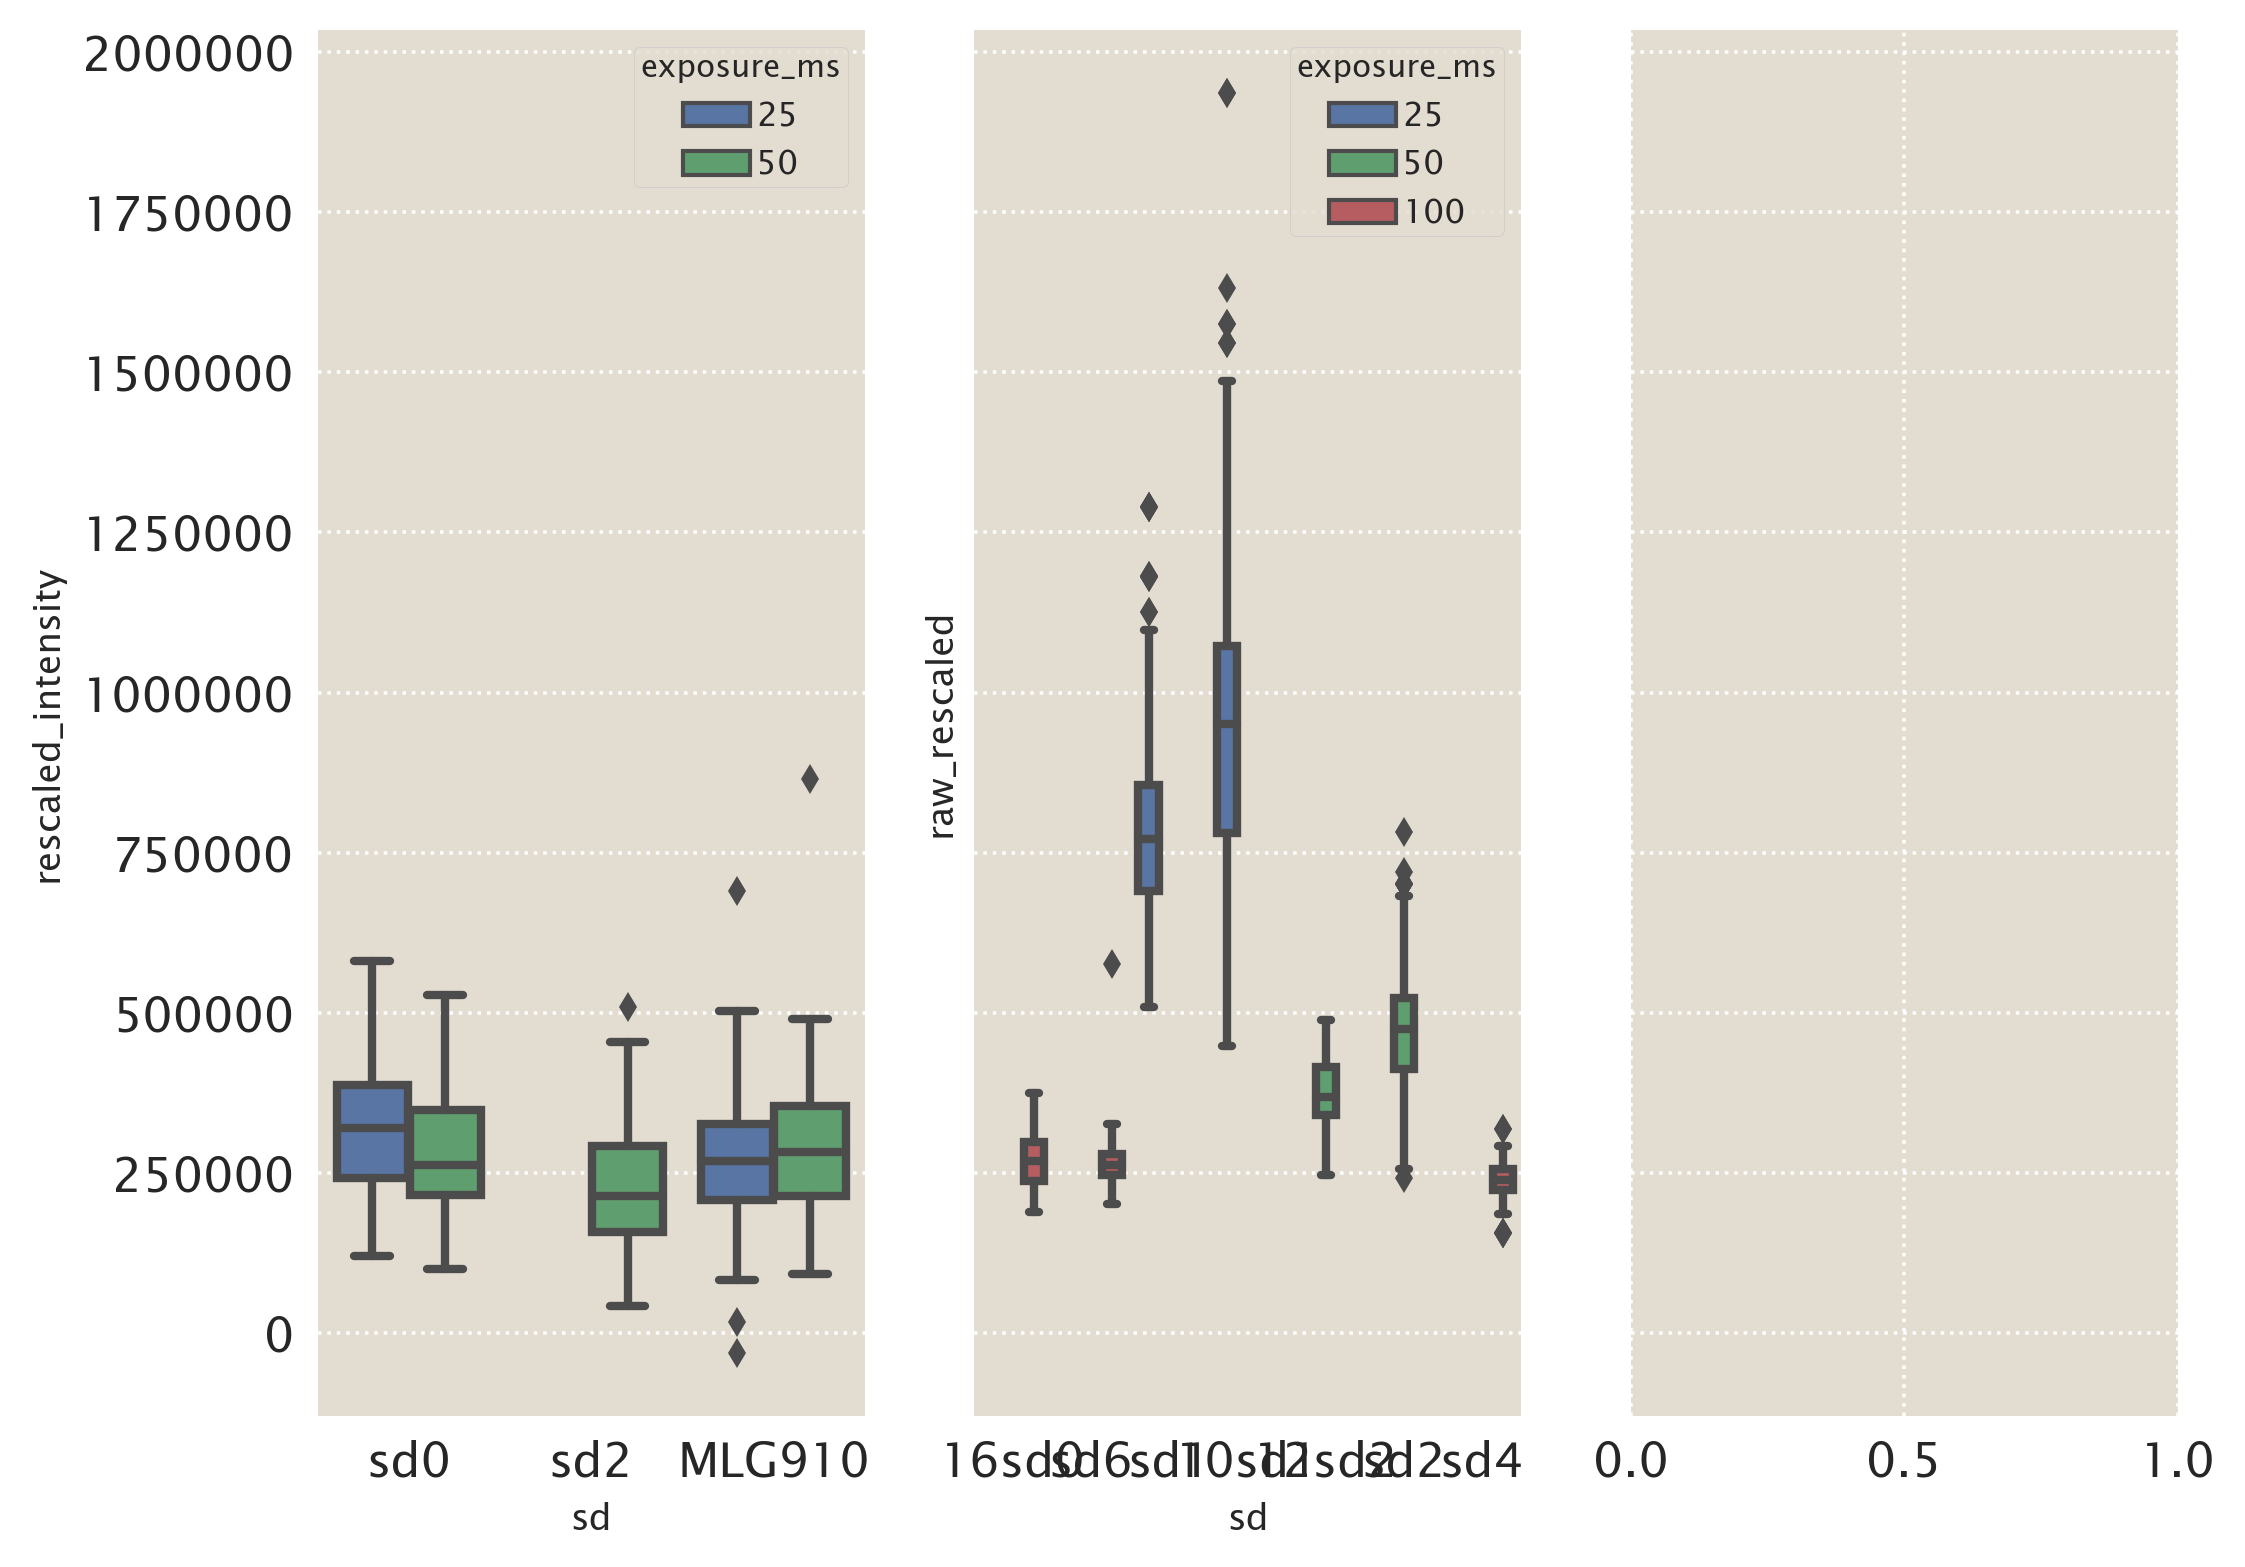

In [113]:
# plt.hist(cal_data['rescaled_intensity'], bins=75)
fig, ax = plt.subplots(1,3, sharey=True)
sns.boxplot(x='sd', y='rescaled_intensity', data=cal_data, hue='exposure_ms', ax=ax[0])
sns.boxplot(x='sd', y='raw_rescaled', data=data, hue='exposure_ms', ax = ax[1])
sns.boxplot(x='sd', y='raw_rescaled', data=SDdata, hue='exposure_ms', ax=ax[2])

In [ ]:
mean_sd0 = np.mean(cal_data[cal_data['sd']=='sd0']['rescaled_intensity'])

In [ ]:
mean_sd0

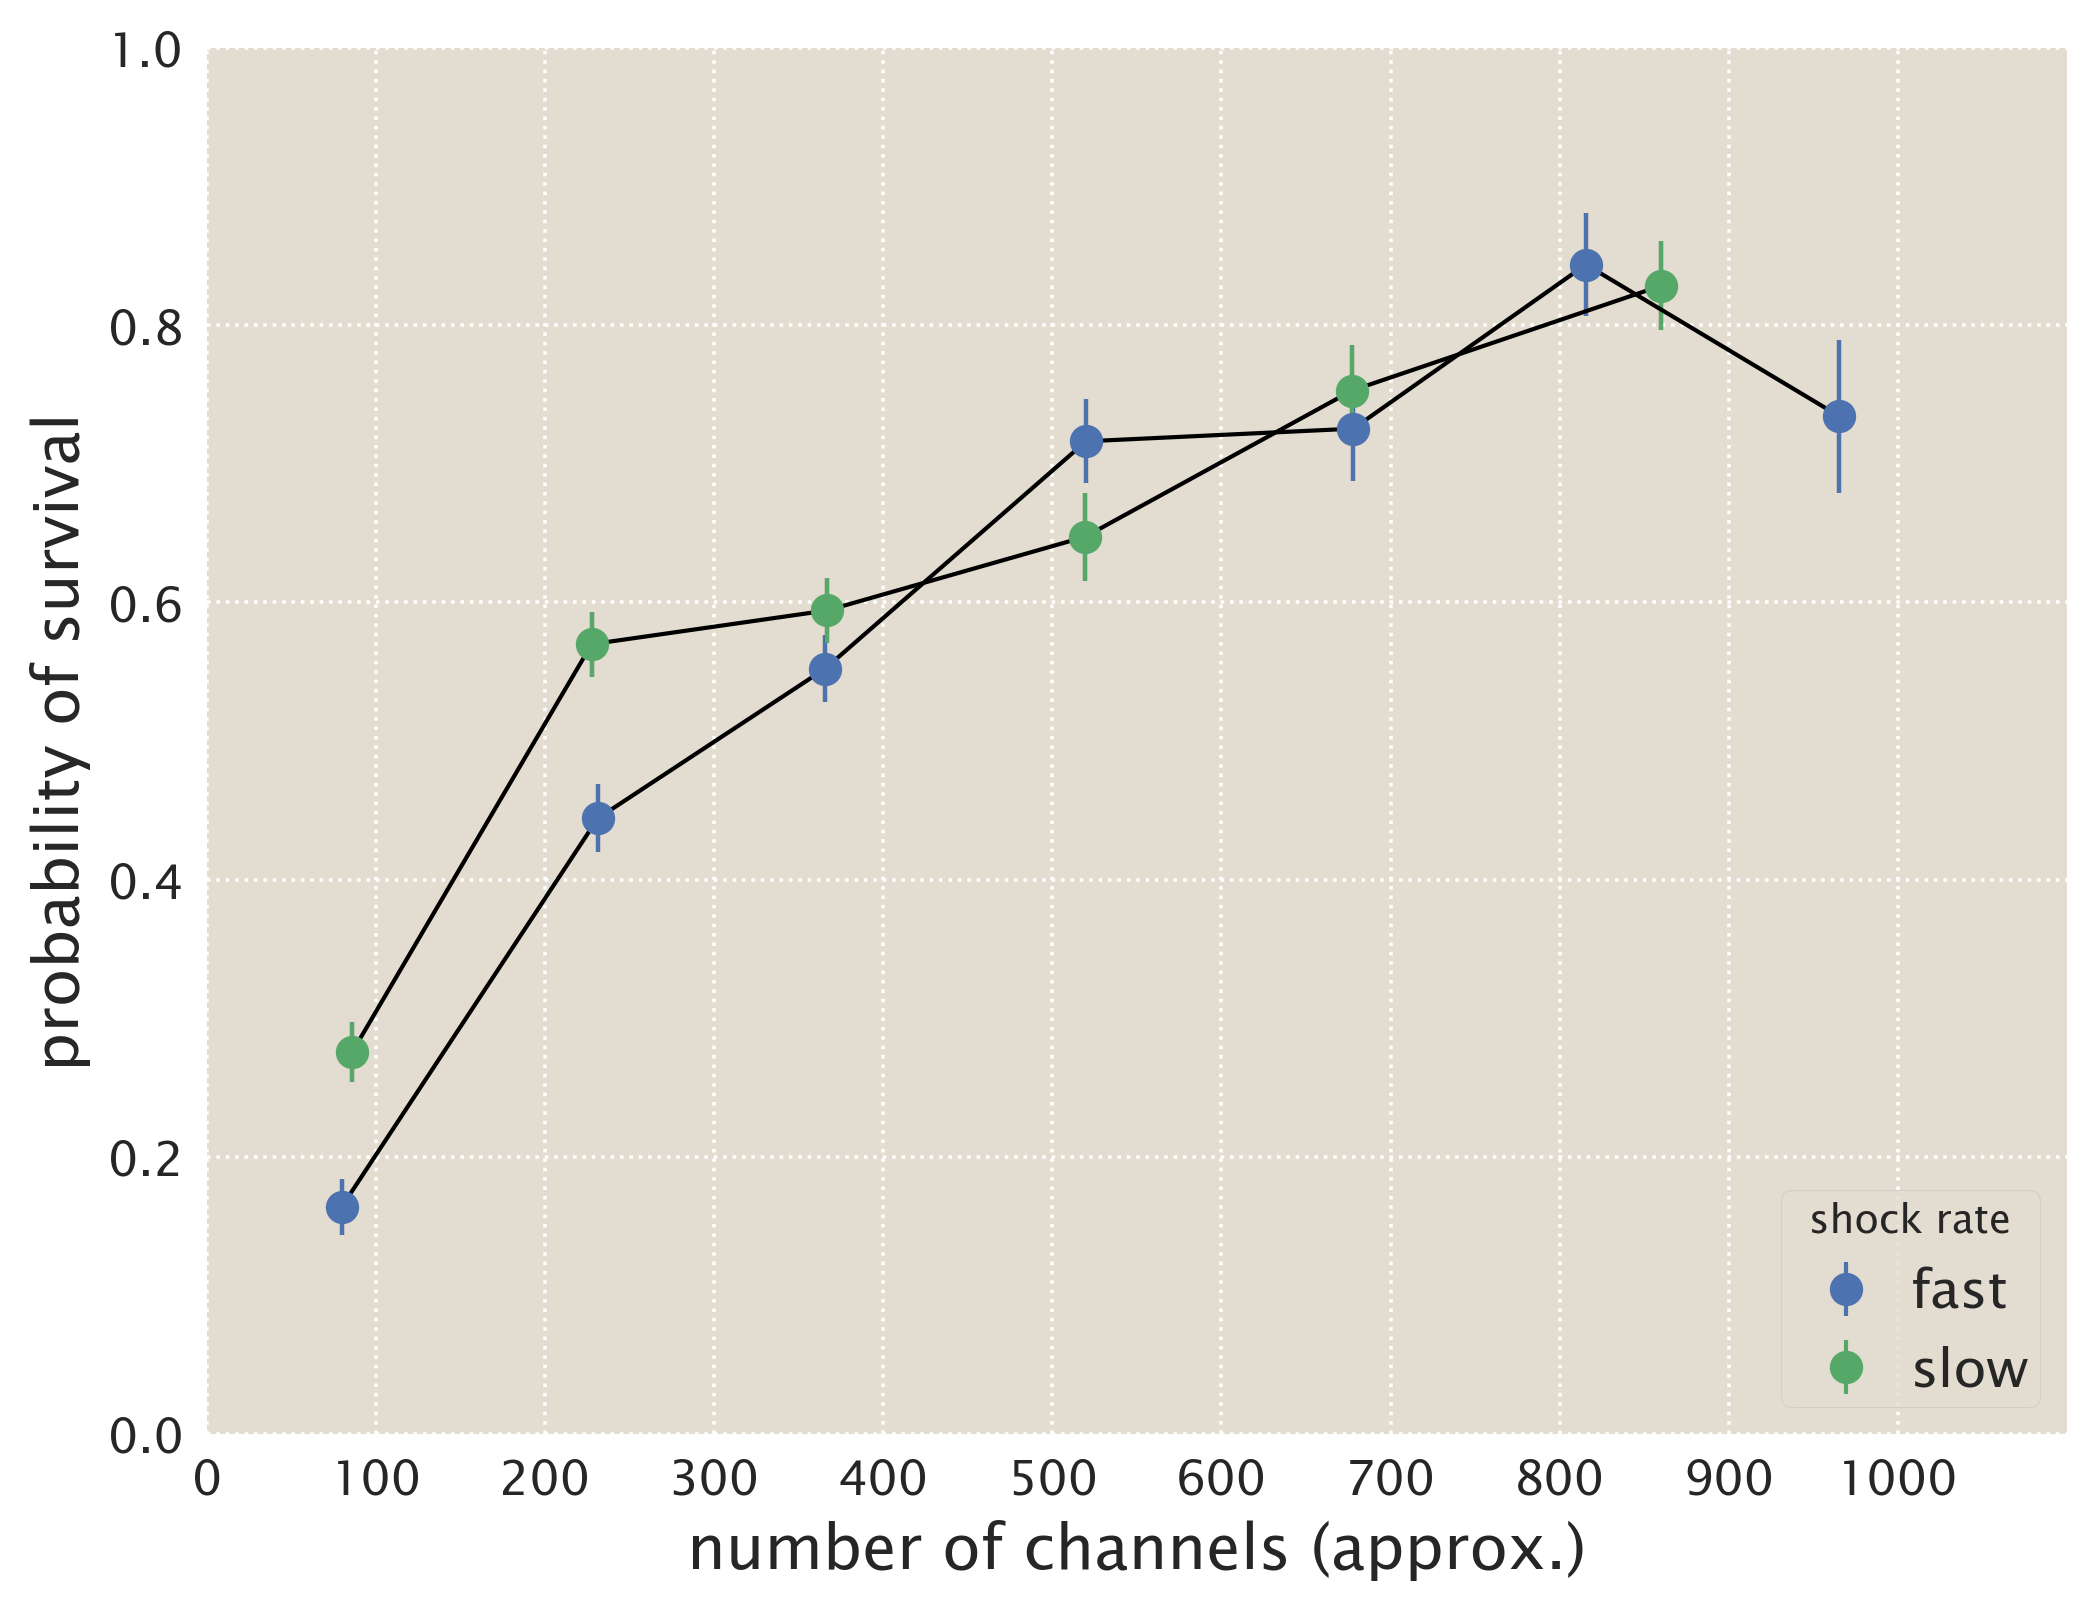

In [124]:
grouped = prob_df.groupby('flow_group')
i = 0
fl_per_channel = 340  / np.mean(cal_data[cal_data['sd'] == 'MLG910']['rescaled_intensity'])
for g, d in grouped:
#     if g=='fast':
        plt.errorbar((d['num_channels']), d['survival_probability'], d['survivor_error'], fmt='.',
                    color='k', linestyle='-', linewidth=1,  label='__nolegend__')
        plt.errorbar((d['num_channels']), d['survival_probability'], d['survivor_error'], fmt='o',
                    color=colors[i], linestyle='none', linewidth=1,  label=g, ms=8)

#         plt.hlines(d['survival_probability'], d['min_int']/mean_sd0, d['max_int']/mean_sd0,
#                    color=colors[i])
        i += 1
    
plt.legend()
plt.ylabel('probability of survival', fontsize=15)
# plt.xlabel('relative intensity to wt (Δ6 + mscL)', fontsize=15)
plt.xlabel('number of channels (approx.)', fontsize=15)
plt.ylim([0, 1])
plt.xlim([0, 1100])
plt.xticks(np.arange(0, 1100, 100))
leg = plt.legend(title='shock rate', fontsize=13, loc='lower right')
# leg.get_title().set(fontsize=13)
# plt.savefig('figs/fast_shock_survival_probability.pdf', bbox_inches='tight')

In [127]:
d['num_channels']

0    85.9703
0    227.542
0    366.755
0    519.336
0    677.286
0    860.246
Name: num_channels, dtype: object

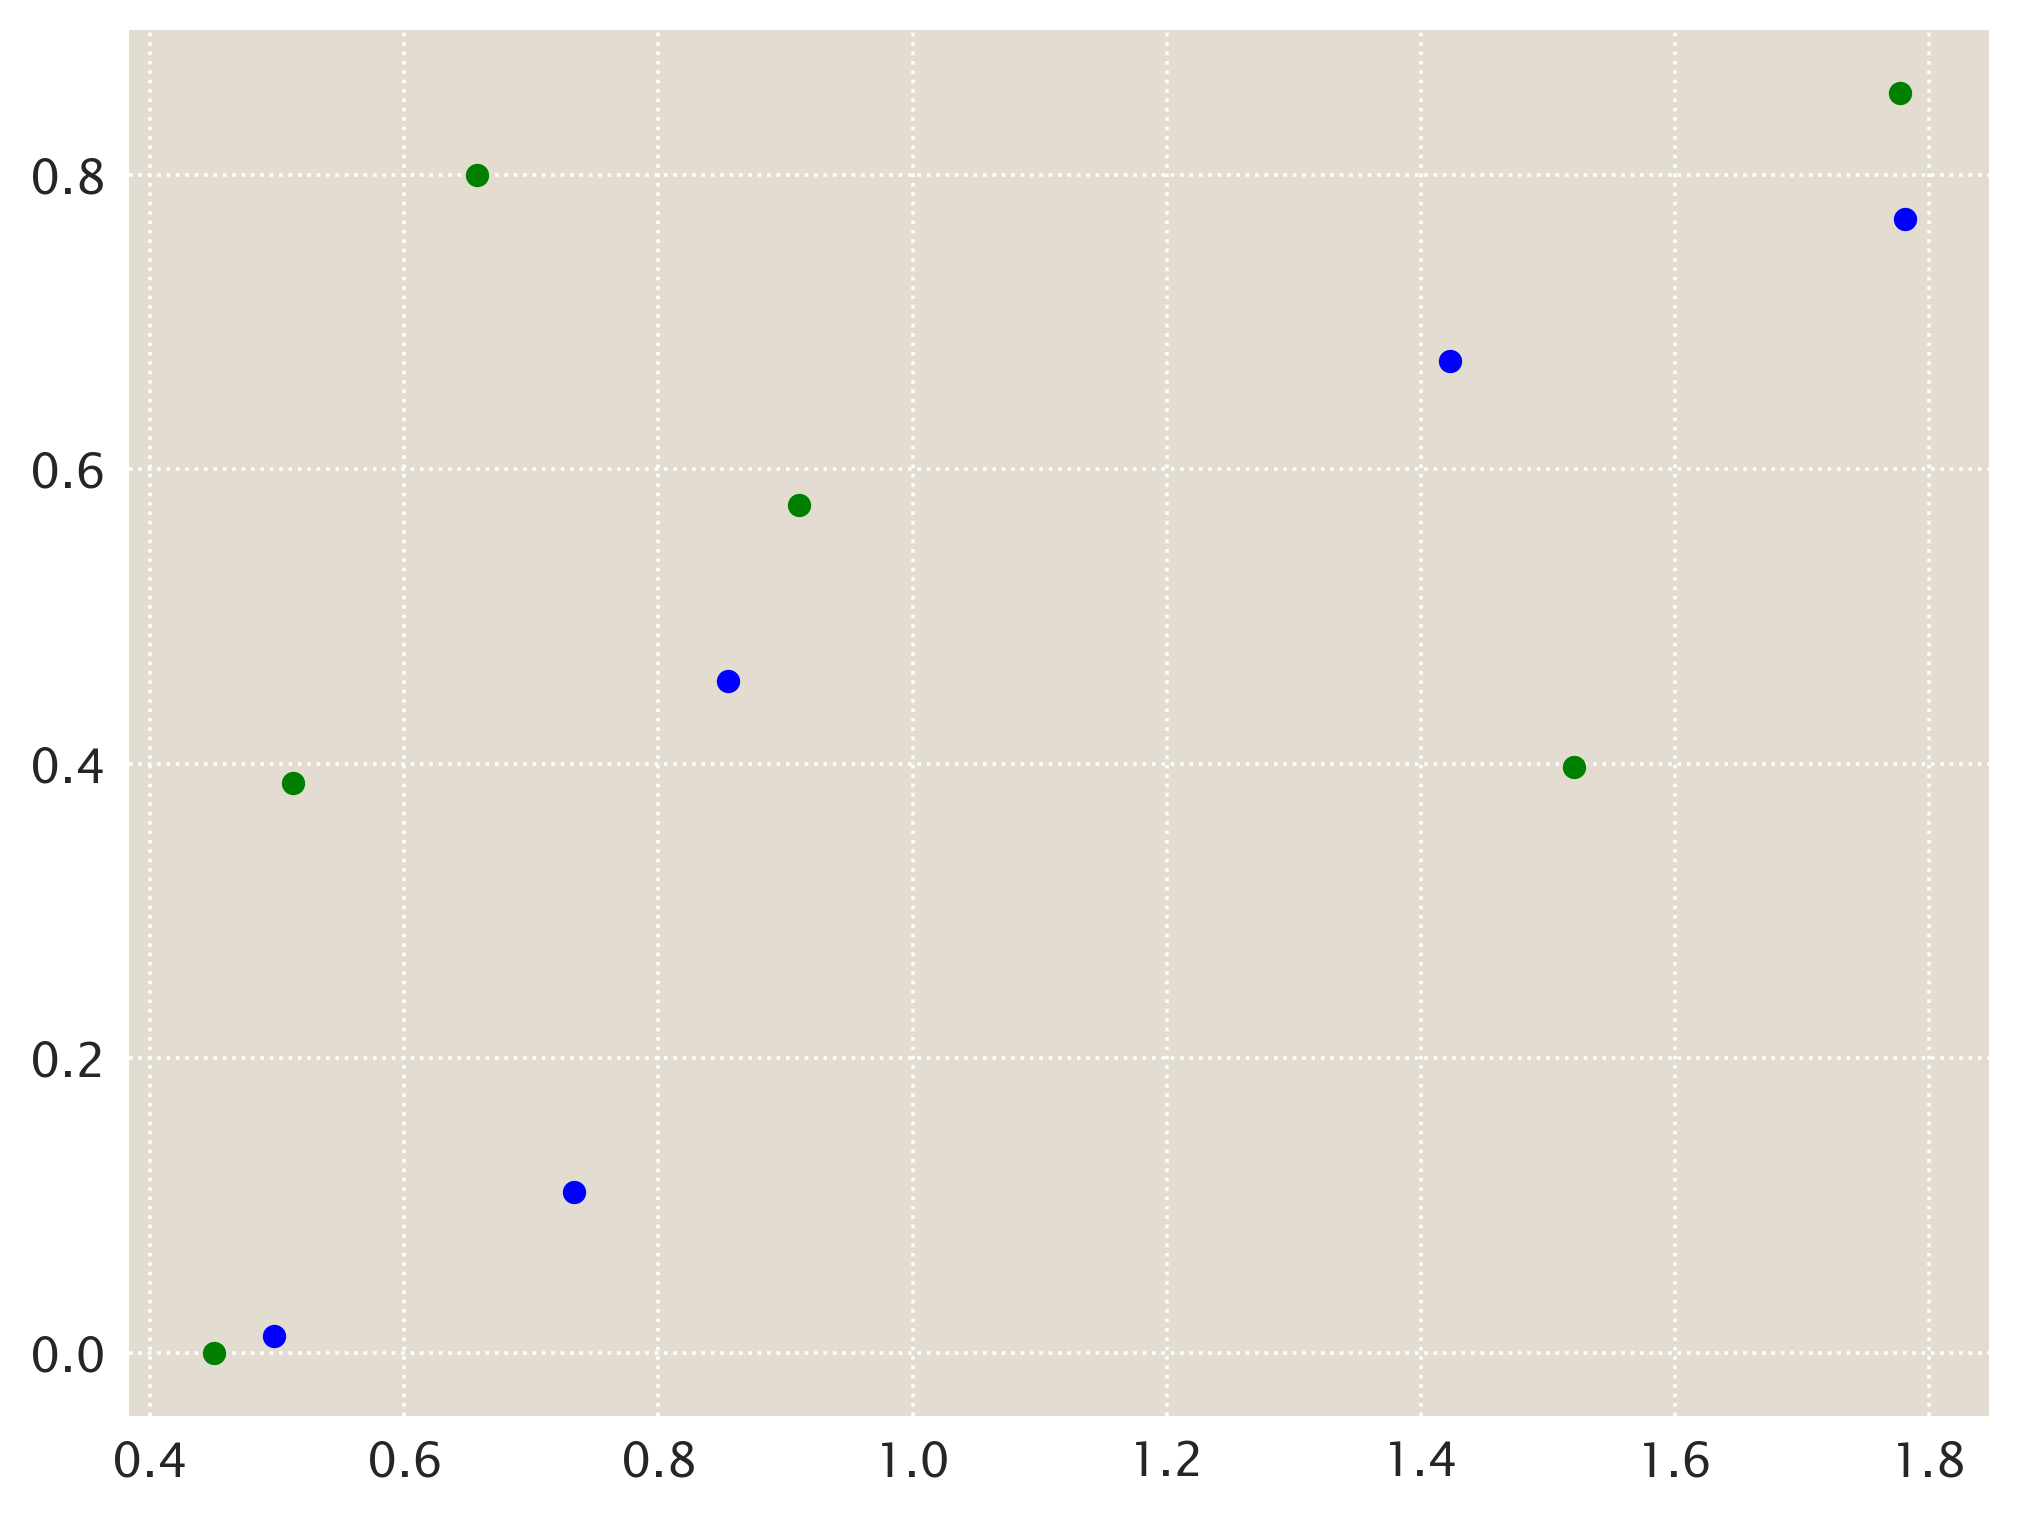

In [485]:
# slow_int = [np.mean(df[(df['sd']==x) & (df['flow_group']=='slow')]['raw_rescaled']) for x in df['sd'].unique()]
# fast_int = [np.mean(df[(df['sd']==x) & (df['flow_group']=='fast')]['raw_rescaled']) for x in df['sd'].unique()]
# slow_surv = [np.sum(df[(df['sd']==x) & (df['flow_group']=='slow')]['survival']) / len(df[(df['flow_group']=='slow') & (df['sd']==x)]) for x in df['sd'].unique()]
# fast_surv = [np.sum(df[(df['sd']==x) & (df['flow_group']=='fast')]['survival']) / len(df[(df['flow_group']=='fast') & (df['sd']==x)]) for x in df['sd'].unique()]

# plt.plot(slow_int, slow_surv, '-o', label='slow')
# plt.plot(fast_int, fast_surv, '-o', label='fast') 
for g, d in sd_grouped:

    if g[1] == 'slow':
        color = 'g'
    else:
        color = 'b'
    surv_frac = np.sum(d['survival']) / len(d)
    mean_int = np.mean(d['raw_rescaled']) / mean_sd0
    plt.plot(mean_int, surv_frac, 'o', color=color)
            

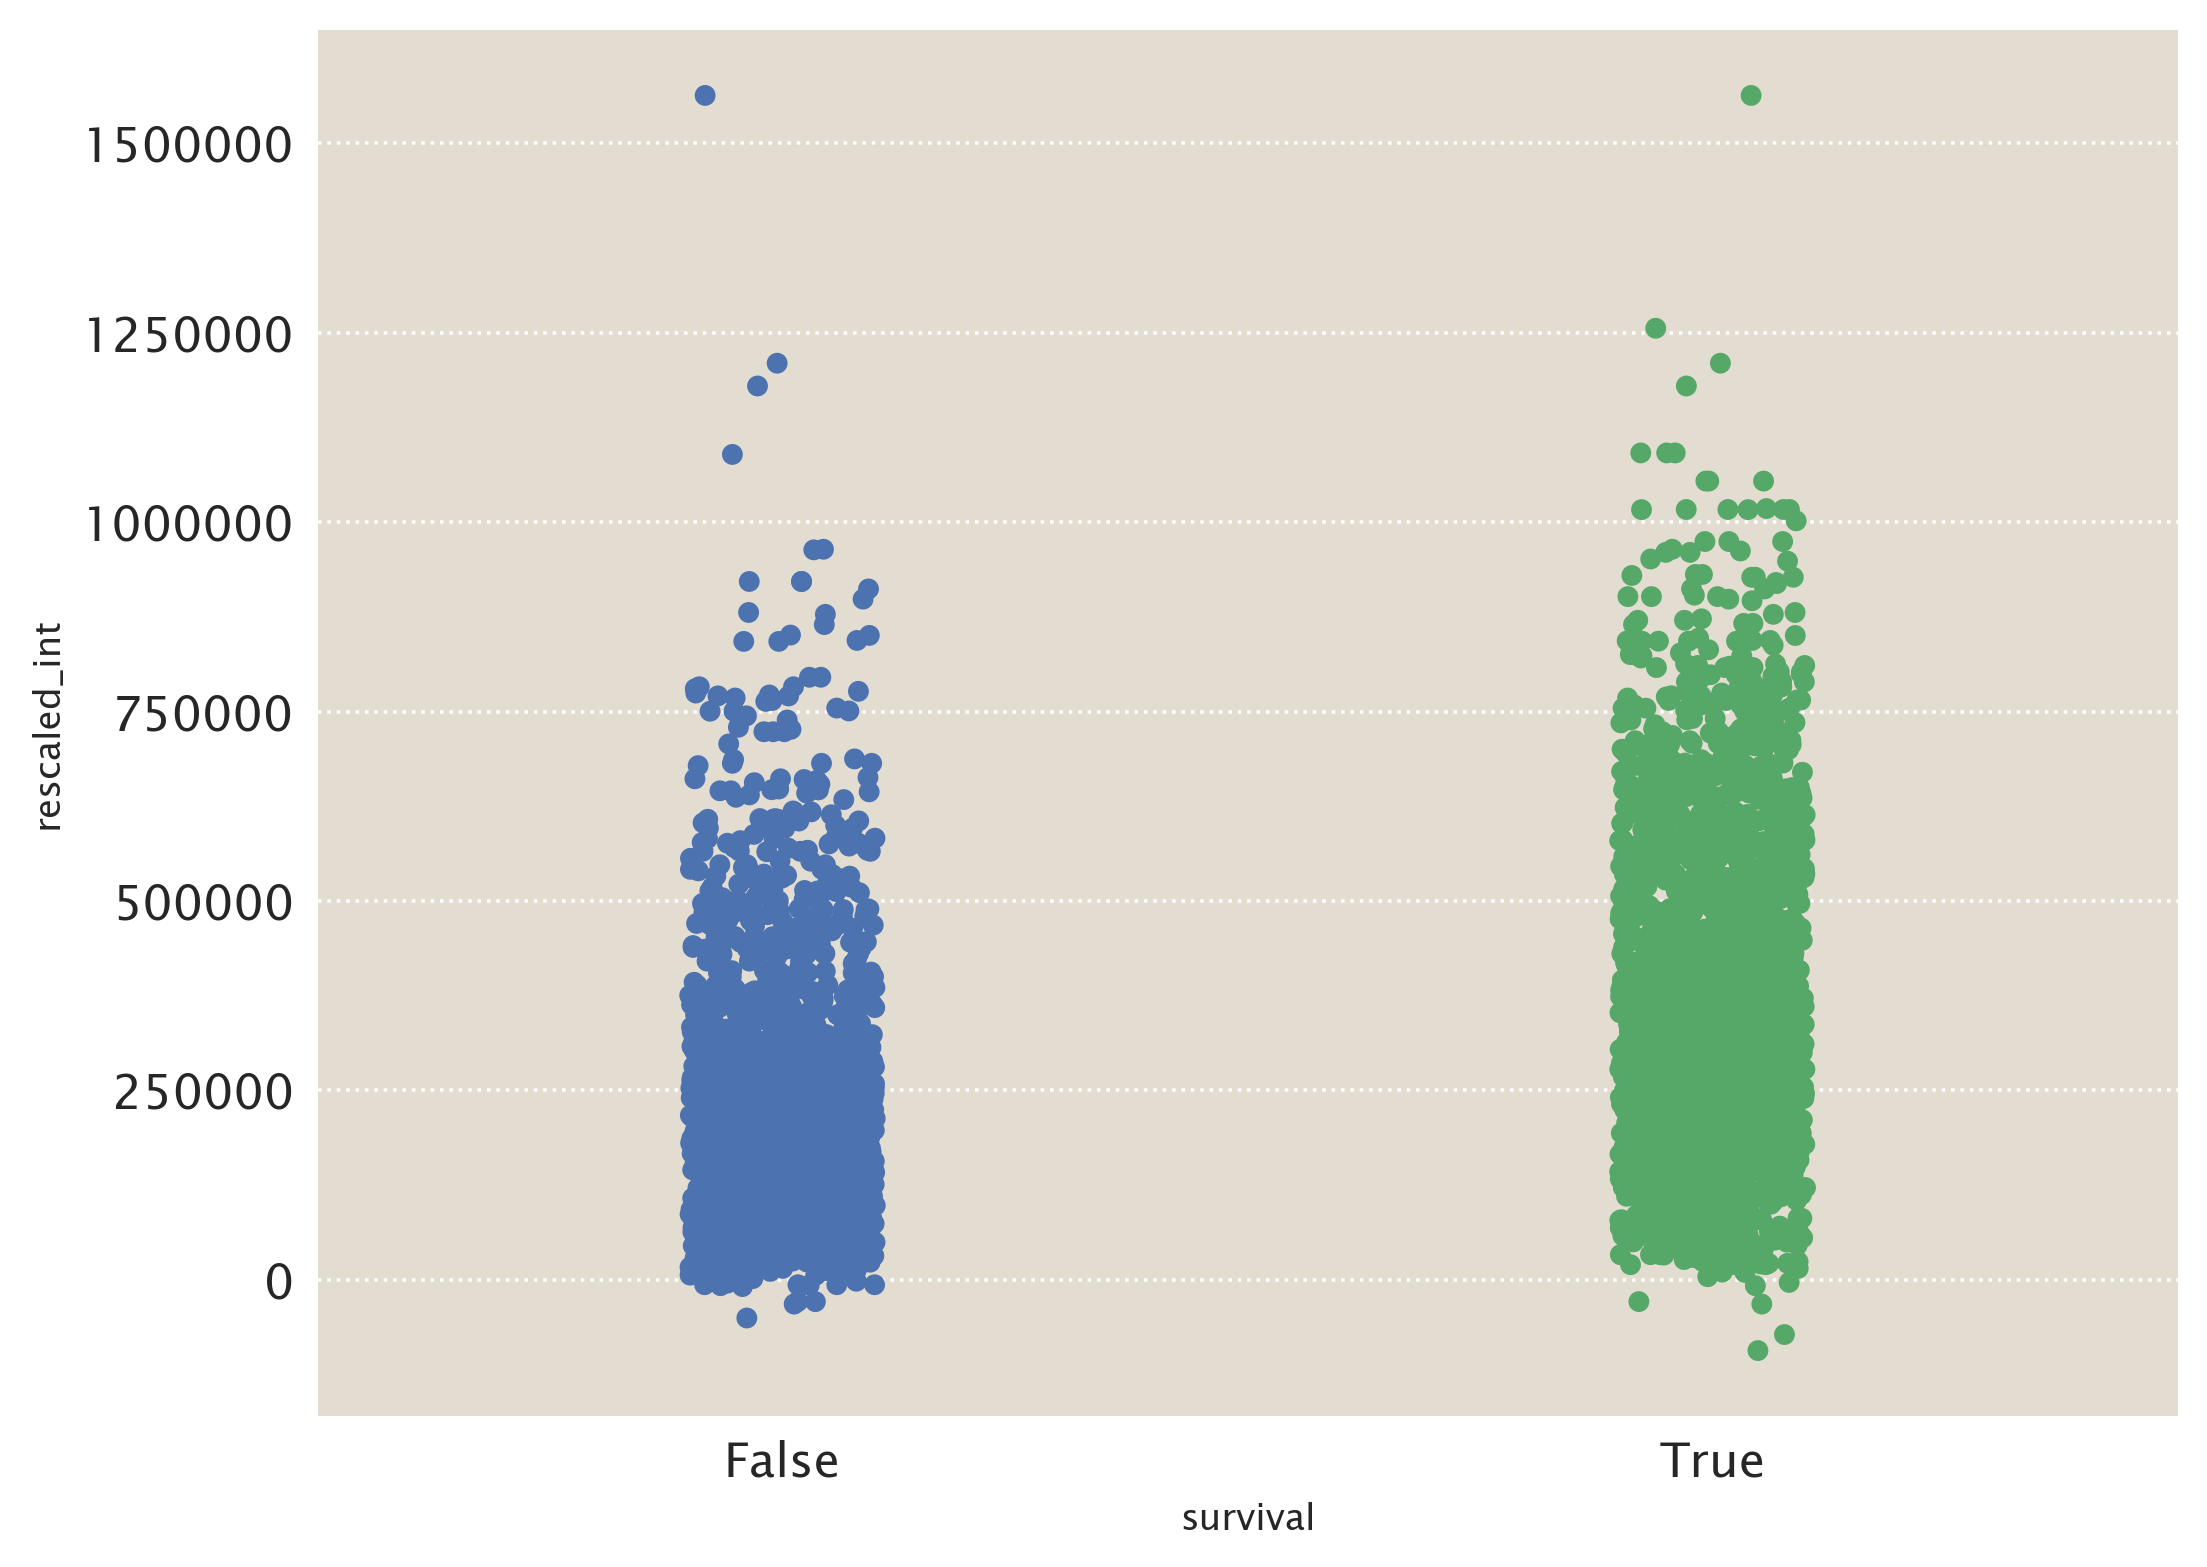

In [57]:
sns.stripplot(x='survival', y='rescaled_int', data=data, jitter=True)

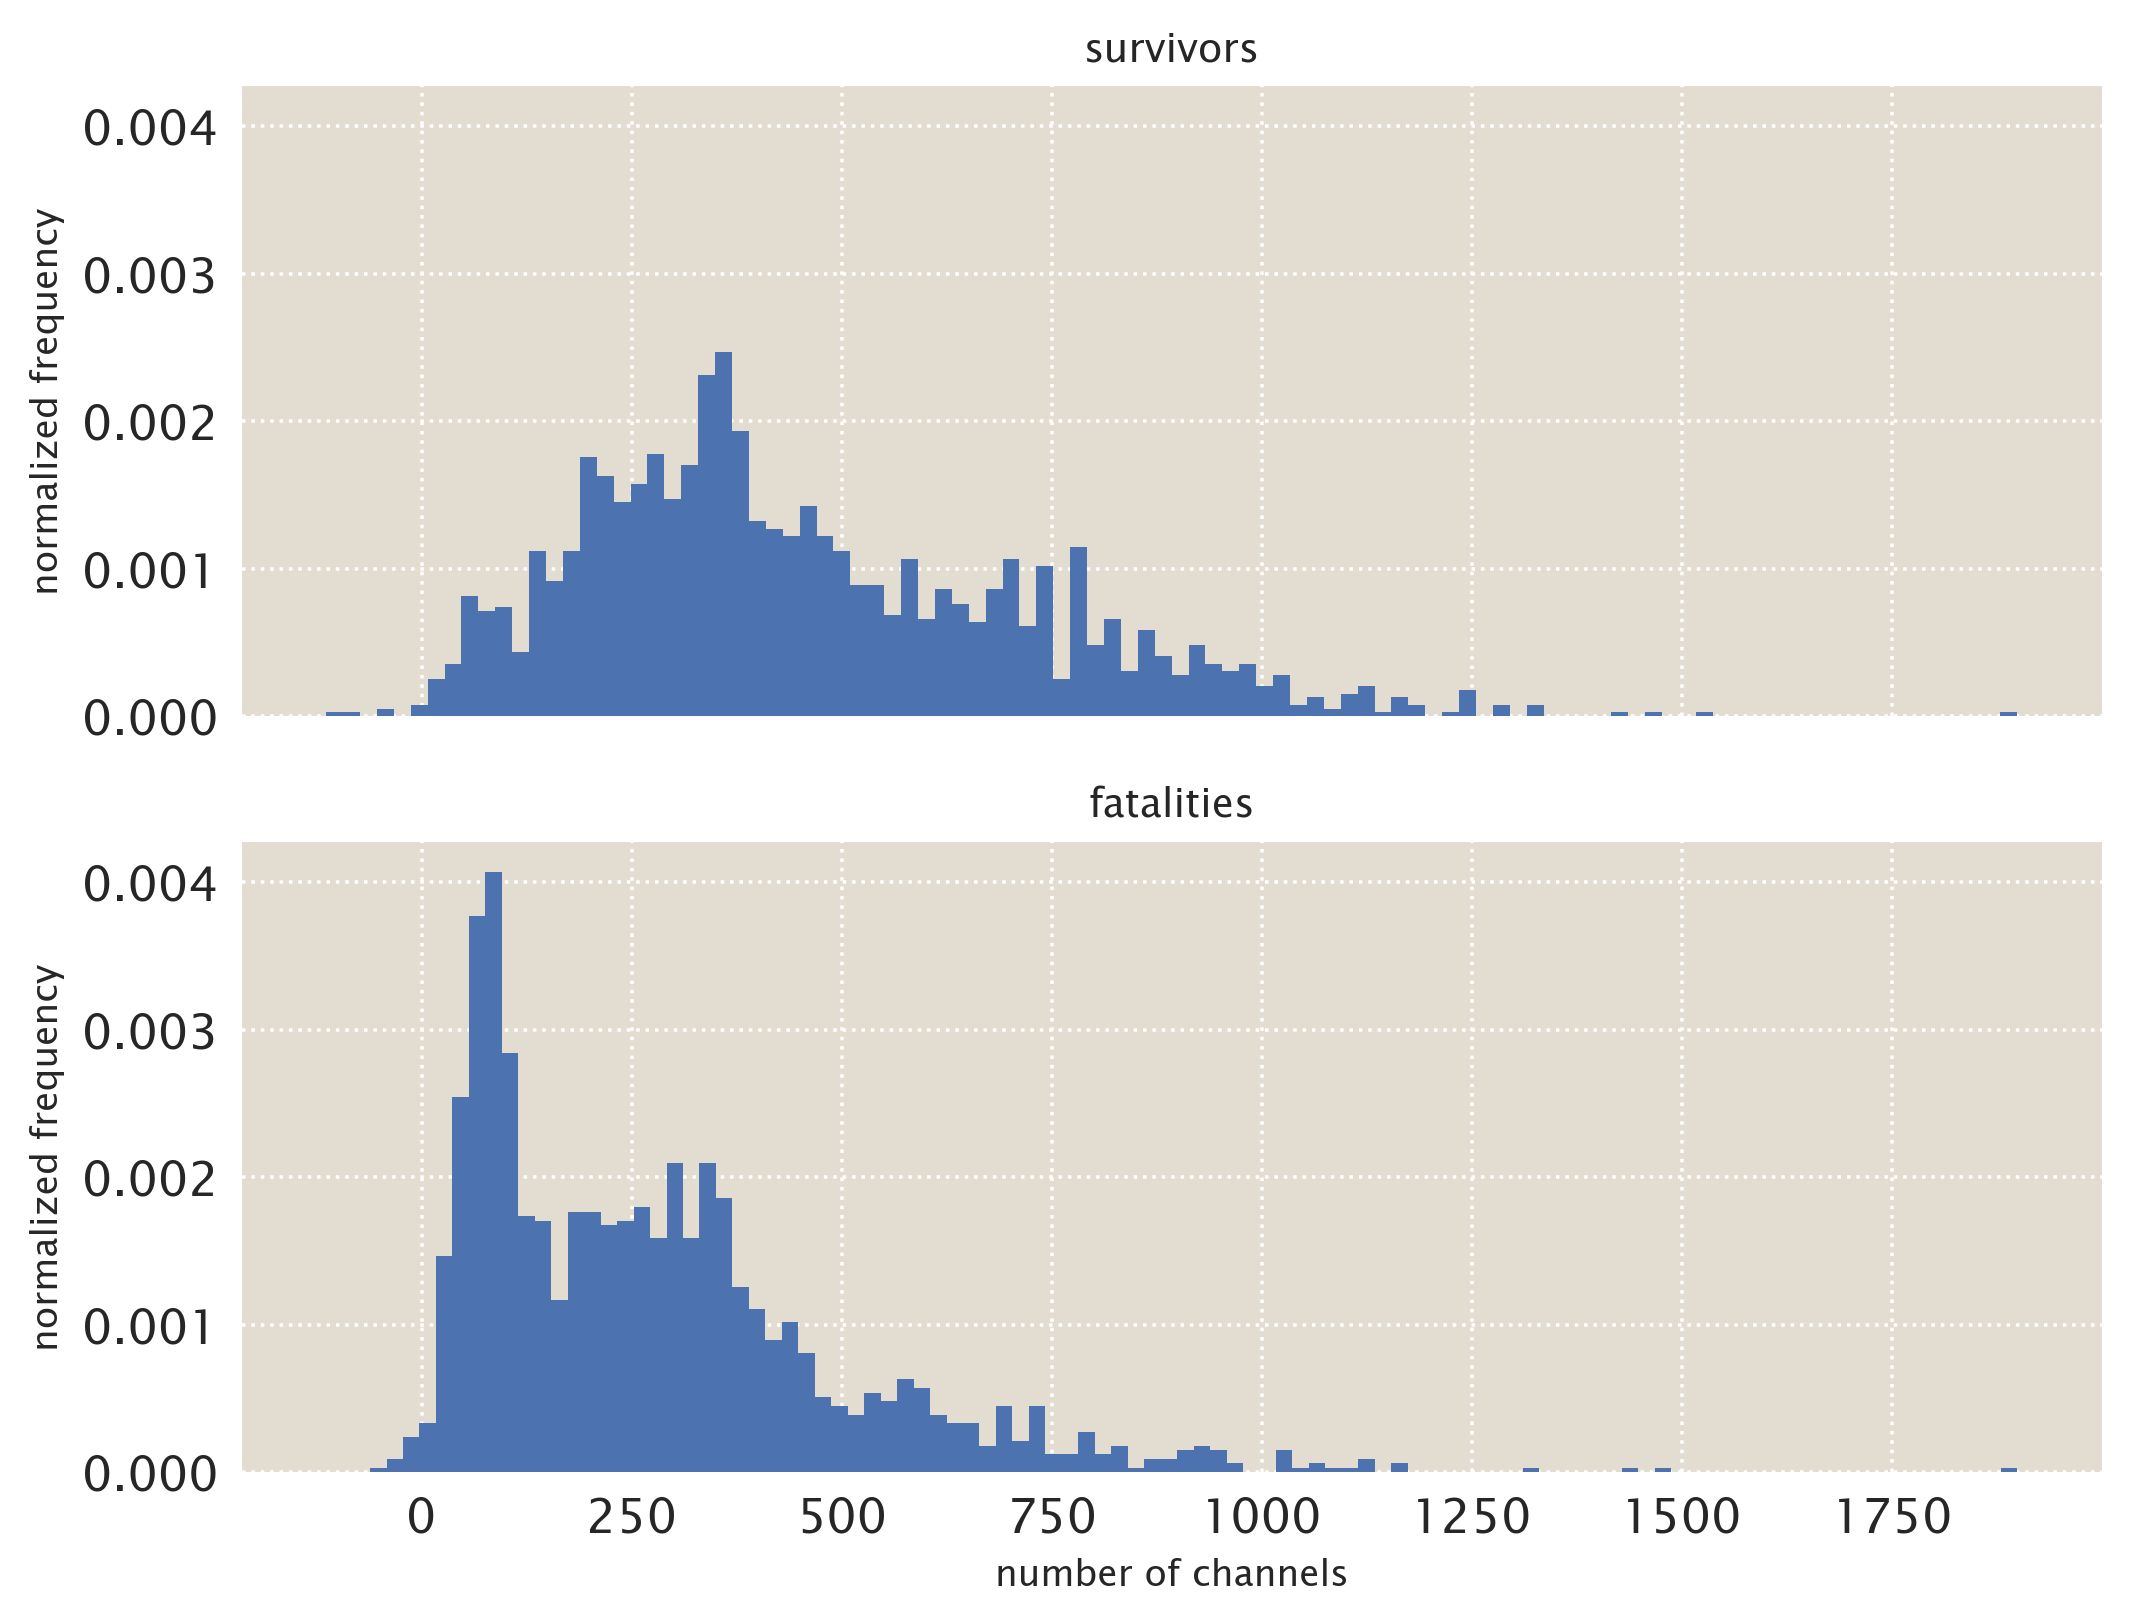

In [84]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)
_ = ax[0].hist(data[data['survival']==True]['rescaled_int'] * fl_per_channel, bins=100, normed=True)
_  = ax[1].hist(data[data['survival']==False]['rescaled_int'] * fl_per_channel, bins=100, normed=True)
# for a in ax:
#     a.set_xlim((400000, 600000))
ax[0].set_title('survivors')
ax[1].set_title('fatalities')
for a in ax:
    a.set_ylabel('normalized frequency')
ax[1].set_xlabel('number of channels')

In [59]:
def ecdf(data):
    return np.sort(data), np.arange(0, len(data))/len(data)

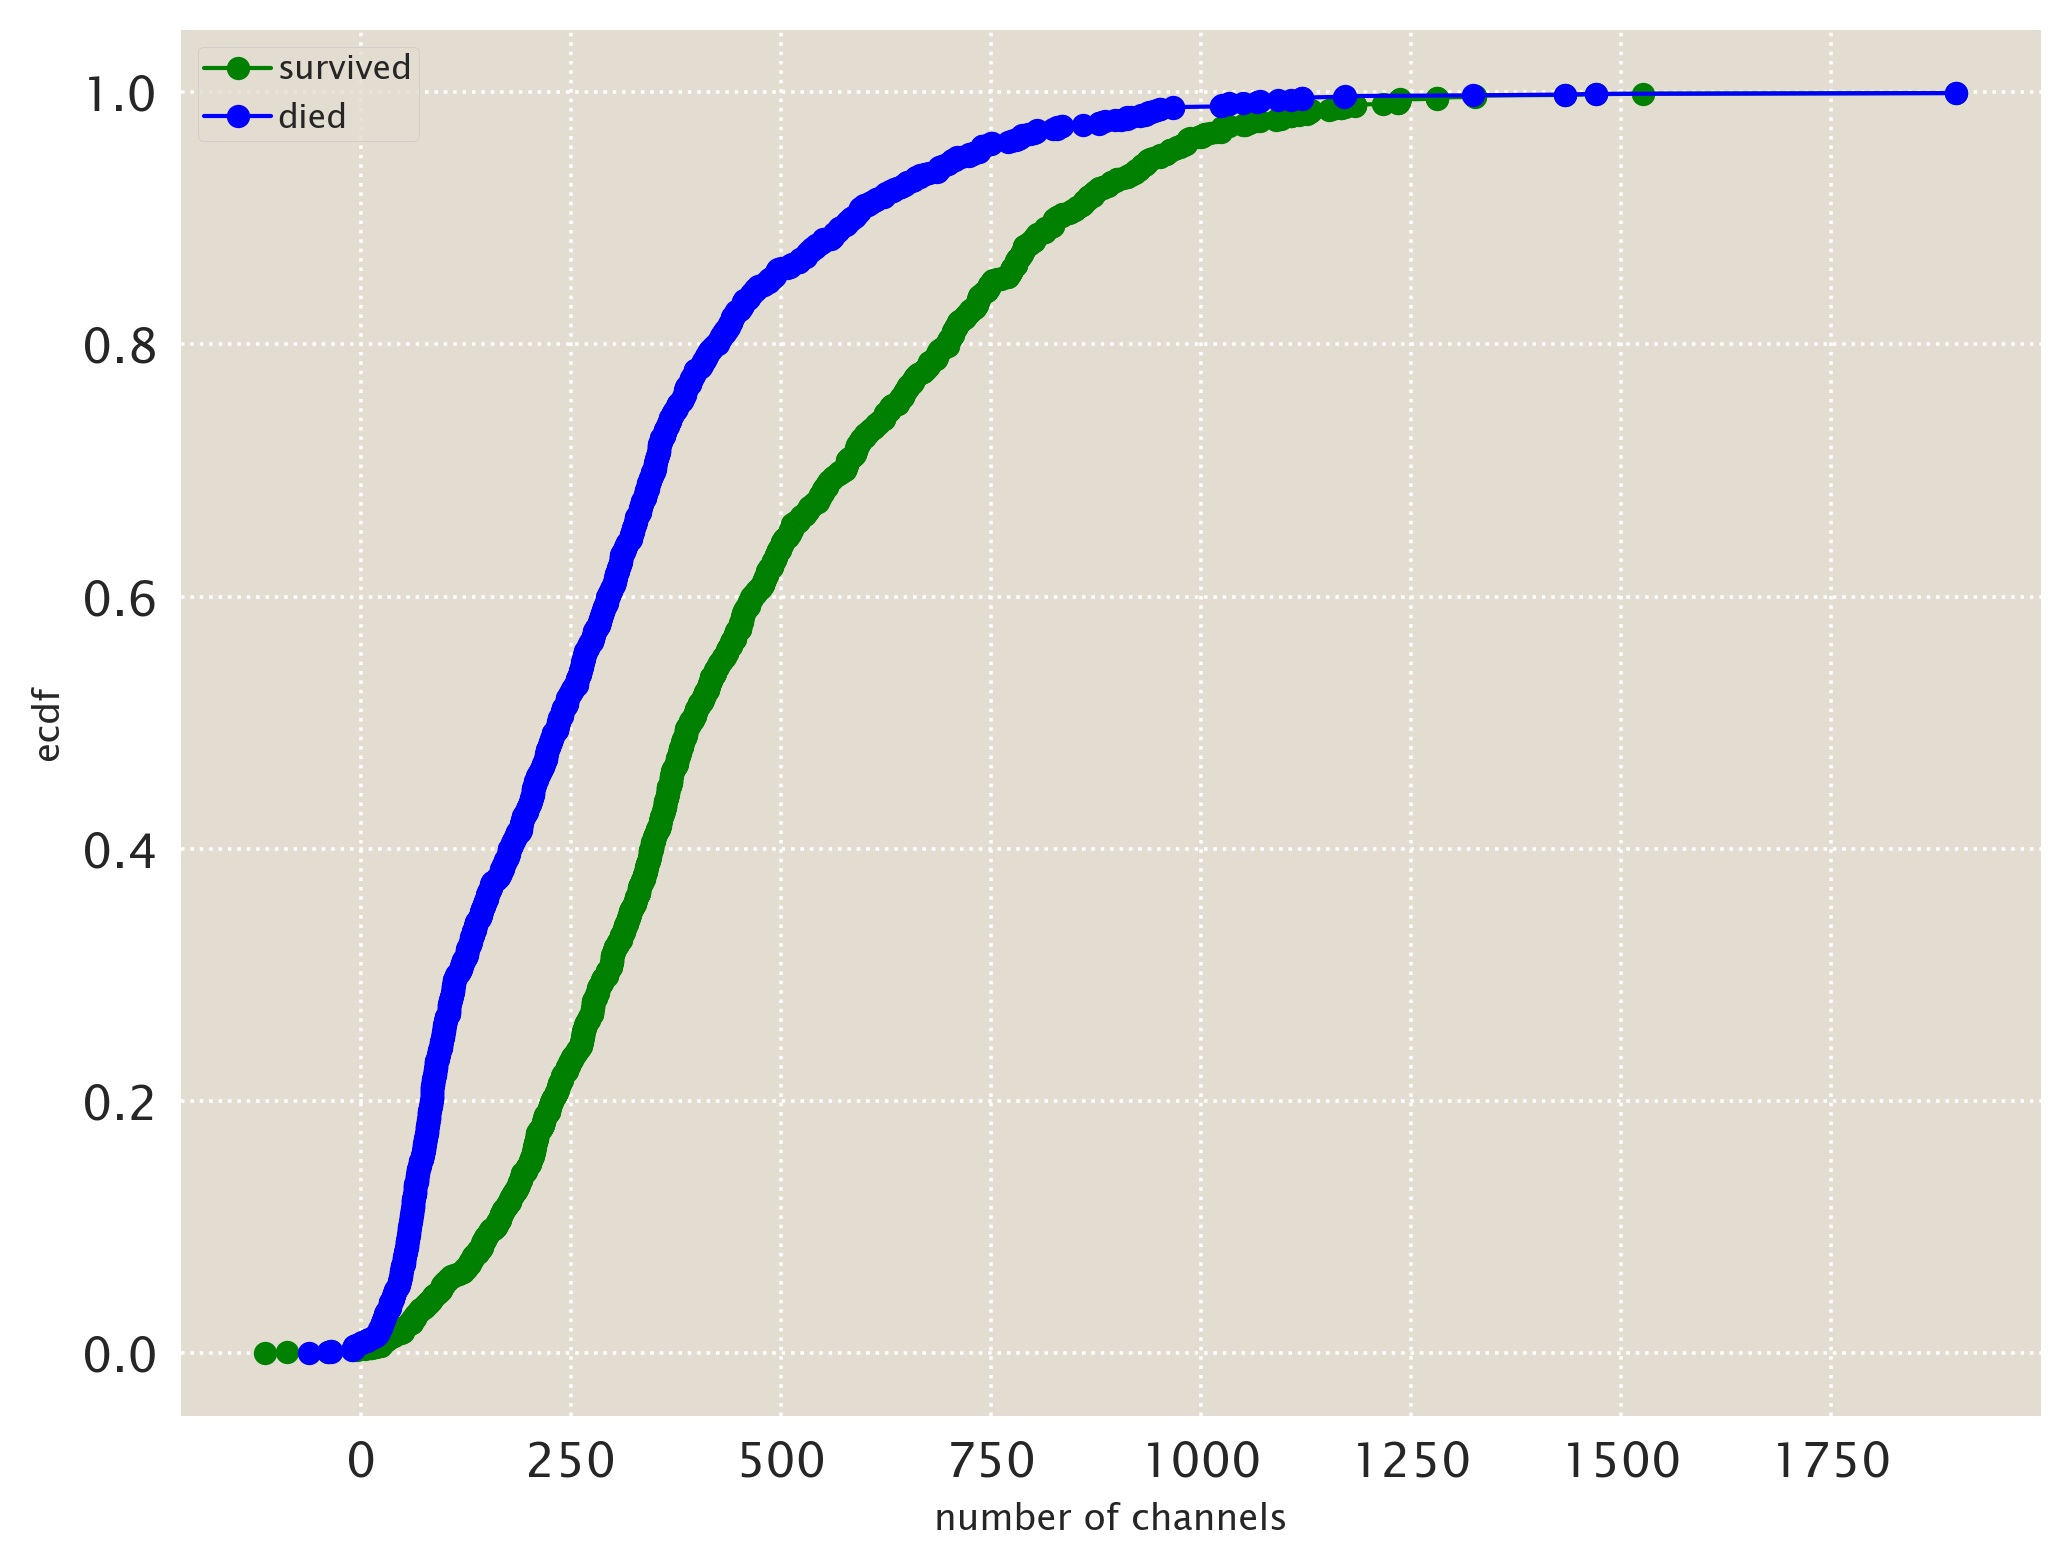

In [85]:
fig, ax = plt.subplots(1,1)
surv_x, surv_y = ecdf(data[data.survival == True]['rescaled_int'] * fl_per_channel)
death_x, death_y = ecdf(data[data.survival == False]['rescaled_int']* fl_per_channel)
_ = ax.plot(surv_x, surv_y, 'o-', lw=1, color='g', label='survived') 
_ = ax.plot(death_x, death_y, 'o-', lw=1, color='b', label='died') 
ax.set_xlabel('number of channels')
ax.set_ylabel('ecdf')
ax.legend()

(array([  3.,   0.,   0.,   1.,   2.,   2.,   1.,   1.,   1.,   2.,   0.,
          1.,   5.,   2.,   2.,   4.,   5.,   2.,   4.,   4.,   8.,   2.,
          6.,   4.,   4.,   8.,   9.,   8.,   5.,   9.,   4.,  10.,   8.,
          3.,  10.,   7.,   4.,   9.,   9.,   8.,   7.,   4.,   6.,   9.,
          6.,   7.,   2.,   6.,   5.,   2.,   1.,   0.,   3.,   3.,   4.,
          0.,   0.,   2.,   3.,   3.,   0.,   1.,   0.,   1.,   1.,   0.,
          0.,   1.,   1.,   2.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,
          1.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]), array([ 324725.9384984 ,  330651.56973842,  336577.20097843,
         342502.83221845,  348428.46345847,  354354.09469848,
         360279.7259385 ,  366205.35717851,  372130.98841853,
         378056.61965855,  383982.25089856,  389907.88213858,
         395833.51337859,  401759.14461861,  407684.77585863,
         

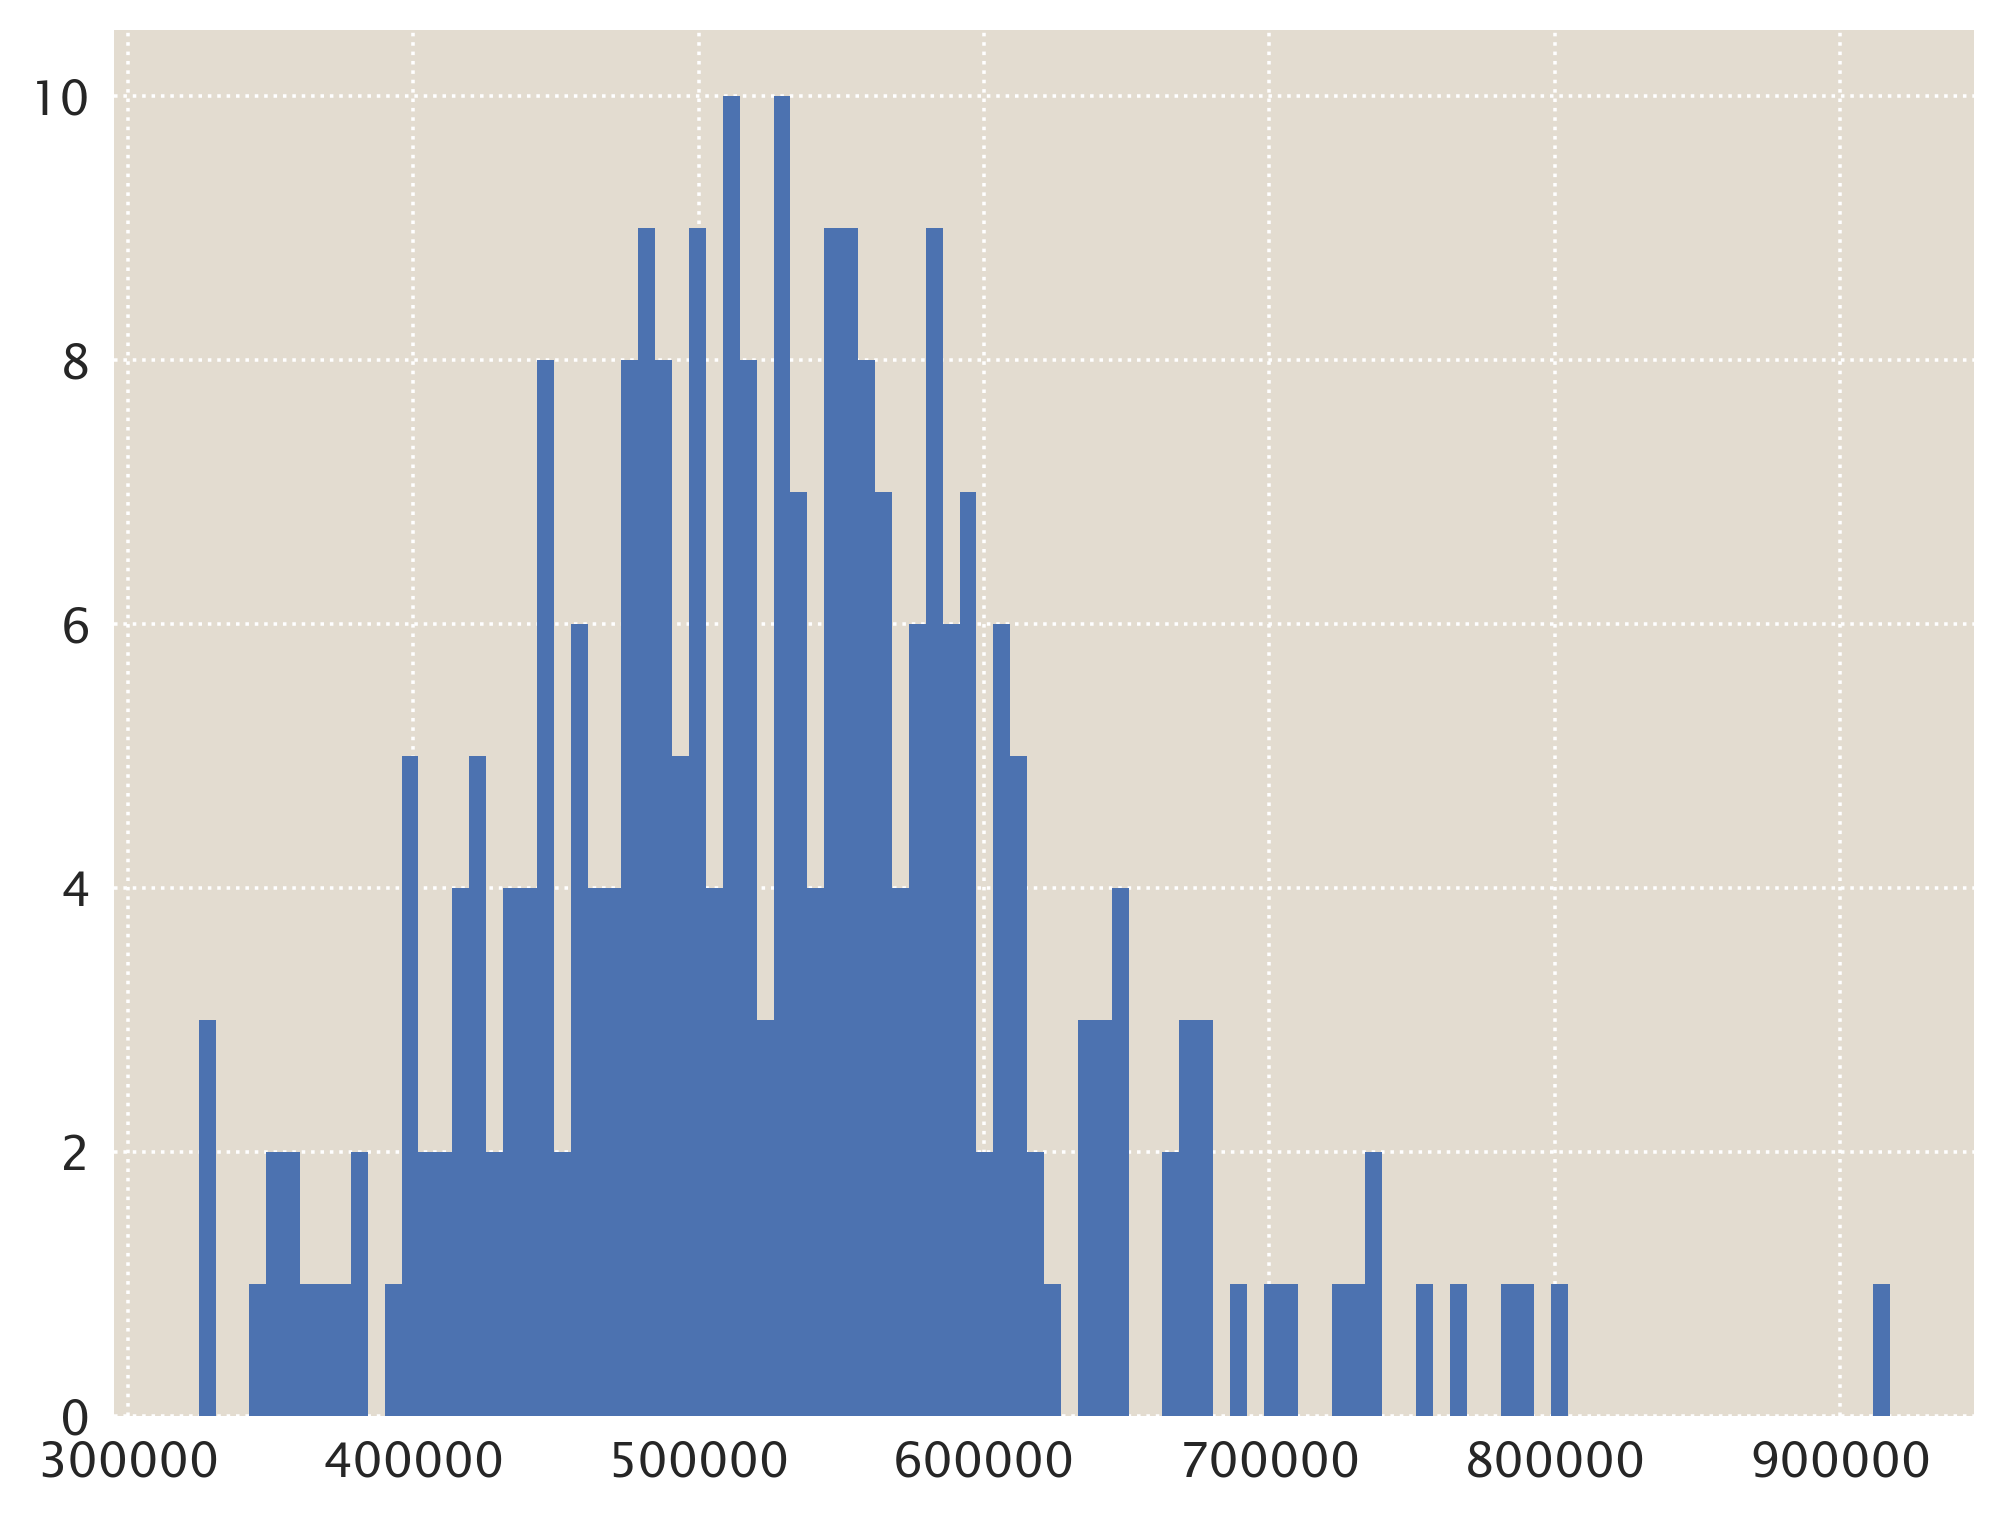

In [509]:
plt.hist(SDdata[SDdata['sd']=='sd0']['raw_rescaled'], bins=100)

In [556]:
data.groupby

array(['April21', 'April24', 'April26', 'April27', 'April28', 'xx'], dtype=object)

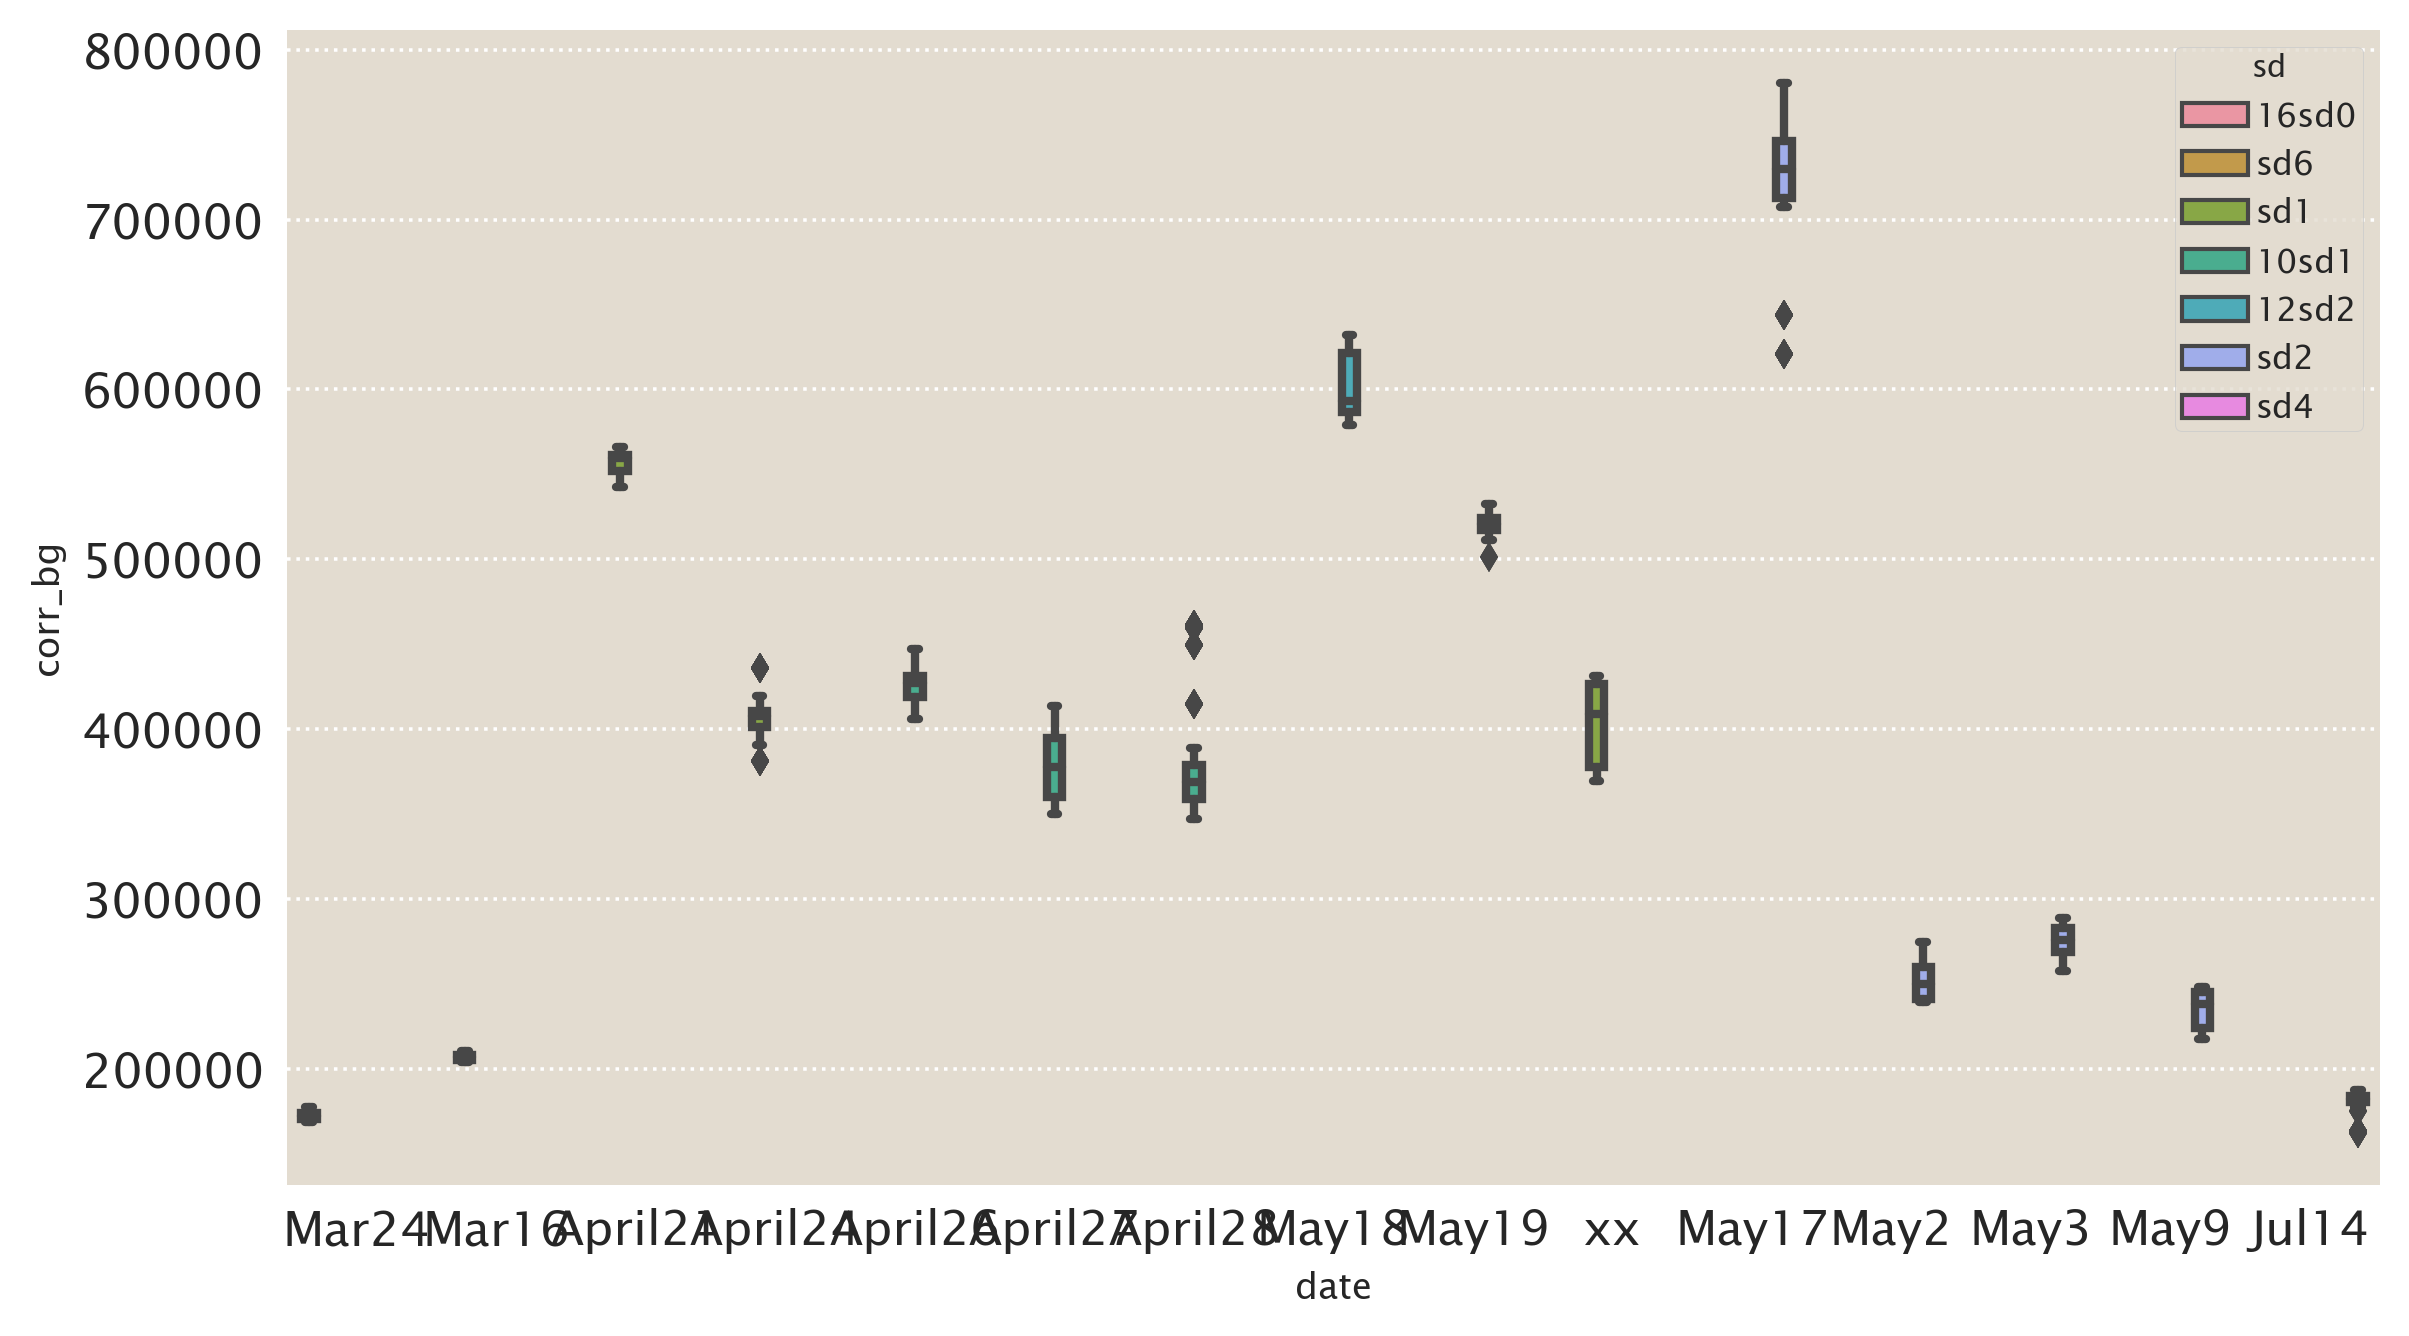

In [61]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
data['corr_bg'] = data['mean_bg'] * max_exp / data['exposure_ms']
sns.boxplot(x='date', y='corr_bg', hue='sd', data=data, ax=ax)